# Part B: Figures
# Introduction
This notebook contains all code that has been used to generate the anaylsis and figures of the  "How landscape data quality affects our perception of dominant processes in large-sample hydrology studies?" paper by do Nascimento et al. (in review). To be able to run this notebook, please ebsure that you have downloaded the acompanying data of the paper. All links can be found in the data section of the paper.

Author: Thiago Nascimento (thiago.nascimento@eawag.ch)

# Imports

In [1]:
import pandas as pd
import numpy as np
import tqdm
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from utils.functions import find_unique_nested_catchments, find_max_unique_rows
from utils.plots import plot_watershed_groups_from_dict
from utils.plots import generate_legend_and_color_mapping


# Configurations

In [2]:
# Only editable variables:
# Relative path to your local directory
PATH = ".."

# Set the directory:
os.chdir(PATH)

warnings.simplefilter(action='ignore', category=Warning)

# Import data

### - Network information

In [3]:
network_estreams = pd.read_csv('data/EStreams/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

network_estreams

gauge_id           gauge_name gauge_country gauge_provider  \
basin_id                                                              
AT000001   200014                Bangs            AT        AT_EHYD   
AT000002   200048  Schruns (Vonbunweg)            AT        AT_EHYD   
AT000003   231662        Loruens-Aeule            AT        AT_EHYD   
AT000004   200592    Kloesterle (OEBB)            AT        AT_EHYD   
AT000005   200097  Buers (Bruecke L82)            AT        AT_EHYD   
...           ...                  ...           ...            ...   
UAGR0017  6682300          BASHTANOVKA            UA        UA_GRDC   
UAGR0018  6682500                YALTA            UA        UA_GRDC   
UAGR0019  6683010           PIONERSKOE            UA        UA_GRDC   
UAGR0020  6683200               TOKMAK            UA        UA_GRDC   
UAGR0021  6683300          NOVOSELOVKA            UA        UA_GRDC   

              river   lon_snap   lat_snap        lon        lat elevation  \
basin_id                                                                    
AT000001      Rhein   9.534835  47.273748   9.534835  47.273748       420   
AT000002       Litz   9.913677  47.080301   9.913677  47.080301       673   
AT000003        Ill   9.847765  47.132821   9.847765  47.132821       579   
AT000004     Alfenz  10.061843  47.128994  10.061843  47.128994      1014   
AT000005     Alvier   9.802668  47.150770   9.802668  47.150770       564   
...             ...        ...        ...        ...        ...       ...   
UAGR0017      KACHA  33.894739  44.691884  33.900000  44.683333       NaN   
UAGR0018  DERE-KIOY  34.166667  44.500000  34.166667  44.500000        16   
UAGR0019     SALHYR  34.199841  44.887685  34.200000  44.883333       307   
UAGR0020     TOKMAK  35.705833  47.251389  35.705833  47.251389       NaN   
UAGR0021     KRYNKA  38.144722  48.153333  38.144722  48.153333       118   

          ...  num_continuous_days  num_days_gaps  num_days_reliable  \
basin_id  ...                                                          
AT000001  ...                 9497            0.0                0.0   
AT000002  ...                23103            0.0                0.0   
AT000003  ...                13513            0.0                0.0   
AT000004  ...                 8765            0.0                0.0   
AT000005  ...                10957            0.0                0.0   
...       ...                  ...            ...                ...   
UAGR0017  ...                 3652            0.0                0.0   
UAGR0018  ...                 3652            0.0                0.0   
UAGR0019  ...                 3652            0.0                0.0   
UAGR0020  ...                 3652            0.0                0.0   
UAGR0021  ...                 3652            0.0                0.0   

          num_days_noflag num_days_suspect gauge_flag  duplicated_suspect  \
basin_id                                                                    
AT000001           9497.0              0.0          B          [CH000197]   
AT000002          23103.0              0.0          B          [CH000221]   
AT000003          13513.0              0.0          B          [CH000215]   
AT000004           8765.0              0.0          B          [CH000227]   
AT000005          10957.0              0.0          B          [CH000214]   
...                   ...              ...        ...                 ...   
UAGR0017           3652.0              0.0          B                 NaN   
UAGR0018           3652.0              0.0          B                 NaN   
UAGR0019           3652.0              0.0          B                 NaN   
UAGR0020           3652.0              0.0          B                 NaN   
UAGR0021           3652.0              0.0          B                 NaN   

          watershed_group  gauges_upstream  \
basin_id                                     
AT000001                1               16   
AT0000

### - Filtered attributes

In [4]:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('data/final_dataset/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 
estreams_attributes

gauge_id           gauge_name gauge_country gauge_provider   river  \
basin_id                                                                      
AT000001   200014                Bangs            AT        AT_EHYD   Rhein   
AT000003   231662        Loruens-Aeule            AT        AT_EHYD     Ill   
AT000005   200097  Buers (Bruecke L82)            AT        AT_EHYD  Alvier   
AT000007   231688            Beschling            AT        AT_EHYD     Ill   
AT000008   200501           Amerluegen            AT        AT_EHYD  Samina   
...           ...                  ...           ...            ...     ...   
UAGR0016  6681500      NOVOGOROZHENOYE            UA        UA_GRDC   INHUL   
UAGR0017  6682300          BASHTANOVKA            UA        UA_GRDC   KACHA   
UAGR0019  6683010           PIONERSKOE            UA        UA_GRDC  SALHYR   
UAGR0020  6683200               TOKMAK            UA        UA_GRDC  TOKMAK   
UAGR0021  6683300          NOVOSELOVKA            UA        UA_GRDC  KRYNKA   

           lon_snap   lat_snap        lon        lat elevation  ...  \
basin_id                                                        ...   
AT000001   9.534835  47.273748   9.534835  47.273748       420  ...   
AT000003   9.847765  47.132821   9.847765  47.132821       579  ...   
AT000005   9.802668  47.150770   9.802668  47.150770       564  ...   
AT000007   9.678850  47.200301   9.678850  47.200301       485  ...   
AT000008   9.614203  47.205978   9.614203  47.205978       603  ...   
...             ...        ...        ...        ...       ...  ...   
UAGR0016  32.350000  47.516667  32.350000  47.516667         8  ...   
UAGR0017  33.894739  44.691884  33.900000  44.683333       NaN  ...   
UAGR0019  34.199841  44.887685  34.200000  44.883333       307  ...   
UAGR0020  35.705833  47.251389  35.705833  47.251389       NaN  ...   
UAGR0021  38.144722  48.153333  38.144722  48.153333       118  ...   

          lulc_2006_agriculture  dam_num  res_num  lakes_num lakes_tot_area  \
basin_id                                                                      
AT000001                  0.127     23.0     10.0       10.0           6.62   
AT000003                  0.040      4.0      4.0        3.0           1.46   
AT000005                  0.023      1.0      1.0        1.0           0.89   
AT000007                  0.058      7.0      6.0        5.0           2.67   
AT000008                  0.016      0.0      0.0        0.0           0.00   
...                         ...      ...      ...        ...            ...   
UAGR0016                  0.000      0.0      0.0       95.0          29.74   
UAGR0017                  0.000      0.0      0.0        1.0           1.43   
UAGR0019                  0.000      0.0      0.0        1.0           0.31   
UAGR0020                  0.000      0.0      0.0        7.0           2.06   
UAGR0021                  0.000      0.0      0.0        7.0           3.72   

         lakes_tot_vol  sno_cov_mean  irri_1990  irri_2005  \
basin_id                                                     
AT000001        542.33        33.844     23.025     29.307   
AT000003         12.91        36.927      0.000      0.204   
AT000005          8.27        34.486      0.000      0.084   
AT000007         23.90        32.887      0.000      0.399   
AT000008          0.00        27.201      0.000      0.000   
...                ...           ...        ...        ...   
UAGR0016        124.55         8.705    163.532    152.585   
UAGR0017         16.43         3.805      0.000      0.000   
UAGR0019          1.54         4.928      0.000      0.000   
UAGR0020          6.95         8.310      0.000      0.000   
UAGR0021         19.48         9.131     17.737     16.757   

          stations_num_p_mean  
basin_id                       
AT000001                 22.0  
AT000003                 18.0  
AT000005                 10.0  
AT000007                 40.0  
AT000008                  8.0 

In [5]:
nested_catchments = pd.DataFrame(estreams_attributes['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)

nested_catchments

nested_catchments
basin_id                                                   
AT000001  [AT000001, CH000010, CH000046, CH000048, CH000...
AT000003                     [AT000002, AT000003, CH000221]
AT000005                               [AT000005, CH000214]
AT000007  [AT000002, AT000003, AT000004, AT000005, AT000...
AT000008                                         [AT000008]
...                                                     ...
UAGR0016                                         [UAGR0016]
UAGR0017                                         [UAGR0017]
UAGR0019                                         [UAGR0019]
UAGR0020                                         [UAGR0020]
UAGR0021                                         [UAGR0021]

[9340 rows x 1 columns]

### - Geology regional (Not in EStreams)

In [6]:
geology_regional_31_classes_moselle = pd.read_csv("data/new_attributes/estreams_geology_moselle_ff_all_classes_attributes.csv", encoding='utf-8')

geology_regional_31_classes_moselle.set_index("basin_id", inplace = True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Alluvium", 'lit_fra_Coal', 'lit_fra_Conglomerate', 'lit_fra_Gravel and sand',
             'lit_fra_Sand', 'lit_fra_Sand and gravel', 'lit_fra_Sandstone and conglomerate', 'lit_fra_Sandstone'
        ],
    
    "medium": ['lit_fra_Limestone', 'lit_fra_Sandstone and marl', 'lit_fra_Sandstone and schist',
              'lit_fra_Sandstone, conglomerate and marl'],
    
    "low": ['lit_fra_Arkose', 'lit_fra_Dolomite rock', 'lit_fra_Limestone and marl', 'lit_fra_Marl', 
             'lit_fra_Marl and dolomite', 'lit_fra_Marl and limestone', 'lit_fra_Marl and sandstone',
               'lit_fra_Sandstone and siltstone', 'lit_fra_Sandstone, siltstone and schist', 
              'lit_fra_Schist and sandstone', 'lit_fra_Silt',  'lit_fra_Silt and schist', 'lit_fra_Siltstone, sandstone and schist'
              
             ],
    
    "verylow": ['lit_fra_Cristallin basement', 'lit_fra_Plutonic rock',  'lit_fra_Quarzite',
                    'lit_fra_Schist','lit_fra_Volcanic rock' 
                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    geology_regional_31_classes_moselle[f'area_perm_{permeability_class}'] = geology_regional_31_classes_moselle[columns].sum(axis=1)

# Drop unnecessary columns
geology_regional_31_classes_moselle = geology_regional_31_classes_moselle[["area_perm_high", "area_perm_medium", "area_perm_low", "area_perm_verylow"]]

# Rename the columns
geology_regional_31_classes_moselle.columns = ["perm_high_regi", "perm_medium_regi", "perm_low_regi", "perm_verylow_regi"]

# Display the updated DataFrame
geology_regional_31_classes_moselle

geology_regional_31_classes_moselle["baseflow_index"] = estreams_attributes["baseflow_index"]
geology_regional_31_classes_moselle.corr(method="pearson")

# Concatenation
estreams_attributes[["perm_high_regi", "perm_medium_regi", "perm_low_regi", "perm_verylow_regi"]] = geology_regional_31_classes_moselle[["perm_high_regi", "perm_medium_regi", "perm_low_regi", "perm_verylow_regi"]]
estreams_attributes

gauge_id           gauge_name gauge_country gauge_provider   river  \
basin_id                                                                      
AT000001   200014                Bangs            AT        AT_EHYD   Rhein   
AT000003   231662        Loruens-Aeule            AT        AT_EHYD     Ill   
AT000005   200097  Buers (Bruecke L82)            AT        AT_EHYD  Alvier   
AT000007   231688            Beschling            AT        AT_EHYD     Ill   
AT000008   200501           Amerluegen            AT        AT_EHYD  Samina   
...           ...                  ...           ...            ...     ...   
UAGR0016  6681500      NOVOGOROZHENOYE            UA        UA_GRDC   INHUL   
UAGR0017  6682300          BASHTANOVKA            UA        UA_GRDC   KACHA   
UAGR0019  6683010           PIONERSKOE            UA        UA_GRDC  SALHYR   
UAGR0020  6683200               TOKMAK            UA        UA_GRDC  TOKMAK   
UAGR0021  6683300          NOVOSELOVKA            UA        UA_GRDC  KRYNKA   

           lon_snap   lat_snap        lon        lat elevation  ...  \
basin_id                                                        ...   
AT000001   9.534835  47.273748   9.534835  47.273748       420  ...   
AT000003   9.847765  47.132821   9.847765  47.132821       579  ...   
AT000005   9.802668  47.150770   9.802668  47.150770       564  ...   
AT000007   9.678850  47.200301   9.678850  47.200301       485  ...   
AT000008   9.614203  47.205978   9.614203  47.205978       603  ...   
...             ...        ...        ...        ...       ...  ...   
UAGR0016  32.350000  47.516667  32.350000  47.516667         8  ...   
UAGR0017  33.894739  44.691884  33.900000  44.683333       NaN  ...   
UAGR0019  34.199841  44.887685  34.200000  44.883333       307  ...   
UAGR0020  35.705833  47.251389  35.705833  47.251389       NaN  ...   
UAGR0021  38.144722  48.153333  38.144722  48.153333       118  ...   

          lakes_tot_area  lakes_tot_vol  sno_cov_mean  irri_1990 irri_2005  \
basin_id                                                                     
AT000001            6.62         542.33        33.844     23.025    29.307   
AT000003            1.46          12.91        36.927      0.000     0.204   
AT000005            0.89           8.27        34.486      0.000     0.084   
AT000007            2.67          23.90        32.887      0.000     0.399   
AT000008            0.00           0.00        27.201      0.000     0.000   
...                  ...            ...           ...        ...       ...   
UAGR0016           29.74         124.55         8.705    163.532   152.585   
UAGR0017            1.43          16.43         3.805      0.000     0.000   
UAGR0019            0.31           1.54         4.928      0.000     0.000   
UAGR0020            2.06           6.95         8.310      0.000     0.000   
UAGR0021            3.72          19.48         9.131     17.737    16.757   

         stations_num_p_mean  perm_high_regi  perm_medium_regi  perm_low_regi  \
basin_id                                                                        
AT000001                22.0             NaN               NaN            NaN   
AT000003                18.0             NaN               NaN            NaN   
AT000005                10.0             NaN               NaN            NaN   
AT000007                40.0             NaN               NaN            NaN   
AT000008                 8.0             NaN               NaN            NaN   
...                      ...             ...               ...            ...   
UAGR0016                 4.0             NaN               NaN            NaN   
UAGR0017                 3.0             NaN               NaN            NaN   
UAGR0019                 1.0             NaN               NaN            NaN   
UAGR0020                 1.0             NaN               NaN            NaN   
UAGR0021                 1.0             NaN               NaN        

### - Catchment boundaries

In [7]:
catchment_boundaries = gpd.read_file('data/EStreams/shapefiles/estreams_catchments.shp')
catchment_boundaries

basin_id gauge_id country  area_offic  area_estre  area_flag  area_rel  \
0      AT000001   200014      AT      4647.9    4668.379          0 -0.440608   
1      AT000002   200048      AT       102.0     102.287          0 -0.281373   
2      AT000003   231662      AT       535.2     536.299          0 -0.205344   
3      AT000004   200592      AT        66.6      66.286          0  0.471471   
4      AT000005   200097      AT        72.2      72.448          0 -0.343490   
...         ...      ...     ...         ...         ...        ...       ...   
17125  UAGR0017  6682300      UA       321.0     325.370          0 -1.361371   
17126  UAGR0018  6682500      UA        49.7      47.594          0  4.237425   
17127  UAGR0019  6683010      UA       261.0     244.731          1  6.233333   
17128  UAGR0020  6683200      UA       760.0     731.073          0  3.806184   
17129  UAGR0021  6683300      UA       582.0     599.600          0 -3.024055   

       start_date    end_date gauge_flag  upstream  group  \
0      1996-01-01  2021-12-31          B        16      1   
1      1958-10-01  2021-12-31          B         1      1   
2      1985-01-02  2021-12-31          B         2      1   
3      1998-01-02  2021-12-31          B         1      1   
4      1990-01-01  2019-12-31          B         3      1   
...           ...         ...        ...       ...    ...   
17125  1978-01-01  1987-12-31          B         1   1988   
17126  1978-01-01  1987-12-31          B         1   1989   
17127  1978-01-01  1987-12-31          B         1   1990   
17128  1978-01-01  1987-12-31          B         1   1991   
17129  1978-01-01  1987-12-31          B         1   1992   

                                                geometry  
0      POLYGON Z ((9.69406 46.54322 0.00000, 9.69570 ...  
1      POLYGON Z ((10.13650 47.02949 0.00000, 10.1349...  
2      POLYGON Z ((10.11095 46.89437 0.00000, 10.1122...  
3      POLYGON Z ((10.14189 47.09706 0.00000, 10.1404...  
4      POLYGON Z ((9.67851 47.06249 0.00000, 9.67888 ...  
...                                                  ...  
17125  POLYGON Z ((33.96791 44.63291 0.00000, 33.9679...  
17126  POLYGON Z ((34.19958 44.58291 0.00000, 34.2029...  
17127  POLYGON Z ((34.19624 44.88375 0.00000, 34.1962...  
17128  POLYGON Z ((35.78708 47.28708 0.00000, 35.7870...  
17129  POLYGON Z ((38.10125 48.15791 0.00000, 38.1004...  

[17130 rows x 13 columns]

# Regional catchments
Here we evaluate the correlation for the 57 regional catchments worked with

In [8]:
# This list of regional catchments was defined using a visual inspection with GIS
list_cats_list = ["ES000801", "ES000665","ES001243", "ES000196", "ES000116", "ES000194", "ES001080", "ES000316","ES000397","ES000339","ES000331", 
                  "GB000472", "GB000271", "GB000153","ITTO0361","ITVE0408","ITLC0146", "ITPI0183", "SE000102", "FI000668", "FI000585", "FI000557", 
                  "FI000226", "FI000137", "PL000936","PL000905", "PL000868", "PL000794","HR000048","HUGR0037", "AT000393", "PL000253", 
                  "PL000349", "PL000015","CZ000097","DEST1711", "DEBY0711","DEBY0724", "DEBY0697", "DEBU1953", "NL000008","CH000026", "FR002679", 
                  "FR004615", "NL000016", "BEVL0155", "FR000408", "FR000373", "FR000345", "FR001071", "FR003922", "FR003986", "FR002118", "FR001952",
                  "FR002029", "FR001604", "FR004221", "ES000738","ES001171", "ES001010", "PL001056", "PL000536", "HR000278", "CZ000236","DEST1707", 
                  "DEBE0155","FR002758","FR002462","FR001394", "FR000867", "FR004308", "DEBU1959"] 

In [9]:
# Initialize dictionaries and DataFrames to store grouped correlations and geological differences
corr_max_group_dfs_dict = {}
corr_max_geology_diff = pd.DataFrame()
corr_max_geology_diff_abs = pd.DataFrame()
corr_max_geology_diff_above_05 = pd.DataFrame()

# Initialize DataFrames to store correlations for different geological, climate, soil, and land-use variables
corr_low_geology_df = pd.DataFrame()
corr_med_geology_df = pd.DataFrame()
corr_low_geology_df_25 = pd.DataFrame()
corr_med_geology_df_25 = pd.DataFrame()
corr_med_climate_df = pd.DataFrame()
corr_med_soils_df = pd.DataFrame()
corr_med_topography_df = pd.DataFrame()
corr_med_landuse_df = pd.DataFrame()

# DataFrame to store the number of nested catchments per watershed
lens_df = pd.DataFrame()

# Loop over each list of catchments in the main list
for list_cats in tqdm.tqdm(list_cats_list):
    nested_cats_df = nested_catchments.loc[[list_cats], :] # Select rows for the current list of catchments

    # Filter catchments using a function to find the ones with maximum unique rows
    nested_cats_filtered = find_max_unique_rows(nested_cats_df)
    nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]

    # Initialize a dictionary to store data for each selected catchment with more than 20 nested catchments
    estreams_attributes_dfs = {}
    for catchment in nested_cats_filtered:
        nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']              # Retrieve the nested list of catchments for the current catchment
        nested_clip = [value for value in nested_clip if value in estreams_attributes.index]   # Filter values to include only those that exist in the index of estreams_attributes
        cat_clip = estreams_attributes.loc[nested_clip, :]                                     # Filter the estreams_attributes DataFrame based on the filtered nested_clip
        estreams_attributes_dfs[catchment] = cat_clip                                          # Store the resulting DataFrame in the dictionary

    # Create DataFrame to store the number of nested catchments per catchment
    catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
    for catchment, data in estreams_attributes_dfs.items():
        catchment_lens.loc[catchment, "len"] = len(data)                                       # Count of nested catchments


    # Filter catchments with at least 10 nested catchments
    nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]
    nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]  # Here we filter the catchemnts for the list (again, after we apply our function):


    # Reinitialize dictionary to store data for selected catchments above 20 nested catchments
    estreams_attributes_dfs = {}
    for catchment in nested_cats_filtered_abovevalue_df.index:
        nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']   # Retrieve the nested list of catchments for the current catchment
        nested_clip = [value for value in nested_clip if value in estreams_attributes.index]   # Filter values to include only those that exist in the index of estreams_attributes
        cat_clip = estreams_attributes.loc[nested_clip, :]                                     # Filter the estreams_attributes DataFrame based on the filtered nested_clip
        estreams_attributes_dfs[catchment] = cat_clip                                          # Store the resulting DataFrame in the dictionary


    # Further filter catchments to include data from 2009 onwards
    estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
    estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date >= "2009"]

    nested_cats_filtered_abovevalue["len"] = len(estreams_attributes_dfs_cat)
    # Initialize a dictionary to store correlation DataFrames for each variable in a selected range
    correlation_dict = {}
    for variable in estreams_attributes.columns[29:43]:
        correlation_df = pd.DataFrame()                                                        # Initialize an empty DataFrame to store correlations

        # Iterate over each watershed group
        for catchment in estreams_attributes_dfs.keys():

            estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
            'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
            'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
            'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
            'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
            'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
            'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
            'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

            "perm_high_glob", "perm_medium_glob", "perm_low_glob", "perm_verylow_glob", 
            "perm_high_cont", "perm_medium_cont", "perm_low_cont", "perm_verylow_cont",
            "perm_high_regi", "perm_medium_regi", "perm_low_regi", "perm_verylow_regi",

            'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
            'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
            'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
            'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
            'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
            'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
            'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]]
            
            # Calculate correlations between the current variable and other variables
            correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
            correlation_df[catchment] = correlations                                               # Store the correlations to the DataFrame

        # Add the correlation DataFrame to the dictionary
        correlation_dict[variable] = correlation_df

    # Create a list to store all correlation DataFrames with a signature column
    correlation_list = []
    # Iterate over all keys in the dictionary and append their DataFrame to the list with an added 'signature' column
    for signature in correlation_dict.keys():
        corr_df = correlation_dict[signature].T
        corr_df['signature'] = signature                                                           # Add a column to identify the signature
        correlation_list.append(corr_df)

    # Concatenate all correlation DataFrames along the rows
    combined_correlation_df = pd.concat(correlation_list)

    # Preserve the order of the signatures by converting to categorical type
    combined_correlation_df['signature'] = pd.Categorical(
        combined_correlation_df['signature'],
        categories=list(correlation_dict.keys()),
        ordered=True)
    combined_correlation_df.set_index('signature', inplace=True)                                   # Set 'signature' as index

    # Dictionary to classify variables into categories (climatic, topography, geology, etc.)
    variable_dict = {
        'p_mean': 'climatic',
        'pet_mean': 'climatic',
        'aridity': 'climatic',
        'p_seasonality': 'climatic',
        'frac_snow': 'climatic',
        'hp_freq': 'climatic',
        'hp_dur': 'climatic',
        'hp_time': 'climatic',
        'lp_freq': 'climatic',
        'lp_dur': 'climatic',
        'lp_time': 'climatic',
        'ele_mt_max': 'topography',
        'ele_mt_mean': 'topography',
        'ele_mt_min': 'topography',
        'slp_dg_mean': 'topography',
        'flat_area_fra': 'topography',
        'steep_area_fra': 'topography',
        'elon_ratio': 'topography',
        'strm_dens': 'topography',
        'lit_dom': 'geology',
        'bedrk_dep': 'soil',

        'perm_verylow_glob': 'geology_low',
        'perm_low_glob': 'geology_low',
        'perm_medium_glob': 'geology_low',
        'perm_high_glob': 'geology_low',

        'root_dep_mean': 'soil',
        'root_dep_max': 'soil',
        'root_dep_min': 'soil',
        'soil_tawc_mean': 'soil',
        'soil_fra_sand_mean': 'soil',
        'soil_fra_silt_mean': 'soil',
        'soil_fra_clay_mean': 'soil',
        'soil_fra_grav_mean': 'soil',
        'soil_bd_mean': 'soil',
        'soil_oc_mean': 'soil',
        'lai_mean': 'lulc',
        'ndvi_mean': 'lulc',
        'lulc_2006_urban': 'lulc',
        'lulc_2006_NonIrriAgri': 'lulc',
        'lulc_2006_Agric': 'lulc',
        'lulc_2006_forest': 'lulc',
        'lulc_2006_grass': 'lulc',
        'lulc_2006_agriculture': 'lulc',
        'dam_num': 'hydrology',
        'res_num': 'hydrology',
        'lakes_num': 'hydrology',
        'sno_cov_mean': 'climatic',
        'irri_1990': 'hydrology',
        'irri_2005': 'hydrology',

        'perm_high_cont': 'geology_med',
        'perm_medium_cont': 'geology_med',
        'perm_low_cont': 'geology_med',
        'perm_verylow_cont': 'geology_med',

        'stations_num_p_mean': 'climatic',

        'perm_high_regi': "geology_high", 
        'perm_medium_regi': "geology_high", 
        'perm_low_regi': "geology_high",
        'perm_verylow_regi': "geology_high",
        "area_estreams": "topography"
    }


    # Define variable signatures for the analysis
    signatures = ['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 
                'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq']


    # Define variable classes for grouping
    classes = ["climatic", "geology", "geology_low", "lulc", "soil", "topography", "vegetation", "hydrology", "geology_med", "geology_high"]

    # Initialize DataFrame to store maximum correlations by group
    corr_max_group_dfs = pd.DataFrame(columns = signatures)
    for signature in signatures:
        correlation_df = correlation_dict[signature] # Correlation data for each signature
        
        # Initialize the dataframe with columns for each class's maximum correlation and feature
        columns = []
        for cls in classes:
            columns.append(f"corr_max_{cls}")
            columns.append(f"corr_max_feature_{cls}")

        corr_max_group_df = pd.DataFrame(index=correlation_df.columns, columns=columns)

        # Populate the dataframe with the maximum correlations for each class
        for catchment in correlation_df.columns:
            max_corr = {cls: 0 for cls in classes}
            max_feature = {cls: None for cls in classes}

            for feature in correlation_df.index:
                cls = variable_dict[feature]
                corr_value = abs(correlation_df.loc[feature, catchment])

                if corr_value > abs(max_corr[cls]):
                    max_corr[cls] = correlation_df.loc[feature, catchment]
                    max_feature[cls] = feature

            for cls in classes:
                corr_max_group_df.loc[catchment, f"corr_max_{cls}"] = max_corr[cls]
                corr_max_group_df.loc[catchment, f"corr_max_feature_{cls}"] = max_feature[cls]

        for cls in classes:
            corr_max_group_df[f"corr_max_feature_{cls}"] = corr_max_group_df[f"corr_max_feature_{cls}"].map(variable_dict)

        # Format and organize columns
        corr_max_group_df = corr_max_group_df[['corr_max_climatic', 'corr_max_geology_low', "corr_max_geology_med", "corr_max_geology_high",
                                                        'corr_max_lulc', 'corr_max_soil', 'corr_max_topography', 
                                                        'corr_max_vegetation', 'corr_max_hydrology']]

        # Sort and add additional columns
        corr_max_group_df.iloc[:, 0:7] = corr_max_group_df.iloc[:, 0:7].astype(float)
        corr_max_group_df = corr_max_group_df.astype(float)
        corr_max_group_df = corr_max_group_df.T.iloc[0:-2]
        corr_max_group_dfs[signature] = corr_max_group_df
    
    corr_max_group_dfs_dict[list_cats] = corr_max_group_dfs

    # Compute the maximum and then the absolute difference:
    corr_max_group_dfs_abs = corr_max_group_dfs.abs()
    corr_max_geology_diff[list_cats] = ((corr_max_group_dfs_abs.T["corr_max_geology_med"] - corr_max_group_dfs_abs.T["corr_max_geology_low"])/corr_max_group_dfs_abs.T["corr_max_geology_low"])*100
    corr_max_geology_diff_abs[list_cats] = corr_max_group_dfs_abs.T["corr_max_geology_med"] - corr_max_group_dfs_abs.T["corr_max_geology_low"]

    # Store correlation data for each category
    corr_low_geology_df[list_cats] = corr_max_group_dfs_abs.T["corr_max_geology_low"]
    corr_med_geology_df[list_cats] = corr_max_group_dfs_abs.T["corr_max_geology_med"]
    corr_med_climate_df[list_cats] = corr_max_group_dfs_abs.T["corr_max_climatic"]
    corr_med_soils_df[list_cats] = corr_max_group_dfs_abs.T["corr_max_soil"]
    corr_med_topography_df[list_cats] = corr_max_group_dfs_abs.T["corr_max_topography"]
    corr_med_landuse_df[list_cats] = corr_max_group_dfs_abs.T["corr_max_lulc"]
    
    # Save length of each catchment with filtered rows
    lens_df[list_cats] = nested_cats_filtered_abovevalue.len.values

    # Filter catchments with at least 30 nested catchments
    if nested_cats_filtered_abovevalue.len.values.max() >=25:
        corr_low_geology_df_25[list_cats] = corr_max_group_dfs_abs.T["corr_max_geology_low"]
        corr_med_geology_df_25[list_cats] = corr_max_group_dfs_abs.T["corr_max_geology_med"]

    if corr_max_group_dfs_abs.T["corr_max_geology_med"].baseflow_index > 0.5 or corr_max_group_dfs_abs.T["corr_max_geology_low"].baseflow_index > 0.5:
    #    # Compute the percentage difference and the absolute difference for the filtered rows
        corr_max_geology_diff_above_05[list_cats] = corr_max_group_dfs_abs.T["corr_max_geology_med"] - corr_max_group_dfs_abs.T["corr_max_geology_low"]

100%|██████████| 72/72 [00:22<00:00,  3.23it/s]


In [10]:
# Initialize an empty DataFrame for storing baseflow index (BFI) data
dataframe_BFI = pd.DataFrame()

# Assign baseflow index values from various sources to the BFI DataFrame
dataframe_BFI["geology_global"] = corr_low_geology_df.T["baseflow_index"]            # Baseflow index for global geology
dataframe_BFI["geology_continental"] = corr_med_geology_df.T["baseflow_index"]       # Baseflow index for continental geology
dataframe_BFI["climate"] = corr_med_climate_df.T["baseflow_index"]                   # Baseflow index for climate
dataframe_BFI["soils"] = corr_med_soils_df.T["baseflow_index"]                       # Baseflow index for soils
dataframe_BFI["topography"] = corr_med_topography_df.T["baseflow_index"]             # Baseflow index for topography
dataframe_BFI["landuse"] = corr_med_landuse_df.T["baseflow_index"]                   # Baseflow index for land use

# Calculate the maximum baseflow index from selected categories and store it
dataframe_BFI["max"] = dataframe_BFI[["climate", "soils", "topography", "landuse"]].T.max()

# Add additional attributes: area, dams, lakes, and length
dataframe_BFI["area"] = estreams_attributes.loc[list_cats_list, :].area_estreams     # Area of each catchment
dataframe_BFI["dams"] = estreams_attributes.loc[list_cats_list, :].res_num           # Number of reservoirs (dams)
dataframe_BFI["lakes"] = estreams_attributes.loc[list_cats_list, :].lakes_num        # Number of lakes
dataframe_BFI["len"] = lens_df.T                                                     # Length of each catchment

# Filter the BFI DataFrame to include only rows with a length of 30 or more catchments
dataframe_BFI = dataframe_BFI[dataframe_BFI.len >= 30]

# Initialize an empty DataFrame for storing flow duration curve (FDC) data (q_95 values)
dataframe_other = pd.DataFrame()

# Assign q_95 values from various sources to the FDC DataFrame
dataframe_other["geology_global"] = corr_low_geology_df.T["slope_sawicz"]            # q_95 for global geology
dataframe_other["geology_continental"] = corr_med_geology_df.T["slope_sawicz"]      # q_95 for continental geology
dataframe_other["climate"] = corr_med_climate_df.T["slope_sawicz"]                  # q_95 for climate
dataframe_other["soils"] = corr_med_soils_df.T["slope_sawicz"]                      # q_95 for soils
dataframe_other["topography"] = corr_med_topography_df.T["slope_sawicz"]            # q_95 for topography
dataframe_other["landuse"] = corr_med_landuse_df.T["slope_sawicz"]                  # q_95 for land use

# Calculate the maximum q_95 from selected categories and store it
dataframe_other["max"] = dataframe_other[["climate", "soils", "topography", "landuse"]].T.max()

# Add additional attributes: area, dams, lakes, and length
dataframe_other["area"] = estreams_attributes.loc[list_cats_list, :].area_estreams     # Area of each catchment
dataframe_other["dams"] = estreams_attributes.loc[list_cats_list, :].res_num           # Number of reservoirs (dams)
dataframe_other["lakes"] = estreams_attributes.loc[list_cats_list, :].lakes_num        # Number of lakes
dataframe_other["len"] = lens_df.T                                                     # Length of each catchment

# Filter the FDC DataFrame to include only rows with a length of 30 or more catchments
dataframe_other = dataframe_other[dataframe_other.len >= 30]


In [11]:
print(len(dataframe_BFI))
print(len(dataframe_other))

49
49


## Lineplot with different groups

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

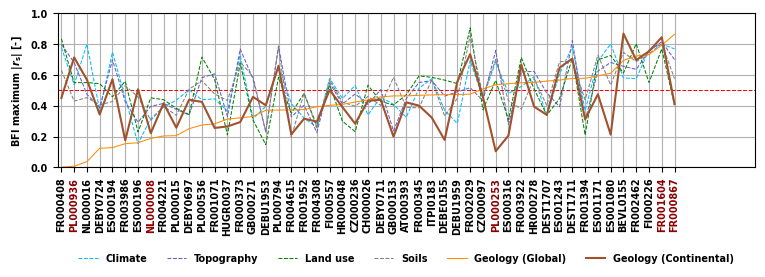

In [12]:
# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
plt.rcParams['font.family'] = 'helvetica'  # Change the font family
plt.rcParams['font.size'] = 7         # Change the font size
plt.rcParams['font.weight'] = 'bold'  # Change font weight (e.g., 'bold', 'normal')
plt.rcParams['axes.labelweight'] = 'bold'  # Change label font weight (e.g., 'bold', 'normal')

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Create subplots with shared x-axis and y-axis
fig, axes = plt.subplots(figsize=(9, 2), sharex=True, sharey=True)

dataframe_BFI_sorted = dataframe_BFI.sort_values(by='geology_global', ascending=True)
#dataframe_BFI_sorted = dataframe_BFI.sort_values(by='geology_continental', ascending=True)


# First subplot (axes[0])
axes.axhline(y=0.5, color='red', linestyle='--', linewidth=0.75)
axes.plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['climate'], label='Climate', color='deepskyblue', linestyle='--', linewidth=0.75)
axes.plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['topography'], label='Topography', color='slateblue', linestyle='--', linewidth=0.75)
axes.plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['landuse'], label='Land use', color='green', linestyle='--', linewidth=0.75)
axes.plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['soils'], label='Soils', color='gray', linestyle='--', linewidth=0.75)
axes.plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['geology_global'], label='Geology (Global)', color='darkorange', linewidth=0.75)
axes.plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['geology_continental'], label='Geology (Continental)', color='sienna')

axes.set_ylim(0, 1)
axes.set_xlim(-0.3, 54.3)
axes.set_ylabel(r'BFI maximum |$r_{\mathregular{s}}$| [-]')

# Rotate x-tick labels for the second subplot and set the last x-tick color to red
axes.tick_params(axis='x', rotation=90)
xticks = axes.get_xticklabels()


xticks[34].set_color('darkred')
xticks[-2].set_color('darkred')
xticks[1].set_color('darkred')
xticks[-1].set_color('darkred')
xticks[7].set_color('darkred')

xticks[34].set_fontweight('bold')
xticks[-2].set_fontweight('bold')
xticks[1].set_fontweight('bold')
xticks[-1].set_fontweight('bold')
xticks[7].set_fontweight('bold')

# Apply modified x-tick labels back to the axis
axes.set_xticklabels(xticks)

# Customize the legend
# Define font properties for bold text
bold_font = FontProperties(weight='bold')

# Create the legend with bold title and labels
axes.legend(
    frameon=False,
    title="",
    title_fontsize='medium',  # Adjust title font size as needed
    loc='upper center',
    bbox_to_anchor=(0.5, -0.5),
    ncol=6,
    prop=bold_font  # Apply bold font to labels
)

# Disable grid for second subplot
axes.grid(True)
axes.grid(True)

# Save and show the plot
plt.savefig(r'results\figs\fig_lineplot_orderedBFI.png', dpi=300, bbox_inches='tight')
plt.show()

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

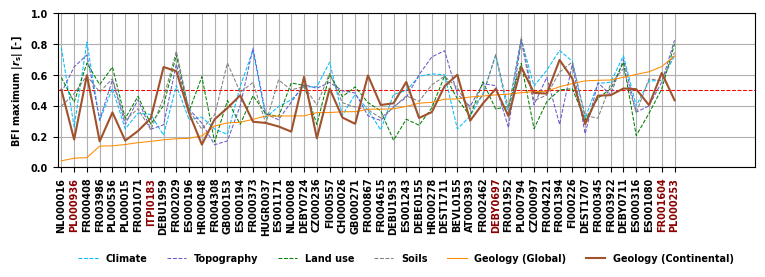

In [13]:
# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
plt.rcParams['font.family'] = 'helvetica'  # Change the font family
plt.rcParams['font.size'] = 7         # Change the font size
plt.rcParams['font.weight'] = 'bold'  # Change font weight (e.g., 'bold', 'normal')
plt.rcParams['axes.labelweight'] = 'bold'  # Change label font weight (e.g., 'bold', 'normal')

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Create subplots with shared x-axis and y-axis
fig, axes = plt.subplots(figsize=(9, 2), sharex=True, sharey=True)

dataframe_other_sorted = dataframe_other.sort_values(by='geology_global', ascending=True)
#dataframe_BFI_sorted = dataframe_BFI.sort_values(by='geology_continental', ascending=True)


# First subplot (axes[0])
axes.axhline(y=0.5, color='red', linestyle='--', linewidth=0.75)
axes.plot(dataframe_other_sorted.index, dataframe_other_sorted['climate'], label='Climate', color='deepskyblue', linestyle='--', linewidth=0.75)
axes.plot(dataframe_other_sorted.index, dataframe_other_sorted['topography'], label='Topography', color='slateblue', linestyle='--', linewidth=0.75)
axes.plot(dataframe_other_sorted.index, dataframe_other_sorted['landuse'], label='Land use', color='green', linestyle='--', linewidth=0.75)
axes.plot(dataframe_other_sorted.index, dataframe_other_sorted['soils'], label='Soils', color='gray', linestyle='--', linewidth=0.75)
axes.plot(dataframe_other_sorted.index, dataframe_other_sorted['geology_global'], label='Geology (Global)', color='darkorange', linewidth=0.75)
axes.plot(dataframe_other_sorted.index, dataframe_other_sorted['geology_continental'], label='Geology (Continental)', color='sienna')

axes.set_ylim(0, 1)
axes.set_xlim(-0.3, 54.3)
axes.set_ylabel(r'BFI maximum |$r_{\mathregular{s}}$| [-]')

# Rotate x-tick labels for the second subplot and set the last x-tick color to red
axes.tick_params(axis='x', rotation=90)
xticks = axes.get_xticklabels()


xticks[34].set_color('darkred')
xticks[-2].set_color('darkred')
xticks[1].set_color('darkred')
xticks[-1].set_color('darkred')
xticks[7].set_color('darkred')

xticks[34].set_fontweight('bold')
xticks[-2].set_fontweight('bold')
xticks[1].set_fontweight('bold')
xticks[-1].set_fontweight('bold')
xticks[7].set_fontweight('bold')

# Apply modified x-tick labels back to the axis
axes.set_xticklabels(xticks)

# Customize the legend
# Define font properties for bold text
bold_font = FontProperties(weight='bold')

# Create the legend with bold title and labels
axes.legend(
    frameon=False,
    title="",
    title_fontsize='medium',  # Adjust title font size as needed
    loc='upper center',
    bbox_to_anchor=(0.5, -0.5),
    ncol=6,
    prop=bold_font  # Apply bold font to labels
)

# Disable grid for second subplot
axes.grid(True)
axes.grid(True)

# Save and show the plot
#plt.savefig(r'results\figs\fig_lineplot_orderedq95.png', dpi=300, bbox_inches='tight')
plt.show()

## Scatter plots

In [14]:
# Catchments used
["PL000936", "ES000665", "DEBU1959", "FR001604", "FR000867"]

['PL000936', 'ES000665', 'DEBU1959', 'FR001604', 'FR000867']

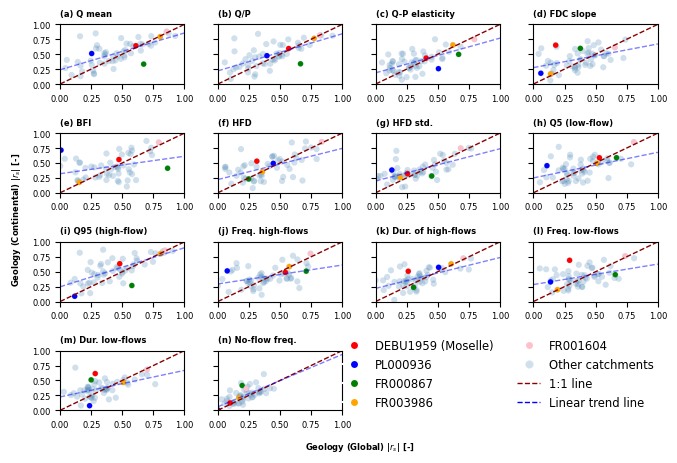

In [12]:
from matplotlib.lines import Line2D

# Set up the figure and subplots layout: 2 rows and 7 columns (14 subplots)
fig, axes = plt.subplots(4, 4, figsize=(7, 5), sharex=False, sharey=True)
n_cols = 4

# Flatten axes for easy iteration
axes = axes.flatten()
# Create custom x labels (adjust based on your data)
custom_x_labels = [
    'Q mean', 'Q/P', 'Q-P elasticity', 'FDC slope', 'BFI', 
    'HFD', 'HFD std.', 'Q5 (low-flow)', 'Q95 (high-flow)',
    'Freq. high-flows', 'Dur. of high-flows', 'Freq. low-flows', 'Dur. low-flows', 'No-flow freq.'
]

# Example data, using only part of the subplots to simulate "empty" ones
num_plots = len(custom_x_labels)  # or fewer if not all will be used

# Iterate over each column and create scatter plots
for i, column in enumerate(corr_low_geology_df_25.T.columns):
    x = corr_low_geology_df_25.T[column]
    y = corr_med_geology_df_25.T[column]
    
    axes[i].plot([0, 1], [0, 1], color='darkred', linestyle='--', linewidth=1)

    # Create scatter plot for each signature
    axes[i].scatter(x, y, color='steelblue', alpha=0.25, s=20, edgecolor='none')
    axes[i].scatter(corr_low_geology_df_25.T[column]["DEBU1959"], corr_med_geology_df_25.T[column]["DEBU1959"], color='red', alpha=1.00, s=15, edgecolor='none')
    axes[i].scatter(corr_low_geology_df_25.T[column]["PL000936"], corr_med_geology_df_25.T[column]["PL000936"], color='blue', alpha=1.00, s=15, edgecolor='none')
    axes[i].scatter(corr_low_geology_df_25.T[column]["FR000867"], corr_med_geology_df_25.T[column]["FR000867"], color='green', alpha=1.00, s=15, edgecolor='none')
    axes[i].scatter(corr_low_geology_df_25.T[column]["FR003986"], corr_med_geology_df_25.T[column]["FR003986"], color='orange', alpha=1.00, s=15, edgecolor='none')
    axes[i].scatter(corr_low_geology_df_25.T[column]["FR001604"], corr_med_geology_df_25.T[column]["FR001604"], color='pink', alpha=1.00, s=15, edgecolor='none')

    # Plot the y=x line
    min_val = min(min(x), min(y))
    max_val = max(max(x), max(y))
    
    # Calculate and plot regression line spanning [0, 1]
    if len(x) > 1:  # Ensure there are enough points for regression
        slope, intercept = np.polyfit(x, y, 1)
        x_range = np.linspace(0, 1, 100)  # Generate x values from 0 to 1
        y_range = slope * x_range + intercept
        axes[i].plot(x_range, y_range, color='blue', linestyle='--', linewidth=1, alpha=0.5)


    # Set title for each subplot
    axes[i].set_title(f"({chr(97 + i)}) {custom_x_labels[i]}", fontsize=6, loc="left", fontweight="bold")
    axes[i].set_xlim(0,1)
    axes[i].set_ylim(0,1)

    # Ensure 0.5 is included in both x and y ticks
    axes[i].set_xticks([0, 0.25, 0.5, 0.75, 1], ['0.00', '0.25', '0.50', '0.75', '1.00'], fontsize=6)
    axes[i].set_yticks([0, 0.25, 0.5, 0.75, 1], ['0.00', '0.25', '0.50', '0.75', '1.00'], fontsize=6)


# Delete any unused subplots
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

# Create custom legend elements
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=6, label='DEBU1959 (Moselle)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=6, label='PL000936'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=6, label='FR000867'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=6, label='FR003986'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='pink', markersize=6, label='FR001604'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markersize=6, label='Other catchments', alpha=0.25),
    Line2D([0], [0], color='darkred', linestyle='--', lw=1, label='1:1 line'),
    Line2D([0], [0], color='blue', linestyle='--', lw=1, label='Linear trend line')
]

# Add the legend with title and font size adjustments
fig.legend(
    handles=legend_elements,
    loc='lower right',
    bbox_to_anchor=(0.975, 0.1),
    ncol=2,
    frameon=False,
    title="",                  # Title for the legend
    title_fontsize='medium',         # Title font size
    fontsize='small'                 # Font size for legend items
)

# Now ensure x-ticks appear in the last row with active subplots (second-to-last row)
#axes[-10].set_xticks([0, 0.25, 0.5, 0.75, 1])    # Example x-tick values; modify as needed
#axes[-10].set_xticklabels(['0', '0.25', '0.5', '0.75', '1'], fontsize=4)  # Set custom labels and font size

# Set common labels
fig.text(0.54, 0.04, "Geology (Global) |$r_s$| [-]", ha='center', fontsize=6, fontweight="bold")
fig.text(0.04, 0.5, "Geology (Continental) |$r_s$| [-]", va='center', rotation='vertical', fontsize=6, fontweight="bold")

# Adjust layout for better readability
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

fig.savefig(r'results\figs\fig_scatterplots_b.png', dpi=300, bbox_inches='tight')


plt.show()

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

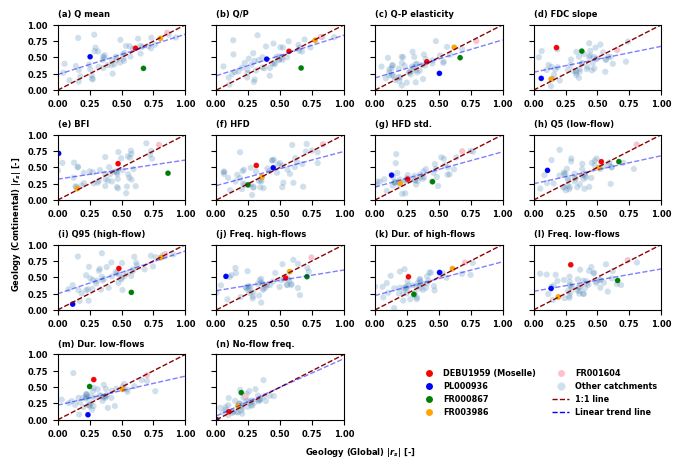

In [34]:
from matplotlib.lines import Line2D

# Set up the figure and subplots layout: 2 rows and 7 columns (14 subplots)
fig, axes = plt.subplots(4, 4, figsize=(7, 5), sharex=False, sharey=True)
n_cols = 4

# Flatten axes for easy iteration
axes = axes.flatten()
# Create custom x labels (adjust based on your data)
custom_x_labels = [
    'Q mean', 'Q/P', 'Q-P elasticity', 'FDC slope', 'BFI', 
    'HFD', 'HFD std.', 'Q5 (low-flow)', 'Q95 (high-flow)',
    'Freq. high-flows', 'Dur. of high-flows', 'Freq. low-flows', 'Dur. low-flows', 'No-flow freq.'
]

# Example data, using only part of the subplots to simulate "empty" ones
num_plots = len(custom_x_labels)  # or fewer if not all will be used

# Iterate over each column and create scatter plots
for i, column in enumerate(corr_low_geology_df_25.T.columns):
    x = corr_low_geology_df_25.T[column]
    y = corr_med_geology_df_25.T[column]
    
    axes[i].plot([0, 1], [0, 1], color='darkred', linestyle='--', linewidth=1)

    # Create scatter plot for each signature
    axes[i].scatter(x, y, color='steelblue', alpha=0.25, s=20, edgecolor='none')
    axes[i].scatter(corr_low_geology_df_25.T[column]["DEBU1959"], corr_med_geology_df_25.T[column]["DEBU1959"], color='red', alpha=1.00, s=15, edgecolor='none')
    axes[i].scatter(corr_low_geology_df_25.T[column]["PL000936"], corr_med_geology_df_25.T[column]["PL000936"], color='blue', alpha=1.00, s=15, edgecolor='none')
    axes[i].scatter(corr_low_geology_df_25.T[column]["FR000867"], corr_med_geology_df_25.T[column]["FR000867"], color='green', alpha=1.00, s=15, edgecolor='none')
    axes[i].scatter(corr_low_geology_df_25.T[column]["FR003986"], corr_med_geology_df_25.T[column]["FR003986"], color='orange', alpha=1.00, s=15, edgecolor='none')
    axes[i].scatter(corr_low_geology_df_25.T[column]["FR001604"], corr_med_geology_df_25.T[column]["FR001604"], color='pink', alpha=1.00, s=15, edgecolor='none')

    # Plot the y=x line
    min_val = min(min(x), min(y))
    max_val = max(max(x), max(y))
    
    # Calculate and plot regression line spanning [0, 1]
    if len(x) > 1:  # Ensure there are enough points for regression
        slope, intercept = np.polyfit(x, y, 1)
        x_range = np.linspace(0, 1, 100)  # Generate x values from 0 to 1
        y_range = slope * x_range + intercept
        axes[i].plot(x_range, y_range, color='blue', linestyle='--', linewidth=1, alpha=0.5)


    # Set title for each subplot
    axes[i].set_title(f"({chr(97 + i)}) {custom_x_labels[i]}", fontsize=6, loc="left", fontweight="bold")
    axes[i].set_xlim(0,1)
    axes[i].set_ylim(0,1)

    # Ensure 0.5 is included in both x and y ticks
    axes[i].set_xticks([0, 0.25, 0.5, 0.75, 1], ['0.00', '0.25', '0.50', '0.75', '1.00'], fontsize=6)
    axes[i].set_yticks([0, 0.25, 0.5, 0.75, 1], ['0.00', '0.25', '0.50', '0.75', '1.00'], fontsize=6)


# Delete any unused subplots
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

# Create custom legend elements
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=6, label='DEBU1959 (Moselle)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=6, label='PL000936'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=6, label='FR000867'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=6, label='FR003986'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='pink', markersize=6, label='FR001604'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markersize=6, label='Other catchments', alpha=0.25),
    Line2D([0], [0], color='darkred', linestyle='--', lw=1, label='1:1 line'),
    Line2D([0], [0], color='blue', linestyle='--', lw=1, label='Linear trend line')
]

# Add the legend with title and font size adjustments
fig.legend(
    handles=legend_elements,
    loc='lower right',
    bbox_to_anchor=(0.975, 0.1),
    ncol=2,
    frameon=False,
    title="",                  # Title for the legend
    title_fontsize='medium',         # Title font size
    fontsize='small'                 # Font size for legend items
)

# Now ensure x-ticks appear in the last row with active subplots (second-to-last row)
#axes[-10].set_xticks([0, 0.25, 0.5, 0.75, 1])    # Example x-tick values; modify as needed
#axes[-10].set_xticklabels(['0', '0.25', '0.5', '0.75', '1'], fontsize=4)  # Set custom labels and font size

# Set common labels
fig.text(0.54, 0.04, "Geology (Global) |$r_s$| [-]", ha='center', fontsize=6, fontweight="bold")
fig.text(0.04, 0.5, "Geology (Continental) |$r_s$| [-]", va='center', rotation='vertical', fontsize=6, fontweight="bold")

# Adjust layout for better readability
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

fig.savefig(r'results\figs\fig_scatterplots_b.png', dpi=300, bbox_inches='tight')


plt.show()

# Make some evaluation counting the values

In [97]:
corr_med_geology_df_25_diff = corr_med_geology_df_25 - corr_low_geology_df_25

corr_med_geology_df_25_diff

ES000665  ES001243  ES000196  ES000194  ES001080  \
q_mean                    -0.177099  0.307948  0.562610  0.639592  0.353888   
q_runoff_ratio            -0.196627  0.276430  0.517341  0.632258  0.413567   
q_elas_Sankarasubramanian -0.003454  0.162310  0.286469  0.244090 -0.015744   
slope_sawicz              -0.074324  0.158858  0.163294  0.175109 -0.216566   
baseflow_index             0.058006  0.080791  0.346742  0.444049 -0.398253   
hfd_mean                   0.246909  0.083173  0.545673  0.043211 -0.340554   
hfd_std                   -0.012625  0.057849  0.535187  0.120064 -0.049697   
q_5                       -0.045646  0.297261  0.565184  0.341946 -0.356861   
q_95                      -0.027071  0.300115  0.521620  0.659254  0.274951   
hq_freq                    0.074646  0.103862  0.492087  0.413952  0.410544   
hq_dur                     0.127471  0.036740  0.318988  0.399620  0.106637   
lq_freq                    0.001343  0.164105  0.437963  0.226569 -0.182832   
lq_dur                     0.172933 -0.004603  0.592617 -0.010323  0.125216   
zero_q_freq                0.066775  0.236731  0.156736 -0.040700  0.128520   

                           ES000316  GB000472  GB000271  GB000153  ITTO0361  \
q_mean                     0.160987  0.158281 -0.032094  0.060043  0.278766   
q_runoff_ratio             0.229217  0.182144 -0.018408 -0.033906  0.265699   
q_elas_Sankarasubramanian  0.078535  0.272664 -0.059005 -0.205461  0.293722   
slope_sawicz              -0.095999  0.073409 -0.078655  0.096564  0.270204   
baseflow_index            -0.336090  0.181531  0.127232 -0.264331  0.347009   
hfd_mean                   0.170148  0.248389  0.224937 -0.099573  0.222675   
hfd_std                    0.401346  0.081187 -0.012470 -0.044877 -0.034476   
q_5                        0.142472  0.172359 -0.145087 -0.033031  0.172177   
q_95                       0.160501  0.213121 -0.034695  0.060022  0.305131   
hq_freq                   -0.302437  0.064898  0.007771 -0.173698  0.339743   
hq_dur                     0.120926 -0.168367 -0.096378 -0.061310  0.027375   
lq_freq                   -0.256259  0.250957 -0.096420 -0.135627  0.213146   
lq_dur                     0.029970 -0.083821 -0.076376 -0.115030  0.020102   
zero_q_freq               -0.015368  0.045652 -0.058694  0.000000  0.269790   

                           ...  HR000278  CZ000236  DEST1707  DEBE0155  \
q_mean                     ... -0.088585 -0.071317 -0.088834 -0.054101   
q_runoff_ratio             ... -0.047426 -0.035887 -0.080302 -0.053627   
q_elas_Sankarasubramanian  ...  0.003186  0.073157 -0.002653  0.011700   
slope_sawicz               ... -0.063746 -0.166101 -0.280297 -0.095991   
baseflow_index             ... -0.157092 -0.140628 -0.219758 -0.293886   
hfd_mean                   ... -0.318678 -0.202478 -0.090870 -0.030928   
hfd_std                    ... -0.163890  0.081616  0.062710 -0.280400   
q_5                        ... -0.047571  0.020761 -0.069594 -0.016523   
q_95                       ... -0.081152 -0.031177 -0.060460 -0.055738   
hq_freq                    ... -0.122982 -0.114255 -0.144442 -0.166483   
hq_dur                     ...  0.020951  0.109408  0.073844 -0.069906   
lq_freq                    ... -0.065858  0.019979 -0.299932 -0.070126   
lq_dur                     ... -0.019629 -0.007541  0.172699 -0.118545   
zero_q_freq                ...  0.142437 -0.021452  0.000000 -0.088678   

                           FR002758  FR002462  FR001394  FR000867  FR004308  \
q_mean                    -0.016258 -0.108535 -0.067412 -0.338295 -0.035161   
q_runoff_ratio            -0.009161 -0.168823 -0.083331 -0.325186 -0.013928   
q_elas_Sankarasubramanian -0.117944 -0.046907 -0.052896 -0.170160 -0.053242   
slope_sawicz               0.005123 -0.048378  0.174370  0.219790  0.043817   
baseflow_index            -0.105244 -0.026621 -0.265781 -0.453476 -0.096673   
hfd_mean                  -0.110025 -0.061363 -0.123574 -0.016012 -0.2

In [98]:
# Count positive values in each row
positive_counts = corr_med_geology_df_25_diff.apply(lambda row: (row >= -0.0).sum(), axis=1)

# Add the counts as a new column, if desired
corr_med_geology_df_25_diff['positive_count'] = positive_counts/55

In [99]:
corr_med_geology_df_25_diff["positive_count"]

q_mean                       0.600000
q_runoff_ratio               0.527273
q_elas_Sankarasubramanian    0.636364
slope_sawicz                 0.563636
baseflow_index               0.527273
hfd_mean                     0.563636
hfd_std                      0.618182
q_5                          0.509091
q_95                         0.690909
hq_freq                      0.509091
hq_dur                       0.672727
lq_freq                      0.509091
lq_dur                       0.509091
zero_q_freq                  0.618182
Name: positive_count, dtype: float64

In [100]:
# Count values above 0.05 in each row
positive_counts = corr_med_geology_df_25_diff.apply(lambda row: (row > 0.05).sum(), axis=1)

# Count values that are either above 0.05 or below -0.05 in each row
total_count = corr_med_geology_df_25_diff.apply(lambda row: ((row > 0.05) | (row < -0.05)).sum(), axis=1)

# Calculate the final count by dividing positive counts by the adjusted total count
corr_med_geology_df_25_diff['adjusted_positive_ratio'] = positive_counts / total_count

corr_med_geology_df_25_diff['adjusted_positive_ratio']

q_mean                       0.685714
q_runoff_ratio               0.714286
q_elas_Sankarasubramanian    0.684211
slope_sawicz                 0.585366
baseflow_index               0.590909
hfd_mean                     0.564103
hfd_std                      0.717949
q_5                          0.600000
q_95                         0.780488
hq_freq                      0.555556
hq_dur                       0.666667
lq_freq                      0.534884
lq_dur                       0.621622
zero_q_freq                  0.703704
Name: adjusted_positive_ratio, dtype: float64

# Individual tests

100%|██████████| 1/1 [00:00<00:00, 263.35it/s]


            len
DEBU1959  152.0


100%|██████████| 14/14 [00:00<00:00, 36.72it/s]


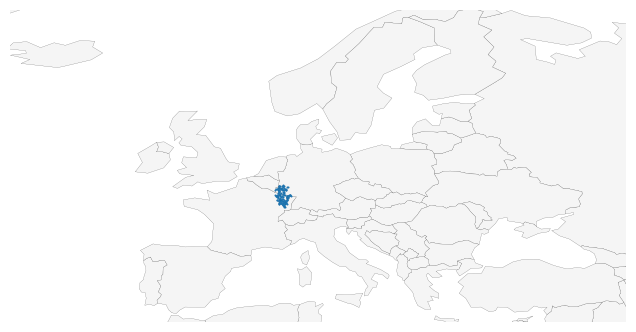

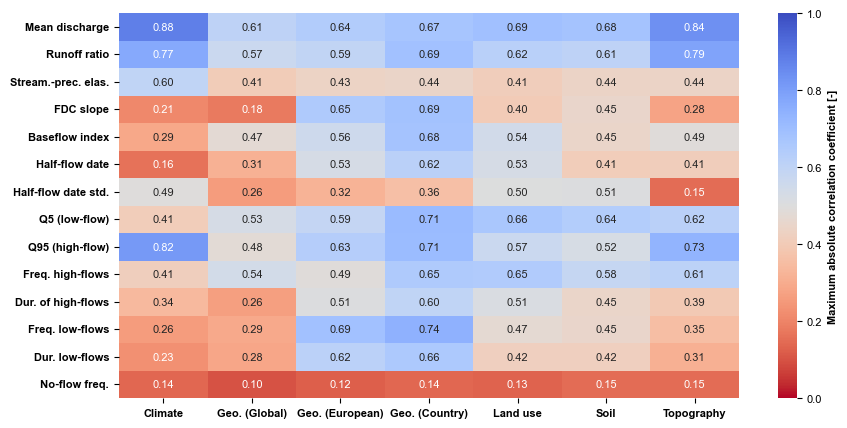

In [101]:
# Here we filter the list of nested_catchments according to this first filter:
list_cats = ["DEBU1959"]

nested_cats_df = nested_catchments.loc[list_cats, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 
# Filter only the catchemnts using the function stated before:
nested_cats_filtered = find_max_unique_rows(nested_cats_df)

# Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]


# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip



# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)


# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]
print(nested_cats_filtered_abovevalue)


# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Create subplots
fig, axes = plt.subplots()
# Flatten the axes array

plot_watershed_groups_from_dict(estreams_attributes_used = estreams_attributes_dfs, figsize=(8, 6), ax=axes, 
                      title_plot='', limits_europe = True)


estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date >= "2009"]


# Store the correlation matrices for selected catchments in a dictionary:
# Initialize an empty dictionary to store correlation DataFrames for the selected variables
correlation_dict = {}

# Iterate over each variable in the first 14 columns of your data
for variable in tqdm.tqdm(estreams_attributes.columns[29:43]):
    # Initialize an empty DataFrame to store correlations
    correlation_df = pd.DataFrame()

    # Iterate over each watershed group
    for catchment in estreams_attributes_dfs.keys():

        estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date > "2009"]
        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

        "perm_high_glob", "perm_medium_glob", "perm_low_glob", "perm_verylow_glob", 
        "perm_high_cont", "perm_medium_cont", "perm_low_cont", "perm_verylow_cont",
        "perm_high_regi", "perm_medium_regi", "perm_low_regi", "perm_verylow_regi",
       
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]]
        
        # Calculate correlations between the current variable and other variables
        correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
        
        # Add the correlations to the DataFrame
        correlation_df[catchment] = correlations

    # Add the correlation DataFrame to the dictionary
    correlation_dict[variable] = correlation_df

# Assuming correlation_dict is a dictionary containing all correlation DataFrames
# Initialize an empty list to store individual correlation DataFrames
correlation_list = []

# Iterate over all keys in the dictionary and append their DataFrame to the list with an added 'signature' column
for signature in correlation_dict.keys():
    corr_df = correlation_dict[signature].T
    corr_df['signature'] = signature  # Add a column to identify the signature
    correlation_list.append(corr_df)

# Concatenate all correlation DataFrames along the rows
combined_correlation_df = pd.concat(correlation_list)

# Preserve the order of the signatures by converting to categorical type
combined_correlation_df['signature'] = pd.Categorical(
    combined_correlation_df['signature'],
    categories=list(correlation_dict.keys()),
    ordered=True
)

# Set the signature column as the index
combined_correlation_df.set_index('signature', inplace=True)

# Customize row names (for demonstration purposes, modify as needed)
#custom_row_names = ['Row ' + str(i) for i in range(1, len(combined_correlation_df.index) + 1)]
#combined_correlation_df.index = custom_row_names

# Plot the combined heatmap
#plt.figure(figsize=(20, 16))
#sns.heatmap(combined_correlation_df, annot=False, cmap='coolwarm', fmt=".1f", vmin=-1, vmax=1, 
#            cbar_kws={'label': 'Correlation Coefficient'}, 
#            yticklabels=combined_correlation_df.index)
#
##plt.title('Combined Heatmap for All Signatures', fontsize=20)
##plt.xlabel('Variables', fontsize=15)
#plt.ylabel('', fontsize=15)

## Customize font sizes
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#
#plt.show()


# Group the variable features to groups
# Here we can use a dictionary to reclassifiy the variables we have to groups such as: climate, soil, geolofy
variable_dict = {
        'p_mean': 'climatic',
        'pet_mean': 'climatic',
        'aridity': 'climatic',
        'p_seasonality': 'climatic',
        'frac_snow': 'climatic',
        'hp_freq': 'climatic',
        'hp_dur': 'climatic',
        'hp_time': 'climatic',
        'lp_freq': 'climatic',
        'lp_dur': 'climatic',
        'lp_time': 'climatic',
        'ele_mt_max': 'topography',
        'ele_mt_mean': 'topography',
        'ele_mt_min': 'topography',
        'slp_dg_mean': 'topography',
        'flat_area_fra': 'topography',
        'steep_area_fra': 'topography',
        'elon_ratio': 'topography',
        'strm_dens': 'topography',
        'lit_dom': 'geology',
        'bedrk_dep': 'soil',

        'perm_verylow_glob': 'geology_low',
        'perm_low_glob': 'geology_low',
        'perm_medium_glob': 'geology_low',
        'perm_high_glob': 'geology_low',

        'root_dep_mean': 'soil',
        'root_dep_max': 'soil',
        'root_dep_min': 'soil',
        'soil_tawc_mean': 'soil',
        'soil_fra_sand_mean': 'soil',
        'soil_fra_silt_mean': 'soil',
        'soil_fra_clay_mean': 'soil',
        'soil_fra_grav_mean': 'soil',
        'soil_bd_mean': 'soil',
        'soil_oc_mean': 'soil',
        'lai_mean': 'lulc',
        'ndvi_mean': 'lulc',
        'lulc_2006_urban': 'lulc',
        'lulc_2006_NonIrriAgri': 'lulc',
        'lulc_2006_Agric': 'lulc',
        'lulc_2006_forest': 'lulc',
        'lulc_2006_grass': 'lulc',
        'lulc_2006_agriculture': 'lulc',
        'dam_num': 'hydrology',
        'res_num': 'hydrology',
        'lakes_num': 'hydrology',
        'sno_cov_mean': 'climatic',
        'irri_1990': 'hydrology',
        'irri_2005': 'hydrology',

        'perm_high_cont': 'geology_med',
        'perm_medium_cont': 'geology_med',
        'perm_low_cont': 'geology_med',
        'perm_verylow_cont': 'geology_med',

        'stations_num_p_mean': 'climatic',

        'perm_high_regi': "geology_high", 
        'perm_medium_regi': "geology_high", 
        'perm_low_regi': "geology_high",
        'perm_verylow_regi': "geology_high",
        "area_estreams": "topography"
    }


# Select the variable
signatures = ['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 
              'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq']


# Define the classes (example list, adjust based on your classes)
classes = ["climatic", "geology", "geology_low", "lulc", "soil", "topography", "vegetation", "hydrology", "geology_med", "geology_high"]

corr_max_group_dfs = pd.DataFrame(columns = signatures)

for signature in signatures:
    correlation_df = correlation_dict[signature]
    
    # Initialize the dataframe with columns for each class's maximum correlation and feature
    columns = []
    for cls in classes:
        columns.append(f"corr_max_{cls}")
        columns.append(f"corr_max_feature_{cls}")

    corr_max_group_df = pd.DataFrame(index=correlation_df.columns, columns=columns)

    # Populate the dataframe with the maximum correlations for each class
    for catchment in correlation_df.columns:
        max_corr = {cls: 0 for cls in classes}
        max_feature = {cls: None for cls in classes}

        for feature in correlation_df.index:
            cls = variable_dict[feature]
            corr_value = abs(correlation_df.loc[feature, catchment])

            if corr_value > abs(max_corr[cls]):
                max_corr[cls] = correlation_df.loc[feature, catchment]
                max_feature[cls] = feature

        for cls in classes:
            corr_max_group_df.loc[catchment, f"corr_max_{cls}"] = max_corr[cls]
            corr_max_group_df.loc[catchment, f"corr_max_feature_{cls}"] = max_feature[cls]

    # Reclassify geological classes using the mapping dictionary for each class's feature
    for cls in classes:
        corr_max_group_df[f"corr_max_feature_{cls}"] = corr_max_group_df[f"corr_max_feature_{cls}"].map(variable_dict)

    corr_max_group_df = corr_max_group_df[['corr_max_climatic', 'corr_max_geology_low', "corr_max_geology_med", "corr_max_geology_high",
                                                      'corr_max_lulc', 'corr_max_soil', 'corr_max_topography', 
                                                      'corr_max_vegetation', 'corr_max_hydrology']]

    # Sort and add additional columns
    corr_max_group_df.iloc[:, 0:7] = corr_max_group_df.iloc[:, 0:7].astype(float)
    corr_max_group_df = corr_max_group_df.astype(float)
    corr_max_group_df = corr_max_group_df.T.iloc[0:-2]
    corr_max_group_dfs[signature] = corr_max_group_df


import matplotlib.pyplot as plt
import seaborn as sns

# Assuming corr_max_group_dfs is your DataFrame and it already contains the required data
# Create custom x labels
custom_x_labels = ["Climate", "Geo. (Global)", "Geo. (European)", "Geo. (Country)", "Land use", 
                   "Soil", "Topography"]  # Replace with your labels
# Create custom y labels (adjust based on your data)
custom_y_labels = ['Mean discharge', 'Runoff ratio','Stream.-prec. elas.','FDC slope','Baseflow index','Half-flow date','Half-flow date std.', 
                   'Q5 (low-flow)', 'Q95 (high-flow)','Freq. high-flows', 'Dur. of high-flows', 'Freq. low-flows', 'Dur. low-flows', 'No-flow freq.']

corr_max_group_dfs_abs = corr_max_group_dfs.abs()
# Plot the heatmap
plt.figure(figsize=(10, 5))
ax = sns.heatmap(corr_max_group_dfs_abs.T, annot=True, cmap='coolwarm_r', fmt=".2f", vmin=0, vmax=1, alpha=1)

# Set custom x labels
ax.set_xticklabels(custom_x_labels, rotation=0, ha='center', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed
# Set custom y labels
ax.set_yticklabels(custom_y_labels, rotation=0, ha='right', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed

# Customize the legend label
colorbar = ax.collections[0].colorbar
colorbar.set_label('Maximum absolute correlation coefficient [-]', fontsize=8, fontweight='bold')

#plt.title(f'Heatmap for {signature}')
#plt.savefig(r'results\figs\fig_paper_heatmap.png', dpi=300, bbox_inches='tight')

plt.show()



In [102]:
correlation_dict["baseflow_index"].loc[["perm_high_glob", "perm_medium_glob", "perm_low_glob", "perm_verylow_glob", 
            "perm_high_cont", "perm_medium_cont", "perm_low_cont", "perm_verylow_cont",
            "perm_high_regi", "perm_medium_regi", "perm_low_regi", "perm_verylow_regi"]]

DEBU1959
perm_high_glob     0.473061
perm_medium_glob  -0.448081
perm_low_glob      0.200780
perm_verylow_glob  0.287463
perm_high_cont     0.557096
perm_medium_cont  -0.223361
perm_low_cont      0.339365
perm_verylow_cont -0.095056
perm_high_regi     0.680013
perm_medium_regi  -0.246993
perm_low_regi     -0.298355
perm_verylow_regi -0.011665

In [103]:
df = estreams_attributes_dfs[catchment]
#df = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date >= "2009"]


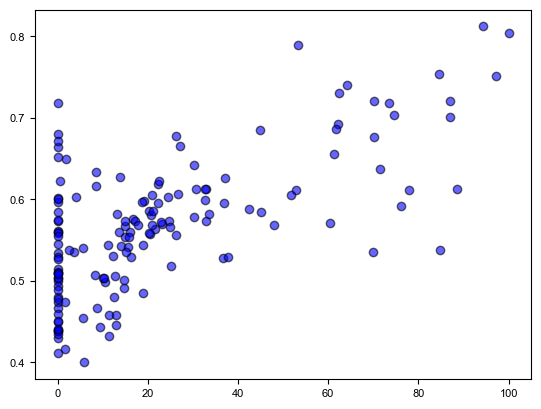

In [104]:
plt.scatter(df['perm_high_cont'], df['baseflow_index'], color='blue', alpha=0.6, edgecolor='black')


# Plot some maps

### Read the maps

In [16]:
# Global geology map
GLiM = gpd.read_file("../estreams_part_b/data/lithology/GLiM.shp")

attribute_field = 'xx'
GLiM_dissolved = GLiM.dissolve(by=attribute_field)

# Now we create a new feature with the geology class:
GLiM_dissolved["class"] = GLiM_dissolved.index

# Reproject the map
print("CRS of GLiM:", GLiM_dissolved.crs)
GLiM_reprojected = GLiM_dissolved.to_crs("EPSG:4326")

CRS of GLiM: PROJCS["World_Eckert_IV",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Eckert_IV"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","54012"]]


In [17]:
# Continental geology map
IHME = gpd.read_file("../estreams_part_b/data/lithology/ihme1500_litho12345_ec4060_v12_poly.shp")

# Check for and fix invalid geometries
if not IHME.geometry.is_valid.all():
    IHME.geometry = IHME.geometry.buffer(0)

attribute_field = 'LEVEL3'
IHME_dissolved = IHME.dissolve(by=attribute_field)

## Now we create a new feature with the lithology class:
IHME_dissolved["class"] = IHME_dissolved.index

# Reproject the map
print("CRS of GLiM:", IHME_dissolved.crs)
IHME_reprojected = IHME_dissolved.to_crs("EPSG:4326")

CRS of GLiM: epsg:3035


### Make the plots

In [ ]:
#catchment_ids = ["PL000936", "FR000867", "DEBU1959", "ES000665", "FR001604"]

rivers_fivesubs = gpd.read_file(r'data\rivers\rivers_merit_five_subs_dissolved.shp')

In [18]:
from shapely.geometry import Point
import pandas as pd

# Assuming network_estreams_filtered is your DataFrame with lat and lon columns
# Create a GeoDataFrame from network_estreams_filtered
geometry = [Point(xy) for xy in zip(network_estreams['lon'], network_estreams['lat'])]
network_estreams_gdf = gpd.GeoDataFrame(network_estreams, geometry=geometry, crs='EPSG:4326')

In [19]:
# Define the function for the plots
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Function to plot a single catchment
def plot_catchment(ax, catchment_id, catchment_boundaries, GLiM_reprojected, color_mapping_glim, network_estreams_gdf, i):
    # Select the catchment geometry
    selected_geometry = catchment_boundaries.set_index("basin_id", inplace=False).loc[[catchment_id], "geometry"]
    
    # Create a GeoDataFrame from the selected geometries and set the CRS directly
    selected_gdf = gpd.GeoDataFrame({'geometry': selected_geometry}, crs='EPSG:4326')
    
    # Add a column for colors based on the class
    GLiM_reprojected['color'] = GLiM_reprojected['class'].map(color_mapping_glim)

    # Set plot limits to the bounding box of the selected study areas
    bounds = selected_gdf.total_bounds
    x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

    # Create a mask that covers the entire plotting area
    plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
    mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

    # Combine the selected geometries into one
    combined_geometry = selected_gdf.unary_union

    # Create the mask by subtracting the combined geometry from the plot extent
    mask['geometry'] = mask.difference(combined_geometry)

    # Plot the geology shapefile with different colors for each class
    GLiM_reprojected.plot(column='class', ax=ax, legend=False, 
                          categorical=True, color=GLiM_reprojected['color'], edgecolor='none', linewidth=0, alpha=0.5)

    # Overlay the study area boundaries
    selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, label='')

    # Plot the points from network_estreams_filtered
    network_estreams_gdf.plot(ax=ax, color='black', markersize=5, edgecolor='none', linewidth=0.5, 
                              label='Measurement Points')

    # Plot the mask to cover everything outside the study area
    mask.plot(ax=ax, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

    # Set plot limits to the bounding box of the study area
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_axis_off()  # Turn off both x-axis and y-axis
    ax.set_aspect('equal')
    
    # Set plot title and labels
    #ax.set_title(f'({chr(97 + i)}) {catchment_id}', fontsize="8", y=1.05, loc="left")
    ax.set_xlabel('')
    ax.set_ylabel('')

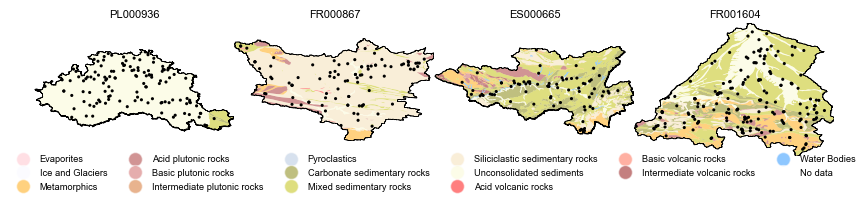

In [133]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'ev': "pink",  # Evaporites
    'ig': "ghostwhite",  # Ice and Glaciers
    'mt': "orange",  # Metamorphics
    'pa': "brown",  # Acid plutonic rocks
    'pb': "indianred",  # Basic plutonic rocks
    'pi': "chocolate",  # Intermediate plutonic rocks
    'py': "lightsteelblue",  # Pyroclastics
    'sc': "olive",  # Carbonate sedimentary rocks
    'sm': "y",  # Mixed sedimentary rocks
    'ss': "#F5DEB3",  # Siliciclastic sedimentary rocks
    'su': "#FAFAD2",  # Unconsolidated sediments
    'va': "red",  # Acid volcanic rocks
    'vb': "tomato",  # Basic volcanic rocks
    'vi': "darkred",  # Intermediate volcanic rocks
    'wb': "#1E90FF",  # Water Bodies
    'nd': "white"   # Precambrian rocks
}

# Define color mappings for legend
color_mapping_glim_legend = {
    'Evaporites': "pink",
    'Ice and Glaciers': "ghostwhite",
    'Metamorphics': "orange",
    'Acid plutonic rocks': "brown",
    'Basic plutonic rocks': "indianred",
    'Intermediate plutonic rocks': "chocolate",
    'Pyroclastics': "lightsteelblue",
    'Carbonate sedimentary rocks': "olive",
    'Mixed sedimentary rocks': "y",
    'Siliciclastic sedimentary rocks': "#F5DEB3",
    'Unconsolidated sediments': "#FAFAD2",
    'Acid volcanic rocks': "red",
    'Basic volcanic rocks': "tomato",
    'Intermediate volcanic rocks': "darkred",
    'Water Bodies': "#1E90FF",
    'No data': "white"
}

# Define catchment IDs and layout
#catchment_ids = ["FR001604", "PL000936", "FR000867", "FR000373", "DEBU1959"]
catchment_ids = ["PL000936", "ES000665", "DEBU1959", "FR001604", "FR000867"]
catchment_ids = ["PL000936", "FR000867", "FR003986", "FR001604"]
catchment_ids = ["PL000936", "FR000867", "ES000665", "FR001604"]

# Define the figure size for each subplot (width, height) in inches
subplot_width = 2
subplot_height = 2  # half of the previous height for 2 rows

# Number of columns and rows for subplots
n_cols = 4
n_rows = (len(catchment_ids) + n_cols - 1) // n_cols  # to ensure all catchments are plotted


# Create figure and subplots
#fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2), constrained_layout=True)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(subplot_width * n_cols, subplot_height * n_rows))


axes = axes.flatten()

j = 0
# Plot each catchment in subplots
for ax, catchment_id in zip(axes, catchment_ids):
    plot_catchment(ax, catchment_id, catchment_boundaries, GLiM_reprojected, color_mapping_glim, network_estreams_gdf, j)
    j = j + 1

# Hide any empty subplots
for i in range(len(catchment_ids), len(axes)):
    fig.delaxes(axes[i])

# Create legend elements
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label, alpha=0.5)
                   for label, color in color_mapping_glim_legend.items()]

# Add legend outside plot area at the bottom center
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=6, frameon=False, fontsize='small', title='')

# Add catchment labels to the figure, aligning them above each subplot
for i, catchment_id in enumerate(catchment_ids):
    # Position relative to each subplot area
    fig.text(0.125 + i % n_cols * 1 / n_cols, 0.875 - i // n_cols * 1 / n_rows, f'{catchment_id}',
             ha='center', va='center', fontsize=8, fontweight='normal')
    

# Adjust layout and display
plt.tight_layout(pad=0)

fig.savefig(r'results\figs\fig_geologies_a.png', dpi=300, bbox_inches='tight')


plt.show()


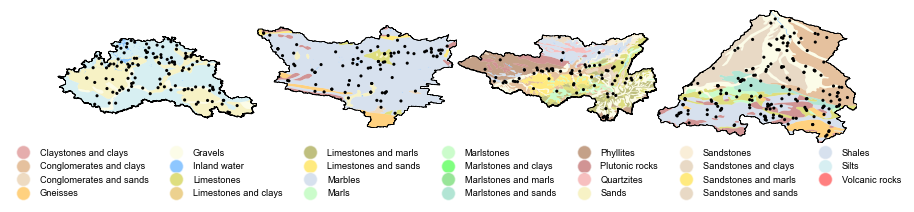

In [134]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd

# Extended color mapping for geology_median_dissolved
color_mapping_geology = {
    'Claystones and clays': 'indianred',             # Same as existing
    'Clays': '#CD5C5C',                              # Similar to Claystones and clays
    'Conglomerates': '#D2B48C',                      # Tan, close to Gravels
    'Conglomerates and clays': '#CD853F',            # Peru, slightly darker to indicate mixture
    'Conglomerates and sands': '#DEB887',            # Burlywood, close to Sands
    'Gneisses': 'orange',                            # Same as existing
    'Gravels': '#FAFAD2',                            # Same as existing
    'Inland water': '#1E90FF',                       # Same as existing
    'Limestones': 'y',                               # Same as existing
    'Limestones and clays': '#DAA520',               # Goldenrod, close to Limestones
    'Limestones and marls': 'olive',                 # Same as existing
    'Limestones and sands': '#FFD700',               # Gold, close to Limestones
    'Marbles': '#B0C4DE',                            # LightSteelBlue, similar to Quartzites but distinct
    'Marls': '#98FB98',                              # Pale Green, distinct but related to marlstones
    'Marlstones': 'palegreen',                       # Same as existing
    'Marlstones and clays': 'lime',                  # Same as existing
    'Marlstones and marls': '#32CD32',               # Same as existing
    'Marlstones and sands': '#66CDAA',               # Medium Aquamarine, slightly related to Marl
    'Phyllites': '#8B4513',                          # SaddleBrown, similar to Plutonic rocks
    'Plutonic rocks': 'brown',                       # Same as existing
    'Quartzites': 'lightcoral',                      # Same as existing
    'Sands': 'khaki',                                # Same as existing
    'Sandstones': '#F5DEB3',                         # Same as existing
    'Sandstones and clays': '#D2B48C',               # Tan, slightly darker as mixture
    'Sandstones and marls': 'gold',                  # Same as existing
    'Sandstones and sands': 'tan',                   # Same as existing
    'Schists': '#778899',                            # LightSlateGray, similar to Shales
    'Shales': 'lightsteelblue',                      # Same as existing
    'Silts': '#B0E0E6',                              # PowderBlue, similar to clays but softer
    'Snow field / ice field': '#F8F8FF',             # GhostWhite, indicating a cold area
    'Volcanic rocks': 'red'                          # Same as existing
}

color_mapping_geology_legend = {
    'Claystones and clays': 'indianred',
    #'Clays': '#CD5C5C',
    #'Conglomerates': '#D2B48C',
    'Conglomerates and clays': '#CD853F',
    'Conglomerates and sands': '#DEB887',
    'Gneisses': 'orange',
    'Gravels': '#FAFAD2',
    'Inland water': '#1E90FF',
    'Limestones': 'y',
    'Limestones and clays': '#DAA520',
    'Limestones and marls': 'olive',
    'Limestones and sands': '#FFD700',
    'Marbles': '#B0C4DE',
    'Marls': '#98FB98',
    'Marlstones': 'palegreen',
    'Marlstones and clays': 'lime',
    'Marlstones and marls': '#32CD32',
    'Marlstones and sands': '#66CDAA',
    'Phyllites': '#8B4513',
    'Plutonic rocks': 'brown',
    'Quartzites': 'lightcoral',
    'Sands': 'khaki',
    'Sandstones': '#F5DEB3',
    'Sandstones and clays': '#D2B48C',
    'Sandstones and marls': 'gold',
    'Sandstones and sands': 'tan',
    #'Schists': '#778899',
    'Shales': 'lightsteelblue',
    'Silts': '#B0E0E6',
    #'Snow field / ice field': '#F8F8FF',
    'Volcanic rocks': 'red'
}

# Define catchment IDs and layout
#catchment_ids = ["FR001604", "PL000936", "FR000867", "FR000373", "DEBU1959"]
catchment_ids = ["PL000936", "ES000665", "DEBU1959", "FR001604", "FR000867"]
catchment_ids = ["PL000936", "ES000665", "FR001604", "FR000867"]
catchment_ids = ["PL000936", "FR000867", "FR003986", "FR001604"]
catchment_ids = ["PL000936", "FR000867", "ES000665", "FR001604"]

# Define the figure size for each subplot (width, height) in inches
subplot_width = 2
subplot_height = 2  # half of the previous height for 2 rows

# Number of columns and rows for subplots
n_cols = 4
n_rows = (len(catchment_ids) + n_cols - 1) // n_cols  # to ensure all catchments are plotted


# Create figure and subplots
#fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2), constrained_layout=True)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(subplot_width * n_cols, subplot_height * n_rows))


axes = axes.flatten()

j = 0
# Plot each catchment in subplots
for ax, catchment_id in zip(axes, catchment_ids):
    plot_catchment(ax, catchment_id, catchment_boundaries, IHME_reprojected, color_mapping_geology, network_estreams_gdf, j)
    j = j + 1

# Hide any empty subplots
for i in range(len(catchment_ids), len(axes)):
    fig.delaxes(axes[i])

# Create legend elements
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label, alpha=0.5)
                   for label, color in color_mapping_geology_legend.items()]

# Add legend outside plot area at the bottom center
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=7, frameon=False, fontsize='small', title='')

# Adjust layout and display
plt.tight_layout(pad=0)

fig.savefig(r'results\figs\fig_geologies_b.png', dpi=300, bbox_inches='tight')


plt.show()

# With the Moselle

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

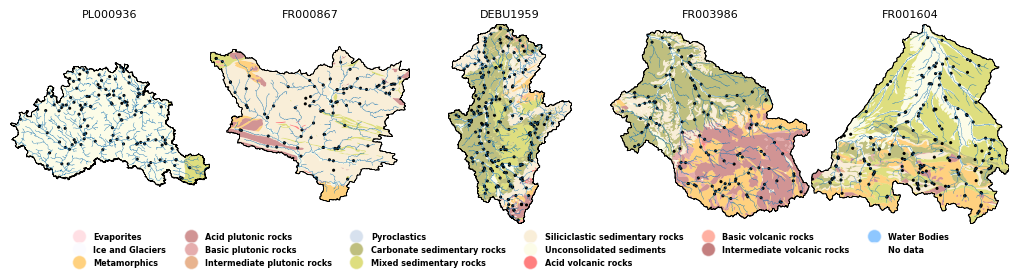

In [38]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'ev': "pink",  # Evaporites
    'ig': "ghostwhite",  # Ice and Glaciers
    'mt': "orange",  # Metamorphics
    'pa': "brown",  # Acid plutonic rocks
    'pb': "indianred",  # Basic plutonic rocks
    'pi': "chocolate",  # Intermediate plutonic rocks
    'py': "lightsteelblue",  # Pyroclastics
    'sc': "olive",  # Carbonate sedimentary rocks
    'sm': "y",  # Mixed sedimentary rocks
    'ss': "#F5DEB3",  # Siliciclastic sedimentary rocks
    'su': "#FAFAD2",  # Unconsolidated sediments
    'va': "red",  # Acid volcanic rocks
    'vb': "tomato",  # Basic volcanic rocks
    'vi': "darkred",  # Intermediate volcanic rocks
    'wb': "#1E90FF",  # Water Bodies
    'nd': "white"   # Precambrian rocks
}

# Define color mappings for legend
color_mapping_glim_legend = {
    'Evaporites': "pink",
    'Ice and Glaciers': "ghostwhite",
    'Metamorphics': "orange",
    'Acid plutonic rocks': "brown",
    'Basic plutonic rocks': "indianred",
    'Intermediate plutonic rocks': "chocolate",
    'Pyroclastics': "lightsteelblue",
    'Carbonate sedimentary rocks': "olive",
    'Mixed sedimentary rocks': "y",
    'Siliciclastic sedimentary rocks': "#F5DEB3",
    'Unconsolidated sediments': "#FAFAD2",
    'Acid volcanic rocks': "red",
    'Basic volcanic rocks': "tomato",
    'Intermediate volcanic rocks': "darkred",
    'Water Bodies': "#1E90FF",
    'No data': "white"
}

# Define catchment IDs and layout
#catchment_ids = ["FR001604", "PL000936", "FR000867", "FR000373", "DEBU1959"]
catchment_ids = ["PL000936", "ES000665", "DEBU1959", "FR001604", "FR000867"]
catchment_ids = ["PL000936", "FR000867", "FR003986", "FR001604"]
catchment_ids = ["PL000936", "FR000867", "DEBU1959", "FR003986", "FR001604"]
#catchment_ids = ["PL000936"]

# Define the figure size for each subplot (width, height) in inches
subplot_width = 2
subplot_height = 2  # half of the previous height for 2 rows

# Number of columns and rows for subplots
n_cols = 5
n_rows = (len(catchment_ids) + n_cols - 1) // n_cols  # to ensure all catchments are plotted


# Create figure and subplots
#fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2), constrained_layout=True)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(subplot_width * n_cols, subplot_height * n_rows))


axes = axes.flatten()

j = 0
# Plot each catchment in subplots
for ax, catchment_id in zip(axes, catchment_ids):
    plot_catchment(ax, catchment_id, catchment_boundaries, GLiM_reprojected, color_mapping_glim, network_estreams_gdf, j)
    
    rivers_fivesubs.plot(ax=ax, linewidth=0.25, label='River network')

    j = j + 1

# Hide any empty subplots
for i in range(len(catchment_ids), len(axes)):
    fig.delaxes(axes[i])

# Create legend elements
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label, alpha=0.5)
                   for label, color in color_mapping_glim_legend.items()]

# Add legend outside plot area at the bottom center
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=6, frameon=False, fontsize='small', title='')

# Add catchment labels to the figure, aligning them above each subplot
for i, catchment_id in enumerate(catchment_ids):
    # Position relative to each subplot area
    fig.text(0.10 + i % n_cols * 1 / n_cols, 1.05 - i // n_cols * 1 / n_rows, f'{catchment_id}',
             ha='center', va='center', fontsize=8, fontweight='normal')
    

# Adjust layout and display
plt.tight_layout(pad=0)

fig.savefig(r'results\figs\fig_geologies_a_with_moselle.png', dpi=300, bbox_inches='tight')


plt.show()


findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

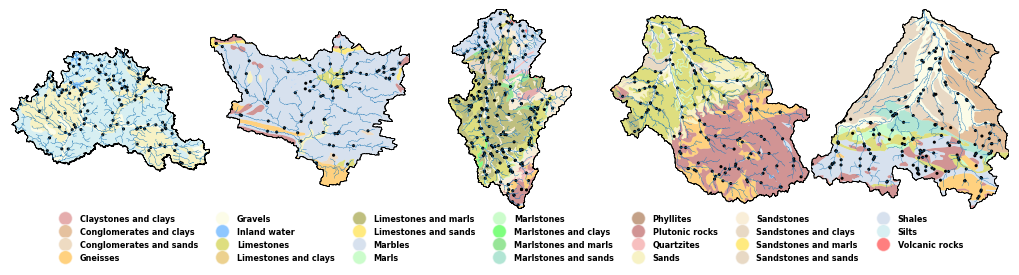

In [39]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd

# Extended color mapping for geology_median_dissolved
color_mapping_geology = {
    'Claystones and clays': 'indianred',             # Same as existing
    'Clays': '#CD5C5C',                              # Similar to Claystones and clays
    'Conglomerates': '#D2B48C',                      # Tan, close to Gravels
    'Conglomerates and clays': '#CD853F',            # Peru, slightly darker to indicate mixture
    'Conglomerates and sands': '#DEB887',            # Burlywood, close to Sands
    'Gneisses': 'orange',                            # Same as existing
    'Gravels': '#FAFAD2',                            # Same as existing
    'Inland water': '#1E90FF',                       # Same as existing
    'Limestones': 'y',                               # Same as existing
    'Limestones and clays': '#DAA520',               # Goldenrod, close to Limestones
    'Limestones and marls': 'olive',                 # Same as existing
    'Limestones and sands': '#FFD700',               # Gold, close to Limestones
    'Marbles': '#B0C4DE',                            # LightSteelBlue, similar to Quartzites but distinct
    'Marls': '#98FB98',                              # Pale Green, distinct but related to marlstones
    'Marlstones': 'palegreen',                       # Same as existing
    'Marlstones and clays': 'lime',                  # Same as existing
    'Marlstones and marls': '#32CD32',               # Same as existing
    'Marlstones and sands': '#66CDAA',               # Medium Aquamarine, slightly related to Marl
    'Phyllites': '#8B4513',                          # SaddleBrown, similar to Plutonic rocks
    'Plutonic rocks': 'brown',                       # Same as existing
    'Quartzites': 'lightcoral',                      # Same as existing
    'Sands': 'khaki',                                # Same as existing
    'Sandstones': '#F5DEB3',                         # Same as existing
    'Sandstones and clays': '#D2B48C',               # Tan, slightly darker as mixture
    'Sandstones and marls': 'gold',                  # Same as existing
    'Sandstones and sands': 'tan',                   # Same as existing
    'Schists': '#778899',                            # LightSlateGray, similar to Shales
    'Shales': 'lightsteelblue',                      # Same as existing
    'Silts': '#B0E0E6',                              # PowderBlue, similar to clays but softer
    'Snow field / ice field': '#F8F8FF',             # GhostWhite, indicating a cold area
    'Volcanic rocks': 'red'                          # Same as existing
}

color_mapping_geology_legend = {
    'Claystones and clays': 'indianred',
    #'Clays': '#CD5C5C',
    #'Conglomerates': '#D2B48C',
    'Conglomerates and clays': '#CD853F',
    'Conglomerates and sands': '#DEB887',
    'Gneisses': 'orange',
    'Gravels': '#FAFAD2',
    'Inland water': '#1E90FF',
    'Limestones': 'y',
    'Limestones and clays': '#DAA520',
    'Limestones and marls': 'olive',
    'Limestones and sands': '#FFD700',
    'Marbles': '#B0C4DE',
    'Marls': '#98FB98',
    'Marlstones': 'palegreen',
    'Marlstones and clays': 'lime',
    'Marlstones and marls': '#32CD32',
    'Marlstones and sands': '#66CDAA',
    'Phyllites': '#8B4513',
    'Plutonic rocks': 'brown',
    'Quartzites': 'lightcoral',
    'Sands': 'khaki',
    'Sandstones': '#F5DEB3',
    'Sandstones and clays': '#D2B48C',
    'Sandstones and marls': 'gold',
    'Sandstones and sands': 'tan',
    #'Schists': '#778899',
    'Shales': 'lightsteelblue',
    'Silts': '#B0E0E6',
    #'Snow field / ice field': '#F8F8FF',
    'Volcanic rocks': 'red'
}

# Define catchment IDs and layout
#catchment_ids = ["FR001604", "PL000936", "FR000867", "FR000373", "DEBU1959"]
catchment_ids = ["PL000936", "ES000665", "DEBU1959", "FR001604", "FR000867"]
catchment_ids = ["PL000936", "ES000665", "FR001604", "FR000867"]
catchment_ids = ["PL000936", "FR000867", "FR003986", "FR001604"]
catchment_ids = ["PL000936", "FR000867", "DEBU1959", "FR003986", "FR001604"]

# Define the figure size for each subplot (width, height) in inches
subplot_width = 2
subplot_height = 2  # half of the previous height for 2 rows

# Number of columns and rows for subplots
n_cols = 5
n_rows = (len(catchment_ids) + n_cols - 1) // n_cols  # to ensure all catchments are plotted


# Create figure and subplots
#fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2), constrained_layout=True)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(subplot_width * n_cols, subplot_height * n_rows))


axes = axes.flatten()

j = 0
# Plot each catchment in subplots
for ax, catchment_id in zip(axes, catchment_ids):
    plot_catchment(ax, catchment_id, catchment_boundaries, IHME_reprojected, color_mapping_geology, network_estreams_gdf, j)
    rivers_fivesubs.plot(ax=ax, linewidth=0.25, label='River network')
    j = j + 1

# Hide any empty subplots
for i in range(len(catchment_ids), len(axes)):
    fig.delaxes(axes[i])

# Create legend elements
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label, alpha=0.5)
                   for label, color in color_mapping_geology_legend.items()]

# Add legend outside plot area at the bottom center
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=7, frameon=False, fontsize='small', title='')

# Adjust layout and display
plt.tight_layout(pad=0)

fig.savefig(r'results\figs\fig_geologies_b_withmoselle.png', dpi=300, bbox_inches='tight')


plt.show()

Check the rock-types used

In [ ]:
import geopandas as gpd
from shapely.geometry import box

def clip_geology_by_basins(basin_ids, catchment_boundaries, GLiM_reprojected, color_mapping_glim):
    # Select the geometries for the specified basin IDs
    selected_geometries = catchment_boundaries[catchment_boundaries['basin_id'].isin(basin_ids)]

    # Dissolve the selected geometries into one to create a single combined shape for clipping
    combined_geometry = selected_geometries.unary_union

    # Clip the geology map by the combined basin geometry
    clipped_geology = GLiM_reprojected.clip(combined_geometry)

    # Get unique geology classes within the clipped area
    unique_geology_classes = clipped_geology['class'].unique()

    # Map colors to each unique class
    clipped_geology['color'] = clipped_geology['class'].map(color_mapping_glim)

    return clipped_geology, unique_geology_classes

# Example usage:
# List of basin IDs to clip by
#basin_ids = ["FR001604","PL000936", "FR000867", "FR000373"]  # Add more catchment IDs as needed
basin_ids = ["PL000936", "FR000867", "DEBU1959", "FR003986", "FR001604"]

# Get clipped geology and unique geology classes
clipped_geology, unique_geology_classes = clip_geology_by_basins(basin_ids, catchment_boundaries, GLiM_reprojected, color_mapping_glim)

# Display the unique geology classes in the clipped area
print("Unique geology classes in the clipped area:", unique_geology_classes)


# Get clipped geology and unique geology classes
clipped_geology, unique_geology_classes = clip_geology_by_basins(basin_ids, catchment_boundaries, IHME_reprojected, color_mapping_geology)

# Display the unique geology classes in the clipped area
print("Unique geology classes in the clipped area:", unique_geology_classes)

Unique geology classes in the clipped area: ['wb' 'vb' 'ss' 'pa' 'vi' 'mt' 'pb' 'sm' 'sc' 'su' 'va' 'pi']
Unique geology classes in the clipped area: ['Marlstones and marls' 'Marlstones and clays' 'Gravels'
 'Sandstones and sands' 'Sandstones and marls' 'Conglomerates and clays'
 'Volcanic rocks' 'Conglomerates and sands' 'Limestones and sands'
 'Marlstones and sands' 'Marls' 'Inland water' 'Limestones and marls'
 'Sands' 'Plutonic rocks' 'Phyllites' 'Marbles' 'Shales' 'Marlstones'
 'Limestones' 'Sandstones and clays' 'Gneisses' 'Quartzites' 'Sandstones'
 'Silts' 'Claystones and clays']


# Permeabilitites instead of classes

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

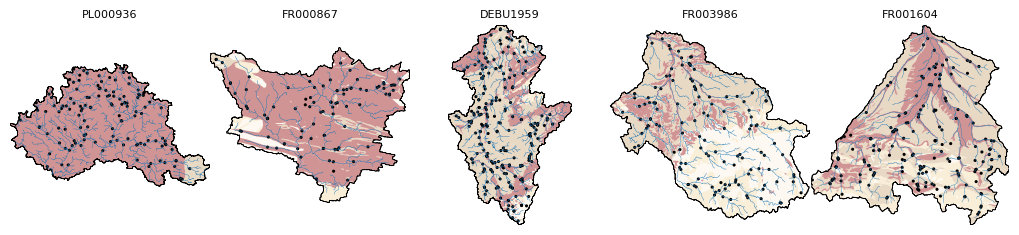

In [42]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'ev': "oldlace",  # Evaporites
    'ig': "oldlace",  # Ice and Glaciers
    'mt': "wheat",  # Metamorphics
    'pa': "oldlace",  # Acid plutonic rocks
    'pb': "oldlace",  # Basic plutonic rocks
    'pi': "wheat",  # Intermediate plutonic rocks
    'py': "wheat",  # Pyroclastics
    'sc': "tan",  # Carbonate sedimentary rocks
    'sm': "tan",  # Mixed sedimentary rocks
    'ss': "brown",  # Siliciclastic sedimentary rocks
    'su': "brown",  # Unconsolidated sediments
    'va': "oldlace",  # Acid volcanic rocks
    'vb': "oldlace",  # Basic volcanic rocks
    'vi': "wheat",  # Intermediate volcanic rocks
    'wb': "white",  # Water Bodies
    'nd': "white"   # Precambrian rocks
}

# Define color mappings for legend
color_mapping_glim_legend = {
    'Evaporites': "pink",
    'Ice and Glaciers': "ghostwhite",
    'Metamorphics': "orange",
    'Acid plutonic rocks': "brown",
    'Basic plutonic rocks': "indianred",
    'Intermediate plutonic rocks': "chocolate",
    'Pyroclastics': "lightsteelblue",
    'Carbonate sedimentary rocks': "olive",
    'Mixed sedimentary rocks': "y",
    'Siliciclastic sedimentary rocks': "#F5DEB3",
    'Unconsolidated sediments': "#FAFAD2",
    'Acid volcanic rocks': "red",
    'Basic volcanic rocks': "tomato",
    'Intermediate volcanic rocks': "darkred",
    'Water Bodies': "#1E90FF",
    'No data': "white"
}

# Define catchment IDs and layout
#catchment_ids = ["FR001604", "PL000936", "FR000867", "FR000373", "DEBU1959"]
catchment_ids = ["PL000936", "ES000665", "DEBU1959", "FR001604", "FR000867"]
catchment_ids = ["PL000936", "FR000867", "FR003986", "FR001604"]
catchment_ids = ["PL000936", "FR000867", "DEBU1959", "FR003986", "FR001604"]

# Define the figure size for each subplot (width, height) in inches
subplot_width = 2
subplot_height = 2  # half of the previous height for 2 rows

# Number of columns and rows for subplots
n_cols = 5
n_rows = (len(catchment_ids) + n_cols - 1) // n_cols  # to ensure all catchments are plotted


# Create figure and subplots
#fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2), constrained_layout=True)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(subplot_width * n_cols, subplot_height * n_rows))


axes = axes.flatten()

j = 0
# Plot each catchment in subplots
for ax, catchment_id in zip(axes, catchment_ids):
    plot_catchment(ax, catchment_id, catchment_boundaries, GLiM_reprojected, color_mapping_glim, network_estreams_gdf, j)
    rivers_fivesubs.plot(ax=ax, linewidth=0.25, label='River network')
    j = j + 1

# Hide any empty subplots
for i in range(len(catchment_ids), len(axes)):
    fig.delaxes(axes[i])

# Add catchment labels to the figure, aligning them above each subplot
for i, catchment_id in enumerate(catchment_ids):
    # Position relative to each subplot area
    fig.text(0.10 + i % n_cols * 1 / n_cols, 1.05 - i // n_cols * 1 / n_rows, f'{catchment_id}',
             ha='center', va='center', fontsize=8, fontweight='normal')
    

# Adjust layout and display
plt.tight_layout(pad=0)

fig.savefig(r'results\figs\fig_permeabilities_a.png', dpi=300, bbox_inches='tight')


plt.show()

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

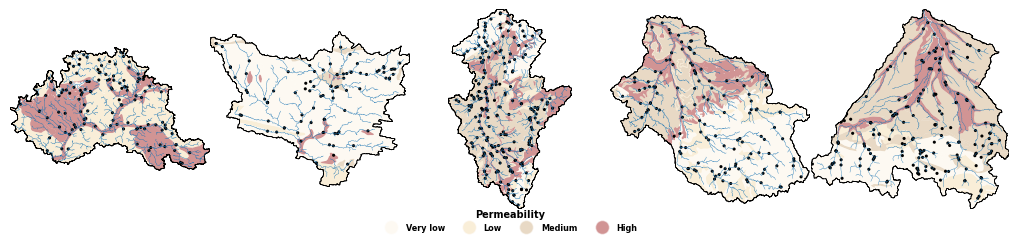

In [46]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd

# Extended color mapping for geology_median_dissolved
color_mapping_geology = {
    'Claystones and clays': 'wheat',             # Same as existing
    'Clays': 'oldlace',                              # Similar to Claystones and clays
    'Conglomerates': 'brown',                      # Tan, close to Gravels
    'Conglomerates and clays': 'tan',            # Peru, slightly darker to indicate mixture
    'Conglomerates and sands': 'brown',            # Burlywood, close to Sands
    'Gneisses': 'wheat',                            # Same as existing
    'Gravels': 'brown',                            # Same as existing
    'Inland water': 'oldlace',                       # Same as existing
    'Limestones': 'tan',                               # Same as existing
    'Limestones and clays': 'tan',               # Goldenrod, close to Limestones
    'Limestones and marls': 'tan',                 # Same as existing
    'Limestones and sands': 'tan',               # Gold, close to Limestones
    'Marbles': 'wheat',                            # LightSteelBlue, similar to Quartzites but distinct
    'Marls': 'wheat',                              # Pale Green, distinct but related to marlstones
    'Marlstones': 'wheat',                       # Same as existing
    'Marlstones and clays': 'wheat',                  # Same as existing
    'Marlstones and marls': 'wheat',               # Same as existing
    'Marlstones and sands': 'tan',               # Medium Aquamarine, slightly related to Marl
    'Phyllites': 'wheat',                          # SaddleBrown, similar to Plutonic rocks
    'Plutonic rocks': 'oldlace',                       # Same as existing
    'Quartzites': 'oldlace',                      # Same as existing
    'Sands': 'brown',                                # Same as existing
    'Sandstones': 'brown',                         # Same as existing
    'Sandstones and clays': 'tan',               # Tan, slightly darker as mixture
    'Sandstones and marls': 'tan',                  # Same as existing
    'Sandstones and sands': 'brown',                   # Same as existing
    'Schists': 'wheat',                            # LightSlateGray, similar to Shales
    'Shales': 'oldlace',                      # Same as existing
    'Silts': 'wheat',                              # PowderBlue, similar to clays but softer
    'Snow field / ice field': 'oldlace',             # GhostWhite, indicating a cold area
    'Volcanic rocks': 'oldlace'                          # Same as existing
}

# Define catchment IDs and layout
#catchment_ids = ["FR001604", "PL000936", "FR000867", "FR000373", "DEBU1959"]
catchment_ids = ["PL000936", "ES000665", "DEBU1959", "FR001604", "FR000867"]
catchment_ids = ["PL000936", "ES000665", "FR001604", "FR000867"]
catchment_ids = ["PL000936", "FR000867", "FR003986", "FR001604"]
catchment_ids = ["PL000936", "FR000867", "DEBU1959", "FR003986", "FR001604"]

# Define the figure size for each subplot (width, height) in inches
subplot_width = 2
subplot_height = 2  # half of the previous height for 2 rows

# Number of columns and rows for subplots
n_cols = 5
n_rows = (len(catchment_ids) + n_cols - 1) // n_cols  # to ensure all catchments are plotted


# Create figure and subplots
#fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2), constrained_layout=True)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(subplot_width * n_cols, subplot_height * n_rows))


axes = axes.flatten()

j = 0
# Plot each catchment in subplots
for ax, catchment_id in zip(axes, catchment_ids):
    plot_catchment(ax, catchment_id, catchment_boundaries, IHME_reprojected, color_mapping_geology, network_estreams_gdf, j)
    rivers_fivesubs.plot(ax=ax, linewidth=0.25, label='River network')
    j = j + 1

# Hide any empty subplots
for i in range(len(catchment_ids), len(axes)):
    fig.delaxes(axes[i])

# Define your dictionary with labels and corresponding colors
color_mapping_geology_legend = {
    'Very low': 'oldlace',
    'Low': 'wheat',
    'Medium': 'tan',
    'High': 'brown'
}

# Create legend elements
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label, alpha=0.5)
                   for label, color in color_mapping_geology_legend.items()]

# Add legend outside plot area at the bottom center
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=7, frameon=False, fontsize='small', title='Permeability')

# Adjust layout and display
plt.tight_layout(pad=0)

fig.savefig(r'results\figs\fig_permeabilities_b.png', dpi=300, bbox_inches='tight')

plt.show()

## Tables

In [ ]:
estreams_attributes_dfs_moselle = estreams_attributes_dfs["DEBU1959"][["area_estreams", 'lon', 'lat', 'start_date', 'end_date',
       'num_years', "gauges_upstream"]]
estreams_attributes_dfs_moselle.to_csv("results/table_modelle.csv")

# Moselle 

In [24]:
# First we define the outlet of the Moselle to be used
outlets = ["DEBU1959"]
nested_cats_df = nested_catchments.loc[outlets, :]
nested_cats_df

nested_catchments
basin_id                                                   
DEBU1959  [BEWA0066, BEWA0067, BEWA0087, BEWA0106, BEWA0...

In [25]:
# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

estreams_attributes_dfs["DEBU1959"]

100%|██████████| 1/1 [00:00<00:00, 311.54it/s]


gauge_id     gauge_name gauge_country  gauge_provider      river  \
basin_id                                                                     
BEWA0066  99141002        Reuland            BE          BE_SPW        Our   
BEWA0067  99261002     Schoenberg            BE          BE_SPW        Our   
BEWA0087  56100000     Martelange            BE          BE_SPW       Sure   
BEWA0106  60800000        Reuland            BE          BE_SPW        Ulf   
BEWA0107  60900000  Lommersweiler            BE          BE_SPW  Braunlauf   
...            ...            ...           ...             ...        ...   
LU000015        34       Michelau            LU  LU_CONTACTFORM       Sure   
LU000016         3    Pfaffenthal            LU  LU_CONTACTFORM    Alzette   
LU000017        16        Rosport            LU  LU_CONTACTFORM       Sure   
LU000018         5     Schoenfels            LU  LU_CONTACTFORM      Mamer   
LU000019        12        Vianden            LU  LU_CONTACTFORM        Our   

          lon_snap   lat_snap       lon        lat elevation  ...  \
basin_id                                                      ...   
BEWA0066  6.151802  50.188258  6.151802  50.188258       NaN  ...   
BEWA0067  6.263467  50.289277  6.263467  50.289277       NaN  ...   
BEWA0087  5.739269  49.833704  5.739269  49.833704       NaN  ...   
BEWA0106  6.150669  50.196522  6.150669  50.196522       NaN  ...   
BEWA0107  6.153292  50.235014  6.153955  50.234494       NaN  ...   
...            ...        ...       ...        ...       ...  ...   
LU000015  6.091178  49.895421  6.091178  49.895421       NaN  ...   
LU000016  6.132266  49.620647  6.132266  49.620647       NaN  ...   
LU000017  6.509851  49.785883  6.509851  49.785883       NaN  ...   
LU000018  6.100795  49.723112  6.100795  49.723112       NaN  ...   
LU000019  6.204738  49.939224  6.204738  49.939224       NaN  ...   

          lakes_tot_area  lakes_tot_vol  sno_cov_mean  irri_1990 irri_2005  \
basin_id                                                                     
BEWA0066            0.00           0.00         7.497      1.400     3.429   
BEWA0067            0.00           0.00         8.920      0.000     0.075   
BEWA0087            0.00           0.00         6.106      0.000     0.000   
BEWA0106            0.00           0.00         7.096      1.200     2.427   
BEWA0107            0.00           0.00         6.996      0.200     0.605   
...                  ...            ...           ...        ...       ...   
LU000015            1.80          62.62         5.680      0.045     0.045   
LU000016            0.00           0.00         2.863      0.004     0.009   
LU000017            2.67          67.85         4.753      1.641     4.770   
LU000018            0.00           0.00         3.184      0.015     0.015   
LU000019            0.00           0.00         6.627      1.495     3.524   

         stations_num_p_mean  perm_high_ff2  perm_medium_ff2  perm_lower_ff2  \
basin_id                                                                       
BEWA0066                16.0       2.947531         0.000000        3.319025   
BEWA0067                 8.0       2.347625         0.000000        0.000000   
BEWA0087                 6.0       0.005000         0.000000        0.000000   
BEWA0106                 9.0       0.000000         0.000000        0.000000   
BEWA0107                 6.0       3.999021         0.000000       15.492765   
...                      ...            ...              ...             ...   
LU000015                25.0       1.917023         0.000000        0.000000   
LU000016                15.0      14.327884        32.255374       53.416742   
LU000017                78.0      18.753136         5.872553       24.977481   
LU000018                17.0      39.499138         0.000000       60.500862   
LU000019                27.0       3.530352         2.493791        1.855134   

          perm_impermeable_ff2  
basin_id

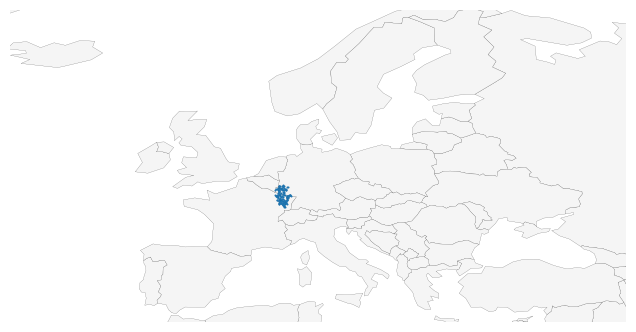

In [26]:
# Create subplots
fig, axes = plt.subplots()
# Flatten the axes array

plot_watershed_groups_from_dict(estreams_attributes_used = estreams_attributes_dfs, figsize=(8, 6), ax=axes, 
                      title_plot='', limits_europe = True)

### Correlation analysis

In [27]:
# Store the correlation matrices for selected catchments in a dictionary:
# Initialize an empty dictionary to store correlation DataFrames for the selected variables
correlation_dict = {}

# Iterate over each variable in the first 14 columns of your data
for variable in tqdm.tqdm(estreams_attributes.columns[29:43]):
    # Initialize an empty DataFrame to store correlations
    correlation_df = pd.DataFrame()

    # Iterate over each watershed group
    for catchment in estreams_attributes_dfs.keys():

        estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
        #estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date > "2009"]
        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

       'perc_imp','perc_low_perm', 'perc_medium_perm', 'perc_high_perm', 
       'perm_impermeable_euro', 'perm_lower_euro', 'perm_medium_euro', 'perm_high_euro',
       "perm_impermeable_ff2", "perm_lower_ff2", "perm_medium_ff2", "perm_high_ff2",
       
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]]
        
        # Calculate correlations between the current variable and other variables
        correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
        
        # Add the correlations to the DataFrame
        correlation_df[catchment] = correlations

    # Add the correlation DataFrame to the dictionary
    correlation_dict[variable] = correlation_df

# Print the keys of the correlation dictionary
print(correlation_dict.keys())

100%|██████████| 14/14 [00:00<00:00, 34.33it/s]

dict_keys(['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq'])


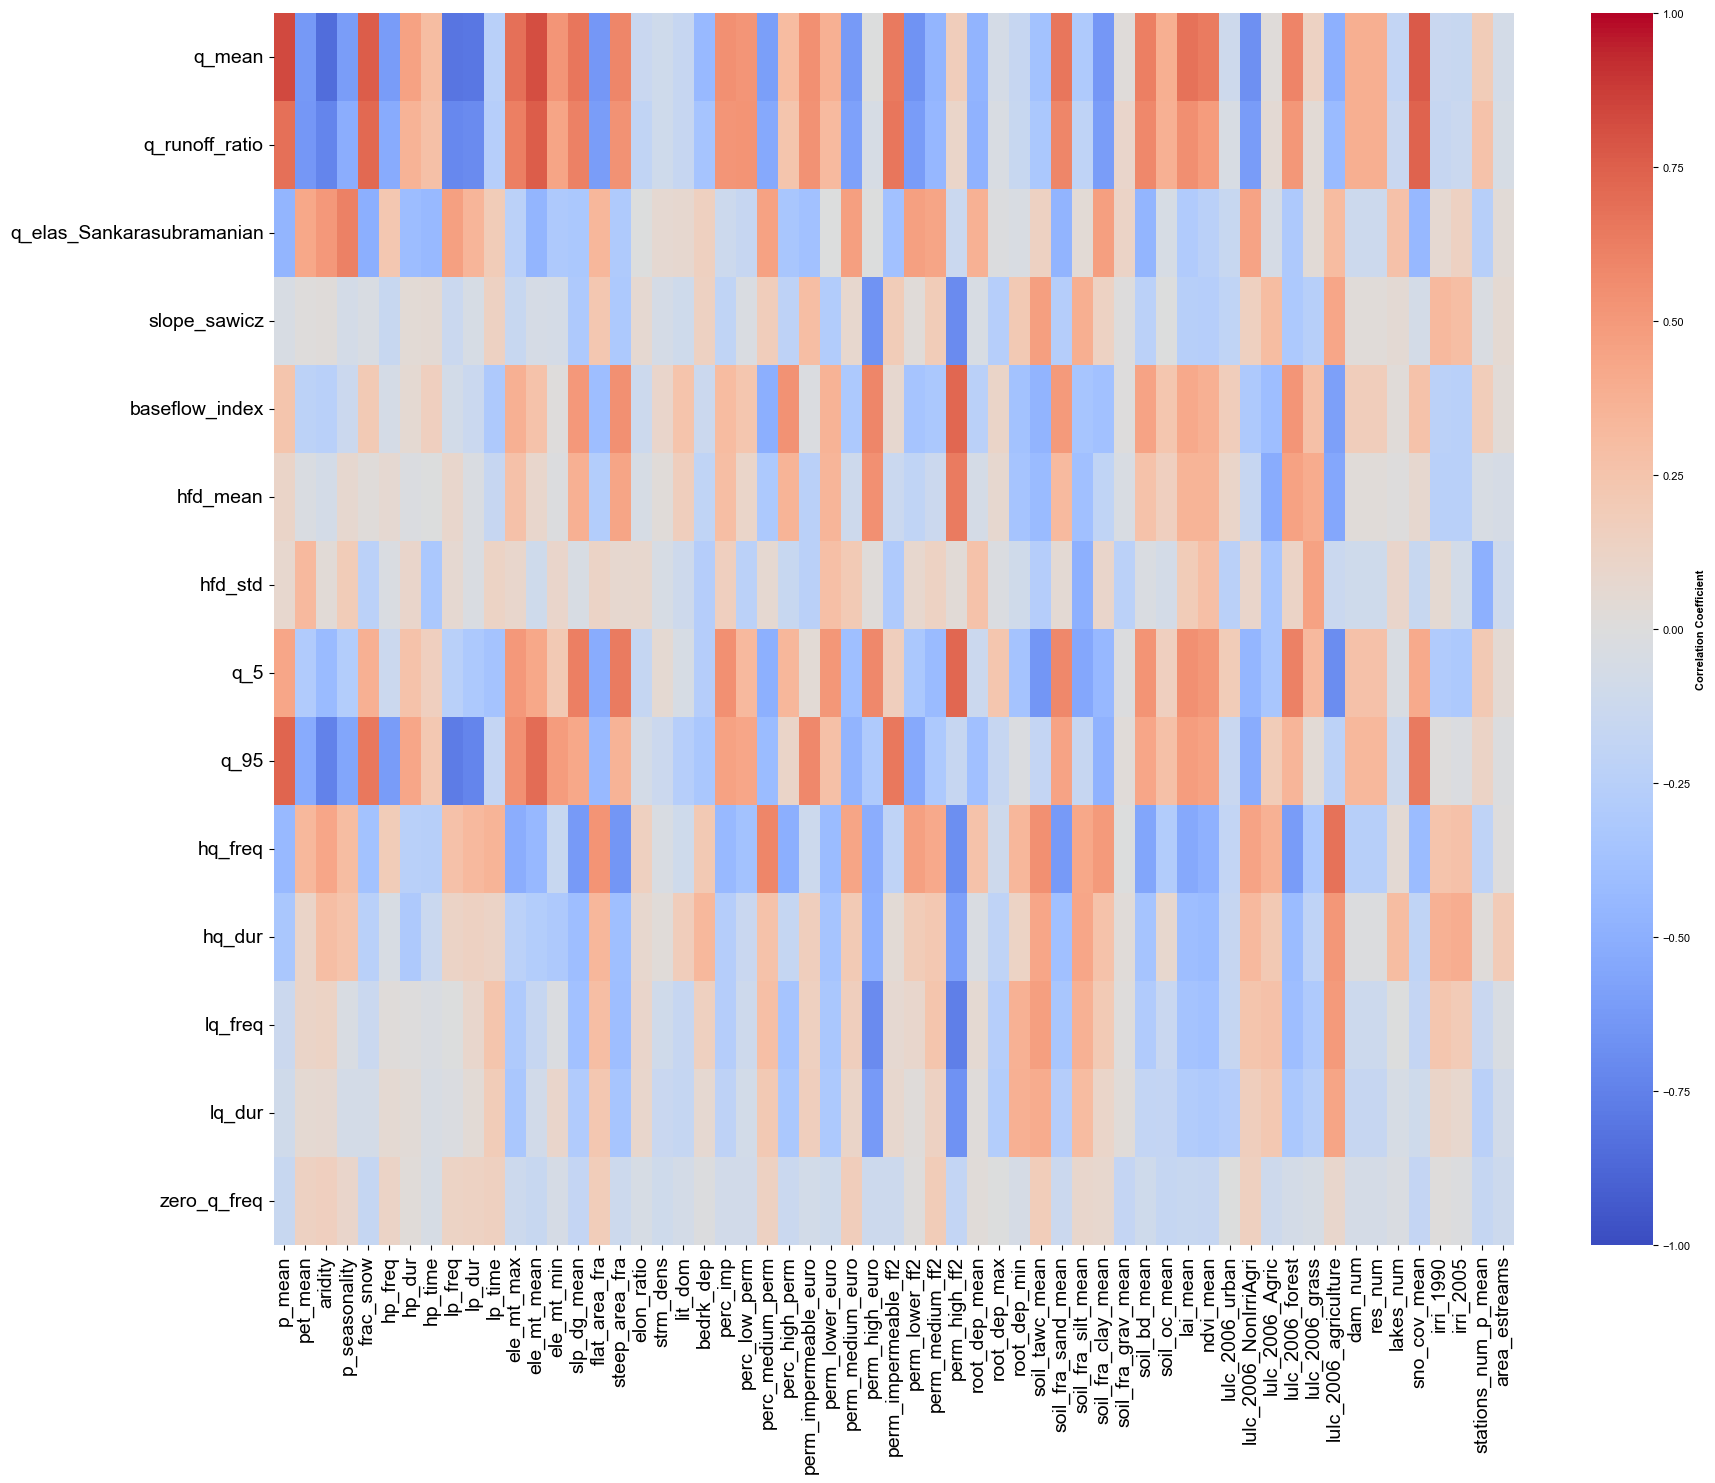

In [30]:
# Assuming correlation_dict is a dictionary containing all correlation DataFrames
# Initialize an empty list to store individual correlation DataFrames
correlation_list = []

# Iterate over all keys in the dictionary and append their DataFrame to the list with an added 'signature' column
for signature in correlation_dict.keys():
    corr_df = correlation_dict[signature].T
    corr_df['signature'] = signature  # Add a column to identify the signature
    correlation_list.append(corr_df)

# Concatenate all correlation DataFrames along the rows
combined_correlation_df = pd.concat(correlation_list)

# Preserve the order of the signatures by converting to categorical type
combined_correlation_df['signature'] = pd.Categorical(
    combined_correlation_df['signature'],
    categories=list(correlation_dict.keys()),
    ordered=True
)

# Set the signature column as the index
combined_correlation_df.set_index('signature', inplace=True)

# Customize row names (for demonstration purposes, modify as needed)
#custom_row_names = ['Row ' + str(i) for i in range(1, len(combined_correlation_df.index) + 1)]
#combined_correlation_df.index = custom_row_names

# Plot the combined heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(combined_correlation_df, annot=False, cmap='coolwarm', fmt=".1f", vmin=-1, vmax=1, 
            cbar_kws={'label': 'Correlation Coefficient'}, 
            yticklabels=combined_correlation_df.index)

#plt.title('Combined Heatmap for All Signatures', fontsize=20)
#plt.xlabel('Variables', fontsize=15)
plt.ylabel('', fontsize=15)

# Customize font sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [31]:
# Group the variable features to groups
# Here we can use a dictionary to reclassifiy the variables we have to groups such as: climate, soil, geolofy
variable_dict = {
    'p_mean': 'climatic',
    'pet_mean': 'climatic',
    'aridity': 'climatic',
    'p_seasonality': 'climatic',
    'frac_snow': 'climatic',
    'hp_freq': 'climatic',
    'hp_dur': 'climatic',
    'hp_time': 'climatic',
    'lp_freq': 'climatic',
    'lp_dur': 'climatic',
    'lp_time': 'climatic',
    'ele_mt_max': 'topography',
    'ele_mt_mean': 'topography',
    'ele_mt_min': 'topography',
    'slp_dg_mean': 'topography',
    'flat_area_fra': 'topography',
    'steep_area_fra': 'topography',
    'elon_ratio': 'topography',
    'strm_dens': 'topography',
    'lit_dom': 'geology',
    'bedrk_dep': 'soil',
    'perc_imp': 'geology_low',
    'perc_low_perm': 'geology_low',
    'perc_medium_perm': 'geology_low',
    'perc_high_perm': 'geology_low',
    'root_dep_mean': 'soil',
    'root_dep_max': 'soil',
    'root_dep_min': 'soil',
    'soil_tawc_mean': 'soil',
    'soil_fra_sand_mean': 'soil',
    'soil_fra_silt_mean': 'soil',
    'soil_fra_clay_mean': 'soil',
    'soil_fra_grav_mean': 'soil',
    'soil_bd_mean': 'soil',
    'soil_oc_mean': 'soil',
    'lai_mean': 'lulc',
    'ndvi_mean': 'lulc',
    'lulc_2006_urban': 'lulc',
    'lulc_2006_NonIrriAgri': 'lulc',
    'lulc_2006_Agric': 'lulc',
    'lulc_2006_forest': 'lulc',
    'lulc_2006_grass': 'lulc',
    'lulc_2006_agriculture': 'lulc',
    'dam_num': 'hydrology',
    'res_num': 'hydrology',
    'lakes_num': 'hydrology',
    'sno_cov_mean': 'climatic',
    'irri_1990': 'hydrology',
    'irri_2005': 'hydrology',
    'perm_high_euro': 'geology_med',
    'perm_medium_euro': 'geology_med',
    'perm_lower_euro': 'geology_med',
    'perm_impermeable_euro': 'geology_med',
    'stations_num_p_mean': 'climatic',
    "perm_mos_ff": 'geology_high', 
    "semiperm_mos_ff": 'geology_high', 
    "imper_mos_ff": 'geology_high',
    'perm_high_ff2': "geology_high", 
    'perm_medium_ff2': "geology_high", 
    'perm_lower_ff2': "geology_high",
    'perm_impermeable_ff2': "geology_high",
    "area_estreams": "topography"
}


# Select the variable
signatures = ['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 
              'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq']


# Define the classes (example list, adjust based on your classes)
classes = ["climatic", "geology", "geology_low", "lulc", "soil", "topography", "vegetation", "hydrology", "geology_med", "geology_high"]

corr_max_group_dfs = pd.DataFrame(columns = signatures)

for signature in signatures:
    correlation_df = correlation_dict[signature]
    
    # Initialize the dataframe with columns for each class's maximum correlation and feature
    columns = []
    for cls in classes:
        columns.append(f"corr_max_{cls}")
        columns.append(f"corr_max_feature_{cls}")

    corr_max_group_df = pd.DataFrame(index=correlation_df.columns, columns=columns)

    # Populate the dataframe with the maximum correlations for each class
    for catchment in correlation_df.columns:
        max_corr = {cls: 0 for cls in classes}
        max_feature = {cls: None for cls in classes}

        for feature in correlation_df.index:
            cls = variable_dict[feature]
            corr_value = abs(correlation_df.loc[feature, catchment])

            if corr_value > abs(max_corr[cls]):
                max_corr[cls] = correlation_df.loc[feature, catchment]
                max_feature[cls] = feature

        for cls in classes:
            corr_max_group_df.loc[catchment, f"corr_max_{cls}"] = max_corr[cls]
            corr_max_group_df.loc[catchment, f"corr_max_feature_{cls}"] = max_feature[cls]

    # Reclassify geological classes using the mapping dictionary for each class's feature
    for cls in classes:
        corr_max_group_df[f"corr_max_feature_{cls}"] = corr_max_group_df[f"corr_max_feature_{cls}"].map(variable_dict)

    corr_max_group_df = corr_max_group_df[['corr_max_climatic', 'corr_max_geology_low', "corr_max_geology_med", "corr_max_geology_high",
                                                      'corr_max_lulc', 'corr_max_soil', 'corr_max_topography', 
                                                      'corr_max_vegetation', 'corr_max_hydrology']]

    # Sort and add additional columns
    corr_max_group_df.iloc[:, 0:7] = corr_max_group_df.iloc[:, 0:7].astype(float)
    corr_max_group_df = corr_max_group_df.astype(float)
    corr_max_group_df = corr_max_group_df.T.iloc[0:-2]
    corr_max_group_dfs[signature] = corr_max_group_df


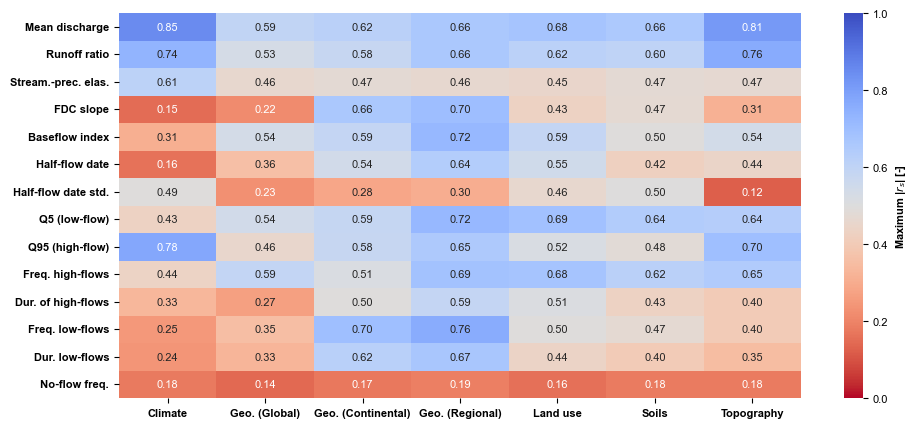

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming corr_max_group_dfs is your DataFrame and it already contains the required data
# Create custom x labels
custom_x_labels = ["Climate", "Geo. (Global)", "Geo. (Continental)", "Geo. (Regional)", "Land use", 
                   "Soils", "Topography"]  # Replace with your labels
# Create custom y labels (adjust based on your data)
custom_y_labels = ['Mean discharge', 'Runoff ratio','Stream.-prec. elas.','FDC slope','Baseflow index','Half-flow date','Half-flow date std.', 
                   'Q5 (low-flow)', 'Q95 (high-flow)','Freq. high-flows', 'Dur. of high-flows', 'Freq. low-flows', 'Dur. low-flows', 'No-flow freq.']

corr_max_group_dfs_abs = corr_max_group_dfs.abs()
# Plot the heatmap
plt.figure(figsize=(11, 5))
ax = sns.heatmap(corr_max_group_dfs_abs.T, annot=True, cmap='coolwarm_r', fmt=".2f", vmin=0, vmax=1, alpha=1)

# Set custom x labels
ax.set_xticklabels(custom_x_labels, rotation=0, ha='center', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed
# Set custom y labels
ax.set_yticklabels(custom_y_labels, rotation=0, ha='right', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed

# Customize the legend label
colorbar = ax.collections[0].colorbar
colorbar.set_label(r'Maximum |$r_s$| [-]', fontsize=8, fontweight='bold')

#plt.title(f'Heatmap for {signature}')
plt.savefig(r'results\figs\fig_paper_heatmap.png', dpi=300, bbox_inches='tight')

plt.show()

In [33]:
estreams_attributes_dfs_cat["end_date"] = estreams_attributes["end_date"] 

### Scatter plot with size dependency

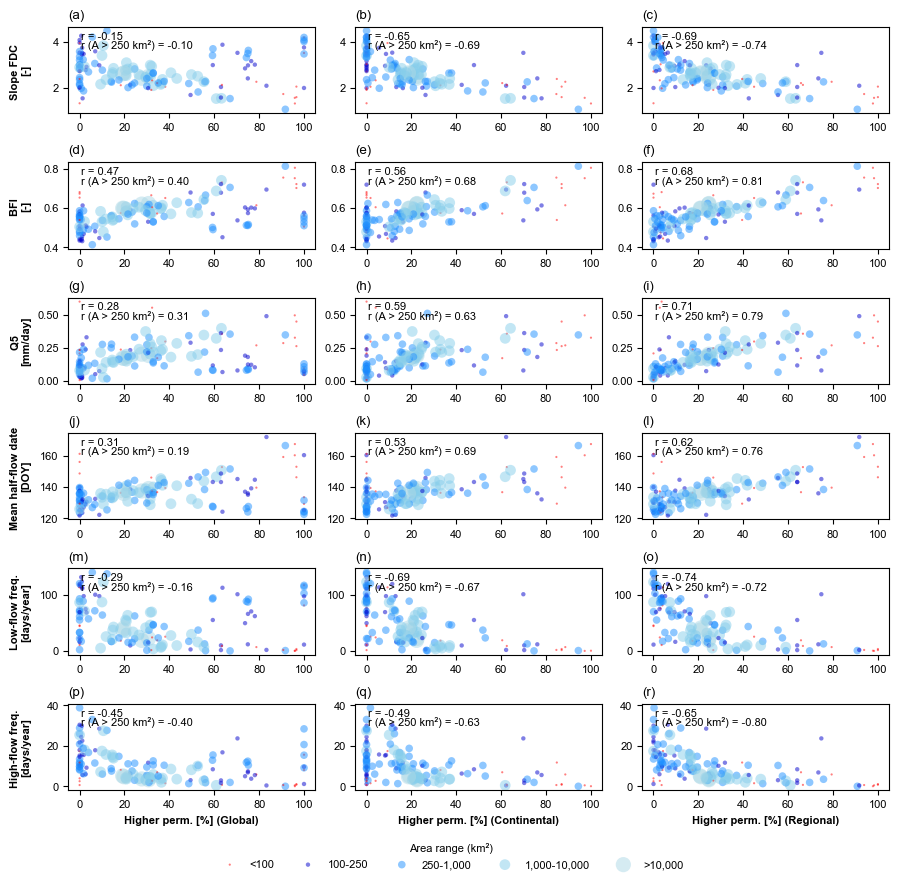

In [168]:
df = estreams_attributes_dfs["DEBU1959"]
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr


df = estreams_attributes_dfs["DEBU1959"]
df = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date >= "2009"]

# Assuming df is your DataFrame and it already contains the required columns
y_cols = ["perc_high_perm", "perm_high_euro", "perm_high_ff2"]
x_cols = ["slope_sawicz", "baseflow_index", "q_5", "hfd_mean", "lq_freq", "hq_freq"]
size_col = "area_estreams"

# Define size classes, corresponding sizes, and colors for the scatter plot
def get_size_color(area):
    if area < 100:
        return 2.5, 'red'  # Dark Blue
    elif 100 <= area < 250:
        return 10, '#0000CD'  # Medium Blue
    elif 250 <= area < 1000:
        return 30, '#1E90FF'  # Dodger Blue
    elif 1000 <= area < 10000:
        return 60, '#87CEEB'  # Sky Blue
    else:
        return 120, '#ADD8E6'  # Light Blue

# Apply the get_size_color function to the size_col to create new columns for sizes and colors
df['scaled_size'], df['color'] = zip(*df[size_col].apply(get_size_color))

# Filter data with area > 250
df_filtered = df[df[size_col] > 250]

# Apply the get_size_color function to the size_col to create new columns for sizes and colors for the filtered data
df_filtered['scaled_size'], df_filtered['color'] = zip(*df_filtered[size_col].apply(get_size_color))

# Custom labels for each subplot's x-axis
x_labels = ["Higher perm. [%] (Global)", "Higher perm. [%] (Continental)", "Higher perm. [%] (Regional)"]
y_labels = ["Slope FDC \n[-]", "BFI \n[-]", "Q5 \n[mm/day]", "Mean half-flow date \n[DOY]", "Low-flow freq.\n[days/year]", "High-flow freq. \n[days/year]"]

# Create the subplots
fig, axs = plt.subplots(len(y_labels), 3, figsize=(9, 1.4*len(y_labels)))

k = 0
for j, x_col in enumerate(x_cols):
    # Loop through the y_cols to create each subplot
    for i, y_col in enumerate(y_cols):
        ax = axs[j, i]
        ax.scatter(df[y_col], df[x_col], s=df['scaled_size'], alpha=0.5, c=df['color'], edgecolors='none')
        #ax.set_xlabel(x_labels[i])
        if i == 0:
            ax.set_ylabel(y_labels[j])

        if j == len(y_labels) - 1:
            ax.set_xlabel(x_labels[i])

        ax.set_title(f"({chr(97 + k)})", loc="left")  # chr(97) is 'a', chr(98) is 'b', etc.
        

        # Drop NaNs and calculate Spearman correlation coefficient for all data
        non_nan_data_all = df[[y_col, x_col]].dropna()
        corr_coef_all, _ = spearmanr(non_nan_data_all[y_col], non_nan_data_all[x_col])
        
        # Drop NaNs and calculate Spearman correlation coefficient for filtered data
        non_nan_data_filtered = df_filtered[[y_col, x_col]].dropna()
        corr_coef_filtered, _ = spearmanr(non_nan_data_filtered[y_col], non_nan_data_filtered[x_col])
        
        ax.text(0.05, 0.95, f'r = {corr_coef_all:.2f}', transform=ax.transAxes, verticalalignment='top')
        ax.text(0.05, 0.85, f'r (A > 250 km²) = {corr_coef_filtered:.2f}', transform=ax.transAxes, verticalalignment='top')
        
        # Set y-axis limits
        #ax.set_ylim(0, 5)
        k = k + 1


# Create custom legend handles
handles = [
    plt.scatter([], [], s=2.5, color='red', alpha=0.5, label='<100', edgecolors='none'),
    plt.scatter([], [], s=10, color='#0000CD', alpha=0.5, label='100-250', edgecolors='none'),
    plt.scatter([], [], s=30, color='#1E90FF', alpha=0.5, label='250-1,000', edgecolors='none'),
    plt.scatter([], [], s=60, color='#87CEEB', alpha=0.5, label='1,000-10,000', edgecolors='none'),
    plt.scatter([], [], s=120, color='#ADD8E6', alpha=0.5, label='>10,000', edgecolors='none')
]

# Add the legend below the figure
fig.legend(handles=handles, title='Area range (km²)', loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05), frameon=False)


plt.tight_layout()
fig.align_ylabels()

# Display the plot
plt.show()
fig.savefig(r'results\figs\fig_paper_combined_scatter.png', dpi=300, bbox_inches='tight')


# Subcatchments 

In [170]:
# Filter the catchments in Moselle

cats_moselle = estreams_attributes_dfs["DEBU1959"][estreams_attributes_dfs["DEBU1959"].end_date >= "2009"].index.tolist()
len(cats_moselle)

135

In [171]:
# Filter only the Moselle catchments
estreams_attributes_moselle = estreams_attributes.loc[cats_moselle, :]
estreams_attributes_moselle

gauge_id     gauge_name gauge_country  gauge_provider      river  \
basin_id                                                                     
BEWA0066  99141002        Reuland            BE          BE_SPW        Our   
BEWA0067  99261002     Schoenberg            BE          BE_SPW        Our   
BEWA0087  56100000     Martelange            BE          BE_SPW       Sure   
BEWA0106  60800000        Reuland            BE          BE_SPW        Ulf   
BEWA0107  60900000  Lommersweiler            BE          BE_SPW  Braunlauf   
...            ...            ...           ...             ...        ...   
LU000015        34       Michelau            LU  LU_CONTACTFORM       Sure   
LU000016         3    Pfaffenthal            LU  LU_CONTACTFORM    Alzette   
LU000017        16        Rosport            LU  LU_CONTACTFORM       Sure   
LU000018         5     Schoenfels            LU  LU_CONTACTFORM      Mamer   
LU000019        12        Vianden            LU  LU_CONTACTFORM        Our   

          lon_snap   lat_snap       lon        lat elevation  ...  \
basin_id                                                      ...   
BEWA0066  6.151802  50.188258  6.151802  50.188258       NaN  ...   
BEWA0067  6.263467  50.289277  6.263467  50.289277       NaN  ...   
BEWA0087  5.739269  49.833704  5.739269  49.833704       NaN  ...   
BEWA0106  6.150669  50.196522  6.150669  50.196522       NaN  ...   
BEWA0107  6.153292  50.235014  6.153955  50.234494       NaN  ...   
...            ...        ...       ...        ...       ...  ...   
LU000015  6.091178  49.895421  6.091178  49.895421       NaN  ...   
LU000016  6.132266  49.620647  6.132266  49.620647       NaN  ...   
LU000017  6.509851  49.785883  6.509851  49.785883       NaN  ...   
LU000018  6.100795  49.723112  6.100795  49.723112       NaN  ...   
LU000019  6.204738  49.939224  6.204738  49.939224       NaN  ...   

          lakes_tot_area  lakes_tot_vol  sno_cov_mean  irri_1990 irri_2005  \
basin_id                                                                     
BEWA0066            0.00           0.00         7.497      1.400     3.429   
BEWA0067            0.00           0.00         8.920      0.000     0.075   
BEWA0087            0.00           0.00         6.106      0.000     0.000   
BEWA0106            0.00           0.00         7.096      1.200     2.427   
BEWA0107            0.00           0.00         6.996      0.200     0.605   
...                  ...            ...           ...        ...       ...   
LU000015            1.80          62.62         5.680      0.045     0.045   
LU000016            0.00           0.00         2.863      0.004     0.009   
LU000017            2.67          67.85         4.753      1.641     4.770   
LU000018            0.00           0.00         3.184      0.015     0.015   
LU000019            0.00           0.00         6.627      1.495     3.524   

         stations_num_p_mean  perm_high_ff2  perm_medium_ff2  perm_lower_ff2  \
basin_id                                                                       
BEWA0066                16.0       2.947531         0.000000        3.319025   
BEWA0067                 8.0       2.347625         0.000000        0.000000   
BEWA0087                 6.0       0.005000         0.000000        0.000000   
BEWA0106                 9.0       0.000000         0.000000        0.000000   
BEWA0107                 6.0       3.999021         0.000000       15.492765   
...                      ...            ...              ...             ...   
LU000015                25.0       1.917023         0.000000        0.000000   
LU000016                15.0      14.327884        32.255374       53.416742   
LU000017                78.0      18.753136         5.872553       24.977481   
LU000018                17.0      39.499138         0.000000       60.500862   
LU000019                27.0       3.530352         2.493791        1.855134   

          perm_impermeable_ff2  
basin_id

In [172]:
# First we filter the potential watersheds:
list_cats_moselle = estreams_attributes_moselle[estreams_attributes_moselle.gauges_upstream <= 60][estreams_attributes_moselle.gauges_upstream >= 10].sort_values(by='gauges_upstream', ascending=True)["gauges_upstream"].index.tolist()

# Here we filter the list of nested_catchments according to this first filter:
nested_cats_moselle_df = nested_catchments.loc[list_cats_moselle, :]

print("Number of catchemnts with potentially nested catchments:", len(list_cats_moselle))

Number of catchemnts with potentially nested catchments: 21


In [173]:
# Filter only the catchemnts using the function stated before (unique headwaters):
nested_cats_moselle_filtered = find_unique_nested_catchments(nested_cats_moselle_df)
print(nested_cats_moselle_filtered)

['FR003283', 'FR003249', 'FR000159', 'LU000017', 'DEBU1957']


In [174]:
# Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_moselle_df = nested_catchments.loc[nested_cats_moselle_filtered, :]

In [175]:
# Store the variables for the selected catchments in a list of dataframes:
estreams_attributes_headwaters_moselle_dfs = {}

for catchment in tqdm.tqdm(nested_cats_moselle_filtered):

    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_moselle_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes_moselle.index]

    cat_clip = estreams_attributes.loc[nested_clip, :]

    estreams_attributes_headwaters_moselle_dfs[catchment] = cat_clip

100%|██████████| 5/5 [00:00<00:00, 759.40it/s]


In [177]:
# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens_moselle = pd.DataFrame(index = estreams_attributes_headwaters_moselle_dfs.keys())
for catchment, data in estreams_attributes_headwaters_moselle_dfs.items():
    catchment_lens_moselle.loc[catchment, "len"] = len(data)

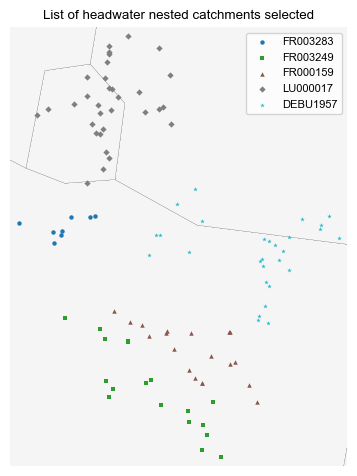

In [178]:
# Create subplots
fig, axes = plt.subplots()
# Flatten the axes array

plot_watershed_groups_from_dict(estreams_attributes_used = estreams_attributes_headwaters_moselle_dfs, figsize=(8, 6), ax=axes, 
                      title_plot='List of headwater nested catchments selected', add_legend = True, size_symbol = 10, 
                               limits_europe = False)

In [179]:
# List of keys to filter
keys_to_filter = estreams_attributes_headwaters_moselle_dfs.keys()

# Initialize an empty list to store the DataFrames
filtered_dfs_list = []

# Iterate through the list of keys and append each DataFrame to the list
for key in keys_to_filter:
    if key in estreams_attributes_headwaters_moselle_dfs:
        df = estreams_attributes_headwaters_moselle_dfs[key].copy()  # Get the DataFrame
        df['key'] = key  # Add the key as a column to keep track of the original DataFrame
        filtered_dfs_list.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(filtered_dfs_list, ignore_index=True)
combined_df

gauge_id                              gauge_name gauge_country  \
0    A812200001                                A8122000            FR   
1    A802101001                        L'Orne Ã  Ã‰tain            FR   
2    A807101001                      L'Orne Ã  Boncourt            FR   
3    A812020101           L'Yron Ã  Jarny [Droitaumont]            FR   
4    A820101001                 L'Orne Ã  Jarny [Labry]            FR   
..          ...                                     ...           ...   
100  A932215050                  L'Horn Ã  Bousseviller            FR   
101  A961205050                 La Bisten Ã  Creutzwald            FR   
102  A986201001             La Nied Allemande Ã  Varize            FR   
103  A994202001  La Nied Ã  Bouzonville et Ã  Filstroff            FR   
104    26400550                  BundespegelFremersdorf            DE   

    gauge_provider                                 river  lon_snap   lat_snap  \
0     FR_EAUFRANCE         L'Yron à Hannonville-Suzémont  5.837081  49.098776   
1     FR_EAUFRANCE                        L'Orne à Étain  5.632484  49.213610   
2     FR_EAUFRANCE                     L'Orne à Boncourt  5.830467  49.162566   
3     FR_EAUFRANCE          L'Yron à Jarny [Droitaumont]  5.876081  49.142330   
4     FR_EAUFRANCE                L'Orne à Jarny [Labry]  5.881716  49.167701   
..             ...                                   ...       ...        ...   
100   FR_EAUFRANCE                 L'Horn à Bousseviller  7.472093  49.127103   
101   FR_EAUFRANCE                La Bisten à Creutzwald  6.688894  49.225799   
102   FR_EAUFRANCE            La Nied Allemande à Varize  6.446071  49.142442   
103   FR_EAUFRANCE  La Nied à Bouzonville et à Filstroff  6.545267  49.324381   
104          DE_BU                                  Saar  6.648000  49.409000   

          lon        lat elevation  ...  lakes_tot_vol  sno_cov_mean  \
0    5.837081  49.098776       197  ...           3.61         2.131   
1    5.632484  49.213610       199  ...           1.10         2.101   
2    5.830467  49.162566       185  ...           1.40         2.060   
3    5.876081  49.142330       188  ...           3.61         2.167   
4    5.881716  49.167701       186  ...           5.01         2.142   
..        ...        ...       ...  ...            ...           ...   
100  7.472093  49.127103       265  ...           1.42         2.876   
101  6.688894  49.225799       201  ...           0.50         2.452   
102  6.446071  49.142442       204  ...           1.62         2.903   
103  6.545267  49.324381       189  ...           4.50         2.726   
104  6.648000  49.409000       NaN  ...         114.90         3.185   

     irri_1990  irri_2005 stations_num_p_mean perm_high_ff2  perm_medium_ff2  \
0        0.070      0.040                 2.0      0.000000        49.984663   
1        0.089      0.032                 1.0      0.000000        28.814132   
2        0.638      0.190                 3.0      0.000000        30.090776   
3        0.083      0.065                 2.0      0.000000        57.507079   
4        0.925      0.351                 4.0      0.000000        38.604176   
..         ...        ...                 ...           ...              ...   
100      0.000      0.002                 5.0     97.785355         0.000000   
101      0.000      0.000                 2.0     93.860251         2.539723   
102      0.040      0.052                 4.0      4.353730        46.021991   
103      0.117      0.157                 8.0      7.308442        32.066428   
104      4.261      3.796               103.0     33.169048        20.494960   

     perm_lower_ff2  perm_impermeable_ff2       key  
0         50.015337              0.000000  FR003283  
1         71.185868              0.000000  FR003283  
2         69.909224              0.000000  FR003283  
3         42.492921              0.000000  FR003283  
4         61.395824              0.000000  FR003283  
..     

In [180]:
for outlet in estreams_attributes_headwaters_moselle_dfs.keys():
    print(outlet)
    print(estreams_attributes.loc[outlet, "area_estreams"])
    print(len(estreams_attributes_headwaters_moselle_dfs[outlet]))

FR003283
1241.962
8
FR003249
3396.832
18
FR000159
2882.865
19
LU000017
4255.524
32
DEBU1957
6970.0
28


In [181]:
# Store the correlation matrices for selected catchments in a dictionary:
# Initialize an empty dictionary to store correlation DataFrames for the selected variables
correlation_dict_hw_moselle = {}

# Iterate over each variable in the first 14 columns of your data
for variable in tqdm.tqdm(estreams_attributes.columns[29:43]):
    # Initialize an empty DataFrame to store correlations
    correlation_df = pd.DataFrame()

    # Iterate over each watershed group
    for catchment in estreams_attributes_headwaters_moselle_dfs.keys():

        estreams_attributes_dfs_cat = estreams_attributes_headwaters_moselle_dfs[catchment]
        
        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep', 
       'perc_imp', 'perc_low_perm', 'perc_medium_perm', 'perc_high_perm', 
       'perm_impermeable_euro','perm_lower_euro', 'perm_medium_euro', 'perm_high_euro',
       'perm_impermeable_ff2', 'perm_lower_ff2', 'perm_medium_ff2','perm_high_ff2',
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]]
        
        # Calculate correlations between the current variable and other variables
        correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
        
        # Add the correlations to the DataFrame
        correlation_df[catchment] = correlations

    # Add the correlation DataFrame to the dictionary
    correlation_dict_hw_moselle[variable] = correlation_df

# Print the keys of the correlation dictionary
print(correlation_dict_hw_moselle.keys())

100%|██████████| 14/14 [00:00<00:00, 18.26it/s]

dict_keys(['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq'])


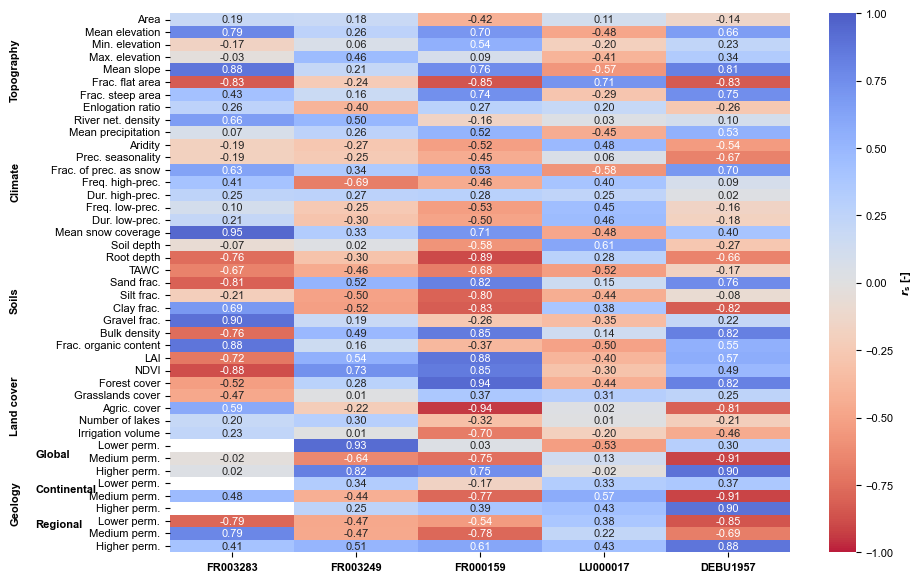

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

# baseflow_index correlations:
signature = "baseflow_index"

y_labels = ["Area", 'Mean elevation', 'Min. elevation', 'Max. elevation', 'Mean slope', 
            'Frac. flat area', 'Frac. steep area', 'Enlogation ratio', 'River net. density', 
            'Mean precipitation','Aridity', 'Prec. seasonality', 'Frac. of prec. as snow', 'Freq. high-prec.', 
            'Dur. high-prec.', 'Freq. low-prec.', 'Dur. low-prec.', 'Mean snow coverage', 
            'Soil depth', 'Root depth', 'TAWC','Sand frac.', 'Silt frac.', 'Clay frac.', 
            'Gravel frac.', 'Bulk density', 'Frac. organic content', 
            'LAI', 'NDVI', 'Forest cover', 'Grasslands cover', 'Agric. cover', 
            "Number of lakes", "Irrigation volume", 
            'Lower perm.', 'Medium perm.', 'Higher perm.',
            'Lower perm.', 'Medium perm.', 'Higher perm.',
            'Lower perm.', 'Medium perm.', 'Higher perm.']

# Desired order of indices
desired_order = ["area_estreams", 'ele_mt_mean', "ele_mt_min", "ele_mt_max", 'slp_dg_mean', 
                 'flat_area_fra', 'steep_area_fra', 'elon_ratio', 'strm_dens', 
                 'p_mean','aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'lp_freq', 
                 'lp_dur', 'sno_cov_mean', 
                 'bedrk_dep', 'root_dep_mean', 'soil_tawc_mean','soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean', 
                 'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 
                 'lai_mean', 'ndvi_mean', 'lulc_2006_forest', 'lulc_2006_grass', 'lulc_2006_agriculture', 
                 "lakes_num", "irri_2005", 
                 'perc_low_perm', 'perc_medium_perm', 'perc_high_perm',
                 'perm_lower_euro', 'perm_medium_euro', 'perm_high_euro',
                 'perm_lower_ff2','perm_medium_ff2', 'perm_high_ff2']

# Correlation DataFrame (assuming this is already prepared)
correlation_df = correlation_dict_hw_moselle[signature].loc[desired_order, :]

# Plot the heatmap
plt.figure(figsize=(10, 7))
ax = sns.heatmap(correlation_df, annot=True, cmap='coolwarm_r', fmt=".2f", vmin=-1, vmax=1, alpha=0.9)

# Set the x and y tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=8, fontweight="bold")
ax.set_yticklabels(y_labels, rotation=0, ha='right', fontsize=8)

# Customize the colorbar
colorbar = ax.collections[0].colorbar
colorbar.set_label('$r_{\mathregular{s}}$ [-]', fontsize=8)

# Set custom colors for specific labels
for label in ax.get_yticklabels():
    text = label.get_text()
    if 'global' in text:
        label.set_color('black')  # Color for 'global'
        label.set_fontweight('normal')  # Bold for 'global'

    elif 'euro' in text:
        label.set_color('black')  # Color for 'euro'
        label.set_fontweight('normal')  # Bold for 'global'

    elif 'country' in text:
        label.set_color('black')  # Color for 'country'
        label.set_fontweight('bold')  # Bold for 'global'


# Adding text outside the plot for section titles
plt.text(-0.03, 0.8, 'Topography', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.03, 0.64, 'Climate', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.03, 0.47, 'Soils', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.03, 0.32, 'Land cover', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.03, 0.18, 'Geology', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.01, 0.15, 'Regional', va='center', ha='left', rotation=0, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.01, 0.20, 'Continental', va='center', ha='left', rotation=0, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.01, 0.25, 'Global', va='center', ha='left', rotation=0, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")

# Save the figure
plt.savefig(r'results\figs\fig_heatmap_headwaters_bfi.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

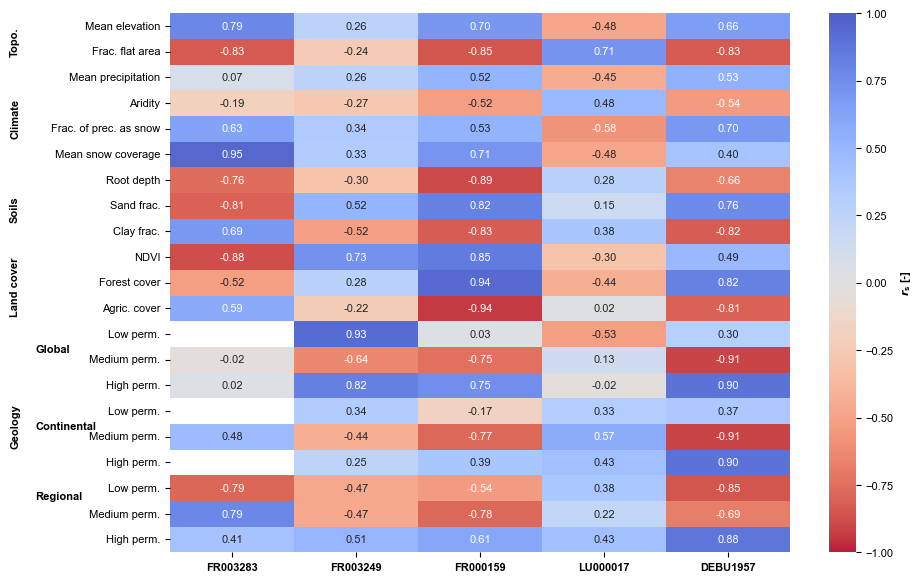

In [224]:
import matplotlib.pyplot as plt
import seaborn as sns

# baseflow_index correlations:
signature = "baseflow_index"

y_labels = ['Mean elevation', 
            'Frac. flat area',  
            'Mean precipitation','Aridity',  'Frac. of prec. as snow', 
            'Mean snow coverage', 
            'Root depth', 'Sand frac.', 'Clay frac.', 
            'NDVI', 'Forest cover', 'Agric. cover', 
            'Low perm.', 'Medium perm.', 'High perm.',
            'Low perm.', 'Medium perm.', 'High perm.',
            'Low perm.', 'Medium perm.', 'High perm.']

# Desired order of indices
desired_order = ['ele_mt_mean', 
                 'flat_area_fra', 
                 'p_mean','aridity', 'frac_snow', 'sno_cov_mean', 
                 'root_dep_mean', 'soil_fra_sand_mean', 'soil_fra_clay_mean', 
                 'ndvi_mean', 'lulc_2006_forest', 'lulc_2006_agriculture', 
                 'perc_low_perm', 'perc_medium_perm', 'perc_high_perm',
                 'perm_lower_euro', 'perm_medium_euro', 'perm_high_euro',
                 'perm_lower_ff2','perm_medium_ff2', 'perm_high_ff2']

# Correlation DataFrame (assuming this is already prepared)
correlation_df = correlation_dict_hw_moselle[signature].loc[desired_order, :]

# Plot the heatmap
plt.figure(figsize=(10, 7))
ax = sns.heatmap(correlation_df, annot=True, cmap='coolwarm_r', fmt=".2f", vmin=-1, vmax=1, alpha=0.9)

# Set the x and y tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=8, fontweight="bold")
ax.set_yticklabels(y_labels, rotation=0, ha='right', fontsize=8)

# Customize the colorbar
colorbar = ax.collections[0].colorbar
colorbar.set_label('$r_{\mathregular{s}}$ [-]', fontsize=8)

# Set custom colors for specific labels
for label in ax.get_yticklabels():
    text = label.get_text()
    if 'global' in text:
        label.set_color('black')  # Color for 'global'
        label.set_fontweight('normal')  # Bold for 'global'

    elif 'euro' in text:
        label.set_color('black')  # Color for 'euro'
        label.set_fontweight('normal')  # Bold for 'global'

    elif 'country' in text:
        label.set_color('black')  # Color for 'country'
        label.set_fontweight('bold')  # Bold for 'global'


# Adding text outside the plot for section titles
plt.text(-0.03, 0.84, 'Topo.', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.03, 0.73, 'Climate', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.03, 0.60, 'Soils', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.03, 0.49, 'Land cover', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.03, 0.29, 'Geology', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.01, 0.19, 'Regional', va='center', ha='left', rotation=0, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.01, 0.29, 'Continental', va='center', ha='left', rotation=0, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.01, 0.40, 'Global', va='center', ha='left', rotation=0, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")

# Save the figure
plt.savefig(r'results\figs\fig_heatmap_headwaters_bfi_reduced.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Boxplots for sub-catchments

In [294]:
def plot_boxplots_for_columns(data_dict, columns, n_cols=5):
    """
    Plots boxplots for a list of columns against multiple DataFrames.

    Parameters:
    data_dict (dict): Dictionary containing DataFrames.
    columns (list of str): List of column names to create boxplots for.
    n_cols (int, optional): Number of columns in the subplot grid. Default is 5.
    """
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6 * n_rows))

    for idx, column in enumerate(columns):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        combined_df = pd.concat(
            [df[[column]].assign(DataFrame=name) for name, df in data_dict.items()],
            axis=0
        )

        sns.boxplot(x='DataFrame', y=column, data=combined_df, ax=ax)
        ax.set_xlabel('DataFrame')
        ax.set_ylabel(column)
        ax.set_title(f'Boxplot of {column}')
    
    # Remove empty subplots
    for idx in range(len(columns), n_rows * n_cols):
        fig.delaxes(axes.flatten()[idx])
        
    plt.tight_layout()
    plt.show()


In [295]:
columns = ['p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur',
       'lp_freq', 'lp_dur', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep', 'perc_imp',
       'perc_low_perm', 'perc_medium_perm', 'perc_high_perm', 'perm_high_euro',
       'perm_medium_euro', 'perm_lower_euro', 'perm_impermeable_euro',
       'root_dep_mean', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture',
       'sno_cov_mean',
       'perm_mos_ff', 'semiperm_mos_ff', 'imper_mos_ff']

In [296]:
for key, df in estreams_attributes_headwaters_moselle_dfs.items():
    df['range_elev'] = df['ele_mt_max'] - df['ele_mt_min']
    df['perm_low'] = df['perm_lower_ff2'] + df['perm_impermeable_ff2']
    df['perm_high'] = df['perm_medium_ff2'] + df['perm_high_ff2']

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

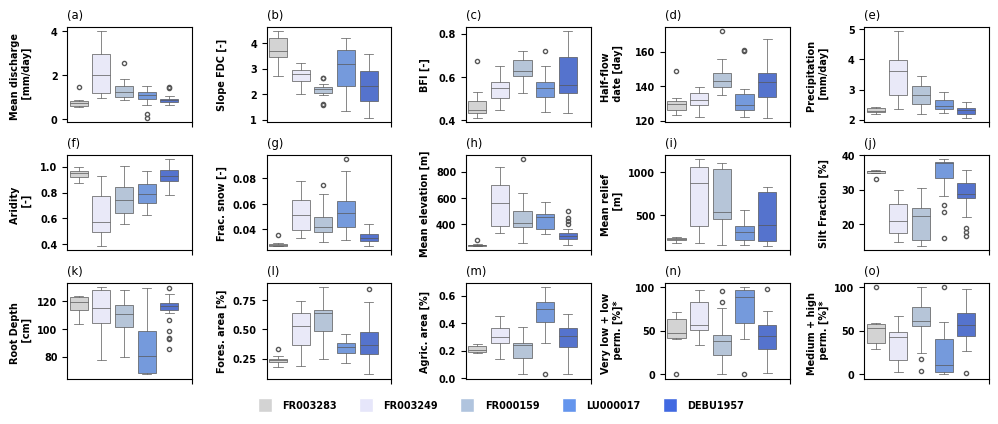

In [308]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# List of columns to plot
columns = ["q_mean", "slope_sawicz", 'baseflow_index', "hfd_mean", "p_mean", "aridity", "frac_snow", "ele_mt_mean", "range_elev", "soil_fra_silt_mean", "root_dep_mean", "lulc_2006_forest", "lulc_2006_Agric", "perm_low", "perm_high"]

# Define custom y-labels for each plot (you can customize this list)
y_labels = ["Mean discharge \n [mm/day]", "Slope FDC [-]", "BFI [-]", "Half-flow \n date [day]", "Precipitation \n [mm/day]", "Aridity \n [-]", "Frac. snow [-]","Mean elevation [m]", "Mean relief \n [m]", 
            "Silt Fraction [%]", "Root Depth \n [cm]", "Fores. area [%]", "Agric. area [%]", "Very low + low \n perm. [%]*", "Medium + high \n perm. [%]*"]

# Number of columns in the grid
n_cols = 5
data_dict = estreams_attributes_headwaters_moselle_dfs

# Number of rows and columns for subplots
n_rows = (len(columns) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4))

# Define custom colors for each DataFrame
custom_colors = {
    'FR003283': 'lightgray',
    'FR003249': 'lavender',
    'FR000159': 'lightsteelblue',
    'LU000017': 'cornflowerblue',
    "DEBU1957": "royalblue"
}

# Titles with (a), (b), (c), etc.
subplot_titles = [f"({chr(97 + i)})" for i in range(len(columns))]
# Set the properties for the outliers
flierprops = dict(marker='o', color='black', markersize=3)

for idx, column in enumerate(columns):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    # Combine the DataFrames into one for plotting
    combined_df = pd.concat(
        [df[[column]].assign(DataFrame=name) for name, df in data_dict.items()],
        axis=0
    )

    # Create the boxplot with custom colors for each DataFrame
    sns.boxplot(x='DataFrame', y=column, data=combined_df, ax=ax, palette=custom_colors, linewidth=0.5,  # No edge colors
                flierprops=flierprops  # Set smaller outliers
               )
    
    ax.set_xticks('')
    ax.set_xlabel('')
    ax.set_ylabel(y_labels[idx])
    ax.set_title(subplot_titles[idx], loc="left")

# Remove any empty subplots
for idx in range(len(columns), n_rows * n_cols):
    fig.delaxes(axes.flatten()[idx])

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10, label=name) 
           for name, color in custom_colors.items()]

# Add the legend below the plot, horizontal, in one single line
fig.legend(handles=handles, title='', loc='lower center', bbox_to_anchor=(0.5, -0.05), 
           ncol=len(custom_colors), frameon=False, prop={'weight': 'bold'})  # Set the title to bold

fig.align_ylabels()


plt.tight_layout(rect=[0, 0.01, 1, 1])  # Adjust layout to make space for the legend


fig.savefig(r'results\figs\fig_boxplots.png', dpi=300, bbox_inches='tight')


plt.show()


# Colorfull histograms

In [50]:
moselle_del = gpd.read_file('../estreams_part_b/data/gis/moselle_delienation.shp')
river_moselle = gpd.read_file('../estreams_part_b/data/gis/river_merit_moselle_clipped_dissolved.shp')

In [51]:
# List of keys to filter
keys_to_filter = estreams_attributes_dfs.keys()

# Initialize an empty list to store the DataFrames
filtered_dfs_list = []

# Iterate through the list of keys and append each DataFrame to the list
for key in keys_to_filter:
    if key in estreams_attributes_dfs:
        df = estreams_attributes_dfs[key].copy()  # Get the DataFrame
        df['key'] = key  # Add the key as a column to keep track of the original DataFrame
        filtered_dfs_list.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(filtered_dfs_list, ignore_index=True)

network_estreams_filtered = combined_df.copy()
network_estreams_filtered = network_estreams_filtered[network_estreams_filtered.end_date >= "2009"]
network_estreams_filtered

gauge_id     gauge_name gauge_country  gauge_provider      river  \
0    99141002        Reuland            BE          BE_SPW        Our   
1    99261002     Schoenberg            BE          BE_SPW        Our   
2    56100000     Martelange            BE          BE_SPW       Sure   
3    60800000        Reuland            BE          BE_SPW        Ulf   
4    60900000  Lommersweiler            BE          BE_SPW  Braunlauf   
..        ...            ...           ...             ...        ...   
147        34       Michelau            LU  LU_CONTACTFORM       Sure   
148         3    Pfaffenthal            LU  LU_CONTACTFORM    Alzette   
149        16        Rosport            LU  LU_CONTACTFORM       Sure   
150         5     Schoenfels            LU  LU_CONTACTFORM      Mamer   
151        12        Vianden            LU  LU_CONTACTFORM        Our   

     lon_snap   lat_snap       lon        lat elevation  ...  lakes_tot_vol  \
0    6.151802  50.188258  6.151802  50.188258       NaN  ...           0.00   
1    6.263467  50.289277  6.263467  50.289277       NaN  ...           0.00   
2    5.739269  49.833704  5.739269  49.833704       NaN  ...           0.00   
3    6.150669  50.196522  6.150669  50.196522       NaN  ...           0.00   
4    6.153292  50.235014  6.153955  50.234494       NaN  ...           0.00   
..        ...        ...       ...        ...       ...  ...            ...   
147  6.091178  49.895421  6.091178  49.895421       NaN  ...          62.62   
148  6.132266  49.620647  6.132266  49.620647       NaN  ...           0.00   
149  6.509851  49.785883  6.509851  49.785883       NaN  ...          67.85   
150  6.100795  49.723112  6.100795  49.723112       NaN  ...           0.00   
151  6.204738  49.939224  6.204738  49.939224       NaN  ...           0.00   

     sno_cov_mean  irri_1990  irri_2005 stations_num_p_mean perm_high_regi  \
0           7.497      1.400      3.429                16.0       2.947531   
1           8.920      0.000      0.075                 8.0       2.347625   
2           6.106      0.000      0.000                 6.0       0.005000   
3           7.096      1.200      2.427                 9.0       0.000000   
4           6.996      0.200      0.605                 6.0       3.999021   
..            ...        ...        ...                 ...            ...   
147         5.680      0.045      0.045                25.0       1.917023   
148         2.863      0.004      0.009                15.0      14.327884   
149         4.753      1.641      4.770                78.0      18.753136   
150         3.184      0.015      0.015                17.0      39.499138   
151         6.627      1.495      3.524                27.0       3.530352   

     perm_medium_regi  perm_low_regi  perm_verylow_regi       key  
0            0.000000       3.319025          93.733444  DEBU1959  
1            0.000000       0.000000          97.652375  DEBU1959  
2            0.000000       0.000000          99.995000  DEBU1959  
3            0.000000       0.000000         100.000000  DEBU1959  
4            0.000000      15.492765          80.508214  DEBU1959  
..                ...            ...                ...       ...  
147          0.000000       0.000000          98.082977  DEBU1959  
148         32.255374      53.416742           0.000000  DEBU1959  
149          5.872553      24.977481          50.396831  DEBU1959  
150          0.000000      60.500862           0.000000  DEBU1959  
151          2.493791       1.855134          92.120723  DEBU1959  

[135 rows x 124 columns]

In [246]:
color_categories_range_df = network_estreams_filtered.copy()

# Defining the colour categories and mapping lists
color_categories_q_mean = [(color_categories_range_df.q_mean.min(), 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, np.inf)]
color_categories_q_runoff_ratio = [(color_categories_range_df.q_runoff_ratio.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_q_elas_Sankarasubramanian = [(0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, 2.5), (2.5, np.inf)]
color_categories_slope_sawicz = [(-np.inf, 1.5), (1.5, 2.0), (2.0, 2.5), (2.5, 3.0), (3.0, np.inf)]
color_categories_baseflow_index = [(0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, np.inf)]
color_categories_hfd_mean = [(color_categories_range_df.hfd_mean.min(), 130), (130, 140), (140, 150), (150, 160), (160, np.inf)]
color_categories_q_5 = [(color_categories_range_df.q_5.min(), 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, np.inf)]
color_categories_q_95 = [(color_categories_range_df.q_95.min(), 2.0), (2.0, 4.0), (4.0, 6.0), (6.0, 8.0), (8.0, np.inf)]
color_categories_hq_freq = [(color_categories_range_df.hq_freq.min(), 10), (10, 15), (15, 20), (20, 25), (25, np.inf)]
color_categories_hq_dur = [(color_categories_range_df.hq_dur.min(), 2), (2, 3), (3, 4), (4, 5), (5, np.inf)]
color_categories_lq_freq = [(color_categories_range_df.lq_freq.min(), 25), (25, 50), (50, 75), (75, 100), (100, np.inf)]
color_categories_lq_dur = [(color_categories_range_df.lq_dur.min(), 5), (5, 10), (10, 15), (15, 20), (20, np.inf)]
color_categories_p_mean = [(color_categories_range_df.p_mean.min(), 2.5), (2.5, 3.0), (3, 3.5), (3.5, 4), (4, np.inf)]
color_categories_pet_mean = [(1.7, 1.8), (1.8, 1.9), (1.9, 2.0), (2.0, 2.1), (2.1, np.inf)]
color_categories_aridity = [(color_categories_range_df.aridity.min(), 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, np.inf)]
color_categories_p_seasonality = [(color_categories_range_df.p_seasonality.min(), -0.2), (-0.2, -0.1), (-0.1, 0), (0, 0.1), (0.1, np.inf)]
color_categories_frac_snow = [(color_categories_range_df.frac_snow.min(), 0.05), (0.05, 0.1), (0.1, 0.15), (0.15, 0.2), (0.2, np.inf)]
color_categories_hp_freq = [(color_categories_range_df.hp_freq.min(), 14), (14, 15), (15, 16), (16, 17), (17, np.inf)]
color_categories_hp_dur = [(color_categories_range_df.hp_dur.min(), 1.16), (1.16, 1.18), (1.18, 1.2), (1.2, 1.22), (1.22, np.inf)]
color_categories_lp_freq = [(color_categories_range_df.lp_freq.min(), 205), (205, 210), (210,215), (215, 220), (220, np.inf)]
color_categories_lp_dur = [(color_categories_range_df.lp_dur.min(), 3.7), (3.7, 3.8), (3.8, 3.9), (3.9, 4), (4, np.inf)]
color_categories_ele_mt_max = [(color_categories_range_df.ele_mt_max.min(), 1000), (1000, 2000), (2000, 3000), (3000, 4000), (4000, np.inf)]
color_categories_ele_mt_mean = [(color_categories_range_df.ele_mt_mean.min(), 300), (300, 400), (400, 500), (500, 600), (600, np.inf)]
color_categories_slp_dg_mean = [(color_categories_range_df.slp_dg_mean.min(), 5), (5, 7.5), (7.5, 10), (10, 12.5), (12.5, np.inf)]
color_categories_elon_ratio = [(color_categories_range_df.elon_ratio.min(), 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, np.inf)]
color_categories_flat_area_fra = [(color_categories_range_df.flat_area_fra.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_steep_area_fra = [(color_categories_range_df.steep_area_fra.min(), 10), (10, 25), (25, 40), (40, 55), (55, np.inf)]
color_categories_strm_dens = [(color_categories_range_df.strm_dens.min(), 0.1), (0.1, 0.125), (0.125, 0.15), (0.15, 0.175), (0.175, np.inf)]
color_categories_bedrk_dep = [(color_categories_range_df.bedrk_dep.min(), 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, np.inf)]
color_categories_perc_imp = [(color_categories_range_df.perc_imp.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_perc_low_perm = [(color_categories_range_df.perc_low_perm.min(), 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]
color_categories_perc_medium_perm = [(color_categories_range_df.perc_medium_perm.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_perc_high_perm = [(color_categories_range_df.perc_high_perm.min(), 2.5), (2.5, 5), (5, 7.5), (7.5, 10), (10, np.inf)]

color_categories_perm_high_euro = [(color_categories_range_df.perm_high_euro.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_perm_medium_euro = [(color_categories_range_df.perm_medium_euro.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_perm_lower_euro = [(color_categories_range_df.perm_lower_euro.min(), 5), (5, 10), (10, 15), (15, 20), (20, np.inf)]
color_categories_perm_impermeable_euro = [(color_categories_range_df.perm_impermeable_euro.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]

color_categories_perm_mos_ff = [(-np.nan, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_imper_mos_ff = [(-np.nan, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_semiperm_mos_ff = [(-np.nan, 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]

color_categories_root_dep_mean = [(color_categories_range_df.root_dep_mean.min(), 80), (80, 90), (90, 100), (100, 110), (110, np.inf)]
color_categories_soil_tawc_mean = [(color_categories_range_df.soil_tawc_mean.min(), 45), (45, 47), (47, 49), (49, 52), (52, np.inf)]
color_categories_soil_fra_sand_mean = [(color_categories_range_df.soil_fra_sand_mean.min(), 30), (30, 40), (40, 50), (50, 60), (60, np.inf)]
color_categories_soil_fra_silt_mean = [(color_categories_range_df.soil_fra_silt_mean.min(), 15), (15, 20), (20, 25), (25, 30), (30, np.inf)]
color_categories_soil_fra_clay_mean = [(color_categories_range_df.soil_fra_clay_mean.min(), 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]
color_categories_soil_fra_grav_mean = [(color_categories_range_df.soil_fra_grav_mean.min(), 6), (6, 7), (7, 8), (8, 9), (9, np.inf)]
color_categories_soil_oc_mean = [(color_categories_range_df.soil_oc_mean.min(), 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, np.inf)]
color_categories_lai_mean = [(color_categories_range_df.lai_mean.min(), 0.16), (0.16, 0.18), (0.18, 0.2), (0.2, 0.22), (0.22, np.inf)]
color_categories_ndvi_mean = [(color_categories_range_df.ndvi_mean.min(), 0.6), (0.6, 0.64), (0.64, 0.68), (0.68, 0.72), (0.72, np.inf)]
color_categories_lulc_2006_urban = [(color_categories_range_df.lulc_2006_urban.min(), 0.05), (0.05, 0.1), (0.1, 0.15), (0.15, 0.2), (0.2, np.inf)]
color_categories_lulc_2006_NonIrriAgri = [(color_categories_range_df.lulc_2006_NonIrriAgri.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_Agric = [(color_categories_range_df.lulc_2006_Agric.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_forest = [(color_categories_range_df.lulc_2006_forest.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_grass = [(color_categories_range_df.lulc_2006_grass.min(), 0.05), (0.05, 0.075), (0.075, 0.1), (0.1, 0.125), (0.125, np.inf)]
color_categories_lulc_2006_agriculture = [(color_categories_range_df.lulc_2006_agriculture.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_sno_cov_mean = [(color_categories_range_df.sno_cov_mean.min(), 3), (3, 5), (5, 7), (7, 9), (9, np.inf)]
color_categories_dam_num = [(color_categories_range_df.dam_num.min(), 0), (0, 1), (1, 2), (2, 3), (3, np.inf)]
color_categories_lakes_num = [(color_categories_range_df.lakes_num.min(), 0), (0, 1), (1, 2), (2, 3), (3, np.inf)]
color_categories_area = [(color_categories_range_df.area_estreams.min(), 100), (100, 250), (250, 500), (500, 1000), (1000, np.inf)]

color_categories_num_years = [(-np.inf, 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]

# Color mapping list
color_mapping_list = {
    "q_mean":  generate_legend_and_color_mapping("Q [mm/day]", color_categories_q_mean, 0, 10, 1, 10, color_palette='blues'),
    "q_runoff_ratio": generate_legend_and_color_mapping("Q/P [-]", color_categories_q_runoff_ratio, 0, 2, 0.5, 10),
    "q_elas_Sankarasubramanian": generate_legend_and_color_mapping("Q-Elasticity [-]", color_categories_q_elas_Sankarasubramanian, -2, 5, 1, 10),
    "slope_sawicz": generate_legend_and_color_mapping("FDC-Slope[-]", color_categories_slope_sawicz, 0, 10, 0.5, 10),
    "baseflow_index": generate_legend_and_color_mapping("BFI [-]", color_categories_baseflow_index, 0, 1, 0.2, 10),
    "hfd_mean": generate_legend_and_color_mapping("HFD [day]", color_categories_hfd_mean, 100, 300, 50, 10),
    "q_5":  generate_legend_and_color_mapping("Q5 [mm/day]", color_categories_q_5, 0, 2, 0.25, 10, color_palette='blues'),
    "q_95":  generate_legend_and_color_mapping("Q95 [mm/day]", color_categories_q_95, 0, 20, 2, 10, color_palette='blues'),
    "hq_freq":  generate_legend_and_color_mapping("HQ freq. [days/year]", color_categories_hq_freq, 0, 100, 1, 10),
    "hq_dur":  generate_legend_and_color_mapping("HQ dur. [days]", color_categories_hq_dur, 0, 30, 1, 10),
    "lq_freq":  generate_legend_and_color_mapping("LQ freq. [day/year]", color_categories_lq_freq, 0, 350, 50, 10, color_palette='custom'),
    "lq_dur":  generate_legend_and_color_mapping("LQ dur. [days]", color_categories_lq_dur, 0, 150, 1, 10, color_palette='custom'),
    "p_mean":  generate_legend_and_color_mapping("P [mm/day]", color_categories_p_mean, 0, 10, 1, 10, color_palette='blues'),
    "pet_mean":  generate_legend_and_color_mapping("PET [mm/day]", color_categories_pet_mean, 0, 10, 1, 10, color_palette='custom'),
    "aridity": generate_legend_and_color_mapping("Aridity [-]", color_categories_aridity, 0, 5, 1, 10, color_palette='custom'),
    "p_seasonality":  generate_legend_and_color_mapping("P-Seasonality [-]", color_categories_p_seasonality, 0, 10, 1, 10, color_palette='default'),
    "frac_snow":  generate_legend_and_color_mapping("Snow frac. [-]", color_categories_frac_snow, 0, 10, 1, 10, color_palette='default'),
    "hp_freq":  generate_legend_and_color_mapping("HP freq. [days/year]", color_categories_hp_freq, 0, 10, 1, 10, color_palette='default'),
    "hp_dur": generate_legend_and_color_mapping("HP dur. [days]", color_categories_hp_dur, 0, 5, 1, 10, color_palette='default'),
    "lp_freq":  generate_legend_and_color_mapping("LP freq. [days/year]", color_categories_lp_freq, 0, 10, 0.2, 10, color_palette='default'),
    "lp_dur":  generate_legend_and_color_mapping("LP dur. [days]", color_categories_lp_dur, 0, 10, 1, 10, color_palette='default'),
    "ele_mt_max":  generate_legend_and_color_mapping("Elev-max [m]", color_categories_ele_mt_max, 0, 10, 1, 10, color_palette='default'),
    "ele_mt_mean":  generate_legend_and_color_mapping("Mean elev. [m]", color_categories_ele_mt_mean, 0, 10, 1, 10, color_palette='default'),
    "slp_dg_mean":  generate_legend_and_color_mapping("Mean slope [d]", color_categories_slp_dg_mean, 0, 10, 1, 10, color_palette='default'),
    "elon_ratio":  generate_legend_and_color_mapping("Elon. ratio [-]", color_categories_elon_ratio, 0, 10, 1, 10, color_palette='default'),
    "flat_area_fra":  generate_legend_and_color_mapping("Flat area [-]", color_categories_flat_area_fra, 0, 10, 1, 10, color_palette='default'),
    "steep_area_fra":  generate_legend_and_color_mapping("Steep area [-]", color_categories_steep_area_fra, 0, 10, 1, 10, color_palette='default'),
    "strm_dens":  generate_legend_and_color_mapping("Strm dens. [-]", color_categories_strm_dens, 0, 10, 1, 10, color_palette='default'),
    "bedrk_dep":  generate_legend_and_color_mapping("Bedrock depth [m]", color_categories_bedrk_dep, 0, 10, 1, 10, color_palette='custom'),        
    "perc_low_perm":  generate_legend_and_color_mapping("Low perm. LR [%]", color_categories_perc_low_perm, 0, 10, 1, 10, color_palette='default'),
    "perc_medium_perm":  generate_legend_and_color_mapping("Medium perm. LR [%]", color_categories_perc_medium_perm, 0, 10, 1, 10, color_palette='default'),
    "perc_high_perm":  generate_legend_and_color_mapping("High perm. LR [%]", color_categories_perc_high_perm, 0, 10, 1, 10, color_palette='default'),
    "perc_imp":  generate_legend_and_color_mapping("Impe. LR [%]", color_categories_perc_imp, 0, 10, 1, 10, color_palette='default'),
    "perm_mos_ff":  generate_legend_and_color_mapping("Perm. HR [%]", color_categories_perm_mos_ff, 0, 10, 1, 10, color_palette='default'),
    "semiperm_mos_ff":  generate_legend_and_color_mapping("Semi. HR [%]", color_categories_semiperm_mos_ff, 0, 10, 1, 10, color_palette='default'),
    "imper_mos_ff":  generate_legend_and_color_mapping("Impe. HR [%]", color_categories_imper_mos_ff, 0, 10, 1, 10, color_palette='default'),
    
    "perm_impermeable_euro":  generate_legend_and_color_mapping("Impe. MR [%]", color_categories_perm_impermeable_euro, 0, 10, 1, 10, color_palette='default'),
    "perm_lower_euro":  generate_legend_and_color_mapping("Low perm. MR [%]", color_categories_perm_lower_euro, 0, 10, 1, 10, color_palette='default'),
    "perm_medium_euro":  generate_legend_and_color_mapping("Medium perm. MR [%]", color_categories_perm_medium_euro, 0, 10, 1, 10, color_palette='default'),
    "perm_high_euro":  generate_legend_and_color_mapping("High perm. MR [%]", color_categories_perm_high_euro, 0, 10, 1, 10, color_palette='default'),


    "root_dep_mean":  generate_legend_and_color_mapping("Root depth [cm]", color_categories_root_dep_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_tawc_mean":  generate_legend_and_color_mapping("TAWC [cm]", color_categories_soil_tawc_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_sand_mean":  generate_legend_and_color_mapping("Sand [%]", color_categories_soil_fra_sand_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_silt_mean":  generate_legend_and_color_mapping("Silt [%]", color_categories_soil_fra_silt_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_clay_mean":  generate_legend_and_color_mapping("Clay [%]", color_categories_soil_fra_clay_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_grav_mean":  generate_legend_and_color_mapping("Gravel [%]", color_categories_soil_fra_grav_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_oc_mean":  generate_legend_and_color_mapping("OC [%]", color_categories_soil_oc_mean, 0, 10, 1, 10, color_palette='default'),
    "lai_mean":  generate_legend_and_color_mapping("LAI [-]", color_categories_lai_mean, 0, 10, 1, 10, color_palette='vegetation'),
    "ndvi_mean":  generate_legend_and_color_mapping("NDVI [-]", color_categories_ndvi_mean, 0, 10, 1, 10, color_palette='vegetation'),
    "lulc_2006_urban":  generate_legend_and_color_mapping("Urban [-]", color_categories_lulc_2006_urban, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_NonIrriAgri":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_NonIrriAgri, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_Agric":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_Agric, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_forest":  generate_legend_and_color_mapping("Forests [-]", color_categories_lulc_2006_forest, 0, 10, 1, 10, color_palette='vegetation'),
    "lulc_2006_grass":  generate_legend_and_color_mapping("Grasslands [-]", color_categories_lulc_2006_grass, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_agriculture":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_agriculture, 0, 10, 1, 10, color_palette='custom'),
    "sno_cov_mean":  generate_legend_and_color_mapping("Snow cover [%]", color_categories_sno_cov_mean, 0, 10, 1, 10, color_palette='default'),
    "dam_num":  generate_legend_and_color_mapping("Dams [-]", color_categories_dam_num, 0, 10, 1, 10, color_palette='default'),
    "lakes_num":  generate_legend_and_color_mapping("Lakes [-]", color_categories_lakes_num, 0, 10, 1, 10, color_palette='default'),
    "area_estreams":  generate_legend_and_color_mapping("Area [km2]", color_categories_area, 0, 10, 1, 10, color_palette='default'),
    "num_years":  generate_legend_and_color_mapping("Number of years [-]", color_categories_num_years, 0, 10, 1, 10, color_palette='blues'),

}

def plot_variable_subplot(ax, variable, estreams_attributes, color_mapping_list, gdf, total_bins=20):
    """
    Plot a variable on a subplot along with its legend and histogram, ensuring correct bin edges from color_mapping
    and equal-width bins.

    Parameters:
        ax (matplotlib Axes): Subplot axes.
        variable (str): Name of the variable.
        estreams_attributes (DataFrame): DataFrame containing attribute data.
        color_mapping_list (dict): Dictionary containing color mapping information.
        gdf (GeoDataFrame): GeoDataFrame for plotting shapefile.
        total_bins (int): Total number of bins for the histogram (ensuring equal width).

    Returns:
        None
    """
    # Extract color mapping information from the color mapping list
    legend_title = color_mapping_list[variable][0]
    color_categories = color_mapping_list[variable][1]
    legend_labels = color_mapping_list[variable][2]
    color_mapping = color_mapping_list[variable][3]

    # Determine the min and max values from the data
    data_min = estreams_attributes[variable].min()
    data_max = estreams_attributes[variable].max()

    # Create uniform bin edges
    hist_bins = np.linspace(data_min, data_max, total_bins + 1)

    # Set the background color to white
    ax.set_facecolor('white')

    # Plot the shapefile with white facecolor and black boundaries
    gdf.plot(ax=ax, facecolor='none', edgecolor='none', linewidth=0.2)
    ax.set_xlim(4.5, 8)
    ax.set_ylim(47.5, 50.5)

    # Plot the data on the map
    plot_num_measurementsmap_subplot(plotsome=estreams_attributes, xcoords="lon", ycoords="lat", column_labels=variable,
                                     color_categories=color_categories, color_mapping=color_mapping, 
                                     legend_title=legend_title, legend_labels=legend_labels, legend_loc='lower left', ax=ax, 
                                     set_map_limits=True, minx=4.5, miny=47.5, maxx=8, maxy=50.5, show_legend=False, 
                                     legend_outside=False, north_arrow=False, markersize_map=10)

    # Turn off both x-axis and y-axis
    ax.set_axis_off()

    # Create a histogram inset axis within the subplot
    hist_ax = ax.inset_axes([0.05, 0.15, 0.3, 0.175])  # Adjust the values as needed

    # Extract the data for the histogram
    hist_data = estreams_attributes[variable].dropna()

    # Plot the histogram with manually controlled uniform bins
    counts, bins, patches = hist_ax.hist(hist_data, bins=hist_bins, color='white', edgecolor='black', alpha=0.7, linewidth=0.4)

    # Assign colors based on color_categories to the bins
    for patch, bin_left, bin_right in zip(patches, bins[:-1], bins[1:]):
        # Iterate through color categories and check if the bin falls within the category
        for low, high in color_categories:
            if low <= bin_left < high:
                patch.set_facecolor(color_mapping[f'{low}-{high}'])
                break
        # For bins beyond the last threshold, use the color for the last defined category
        if bin_left >= color_categories[-1][0]:
            patch.set_facecolor(color_mapping[f'{color_categories[-1][0]}-{np.inf}'])

    # Hide the axis spines and ticks for the inset axis
    hist_ax.spines['top'].set_visible(False)
    hist_ax.spines['right'].set_visible(False)
    hist_ax.spines['left'].set_visible(True)
    hist_ax.spines['bottom'].set_visible(True)
    hist_ax.set_facecolor('none')
    hist_ax.set_yticklabels(hist_ax.get_yticks(), rotation=90, fontsize=8)

    # Get the x-axis limits
    x_min, x_max = hist_ax.get_xlim()

    # Compute the midpoint of the x-axis
    middle_tick = (x_min + x_max) / 2

    # Set x-ticks to show only the middle tick
    hist_ax.set_xticks([middle_tick])

    # Set the label for the middle tick
    hist_ax.set_xticklabels([f'{middle_tick:.1f}'], fontsize=7, fontweight="bold")

    hist_ax.set_ylabel("Count", fontsize=7, fontweight="bold")

    # Set custom y-axis ticks to show automatically but label only the middle one
    y_ticks = hist_ax.get_yticks()
    mid_tick = y_ticks[len(y_ticks) // 2]
    hist_ax.set_yticks([mid_tick])  # Set only the middle tick
    hist_ax.set_yticklabels([f'{mid_tick:.0f}'], fontsize=7, fontweight="bold")

    # Call the function to add a circular legend
    add_circular_legend(ax, color_mapping, legend_labels, legend_title="")

    # Adjust aspect ratio
    ax.set_aspect('equal')

    # Hide spines for the main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


def plot_num_measurementsmap_subplot(ax, plotsome: pd.DataFrame, xcoords="lon", ycoords="lat", column_labels="num_yearly_complete",
                                     crsproj='epsg:4326', showcodes=False, markersize_map=3, north_arrow=True, 
                                     set_map_limits=False, minx=0, miny=0, maxx=1, maxy=1, color_categories=None, color_mapping=None,
                                     legend_title=None, legend_labels=None, legend_loc='upper left', show_legend = True, 
                                     legend_outside=True, legend_bbox_to_anchor=(0.5, 1)):  # Add legend_outside and legend_bbox_to_anchor parameters:
    """
    Plot data on a subplot with additional options.

    Parameters:
        ax (matplotlib.axes.Axes): The subplot where the data will be plotted.
        plotsome (pd.DataFrame): The data to be plotted.
        xcoords (str): The name of the column containing x-coordinates.
        ycoords (str): The name of the column containing y-coordinates.
        column_labels (str): The name of the column containing data for coloring.
        crsproj (str): The coordinate reference system (CRS) for the data.
        showcodes (bool): Whether to show data labels.
        markersize_map (int): Size of the markers.
        north_arrow (bool): Whether to include a north arrow.
        set_map_limits (bool): Whether to set specific map limits.
        minx (float): Minimum x-axis limit.
        miny (float): Minimum y-axis limit.
        maxx (float): Maximum x-axis limit.
        maxy (float): Maximum y-axis limit.
        color_categories (list): List of color categories for data bins.
        color_mapping (dict): Mapping of color categories to colors.
        legend_title (str): Title for the legend.
        legend_labels (list): Labels for the legend items.
        legend_loc (str): Location of the legend.
        show_legend (bool): Whether to display the legend.
        legend_outside (bool): Whether to place the legend outside the plot.
        legend_bbox_to_anchor (tuple): Position of the legend (x, y).

    Returns:
        None
    """
    # Prepare the data for plotting
    crs = {'init': crsproj}
    geometry = plotsome.apply(lambda row: Point(row[xcoords], row[ycoords]), axis=1)
    geodata = gpd.GeoDataFrame(plotsome, crs=crs, geometry=geometry)
    geodatacond = geodata

    if color_categories is not None and color_mapping is not None:
        geodatacond['color_category'] = pd.cut(geodatacond[column_labels], bins=[c[0] for c in color_categories] + [np.inf], labels=[f'{c[0]}-{c[1]}' for c in color_categories])
    else:
        raise ValueError("Both color_categories and color_mapping must be provided.")

    # Plotting and legend:
    for category, group in geodatacond.groupby('color_category'):
        #group.plot(ax=ax, color=color_mapping[category], markersize=markersize_map, legend=False, label=category)
        group.plot(ax=ax, marker='o', color=color_mapping[category], markersize=markersize_map, legend=False, label=category, edgecolor='none')
    
    if showcodes == True:
        geodatacond["Code"] = geodatacond.index
        geodatacond.plot(column='Code', ax=ax)
        for x, y, label in zip(geodatacond.geometry.x, geodatacond.geometry.y, geodatacond.index):
            ax.annotate(label, xy=(x, y), xytext=(1, 1), textcoords="offset points")
        plt.rcParams.update({'font.size': 8})

    if set_map_limits == False:
        total_bounds = geodatacond.total_bounds
        minx, miny, maxx, maxy = total_bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)

    # Plot the legend
    if legend_labels is None:
        legend_labels = [f'{c[0]}-{c[1]}' for c in color_categories]
        
    if show_legend:
        if legend_outside:
            legend = ax.legend(title=legend_title, labels=legend_labels, loc='upper left', bbox_to_anchor=legend_bbox_to_anchor,
                               bbox_transform=ax.transAxes, frameon=False)  # Use bbox_transform to position the legend
        else:
            legend = ax.legend(title=legend_title, labels=legend_labels, loc=legend_loc, frameon=False)
            
        if legend_outside:
            ax.add_artist(legend)
            
    # Plot the north arrow:
    if north_arrow == True:
        x, y, arrow_length = 0.975, 0.125, 0.1

        ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
                    arrowprops=dict(facecolor='black', width=5, headwidth=15),
                    ha='center', va='center', fontsize=18,
                    xycoords='axes fraction')
  
    # Set font family and size using rcParams
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['font.size'] = 7  # You can adjust this value as needed
    
from matplotlib.lines import Line2D
import matplotlib as mpl
import math
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=Warning)

def add_circular_legend(ax, color_mapping, legend_labels, legend_title):
    """
    Add a circular legend to the specified axes.

    Parameters:
        ax (matplotlib.axes.Axes): The axes to which the legend will be added.
        color_mapping (dict): A dictionary mapping legend labels to colors.
        legend_labels (list): List of legend labels.
        legend_title (str): Title for the legend.

    Returns:
        None
    """
    handles = [Line2D([0], [0], marker='o', color='none', markerfacecolor=color_mapping[key], markeredgecolor='none', markersize=7) for key in color_mapping]
    legend = ax.legend(handles, legend_labels, loc='upper left', bbox_to_anchor=(1, 1), title=legend_title)
    legend.get_frame().set_linewidth(0)  # Remove legend frame
    legend.get_frame().set_facecolor('none')  # Remove legend background
    legend.set_bbox_to_anchor((-0.05, 0.8))  # Adjust legend position

In [247]:
# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'helvetica'  # Change the font family
mpl.rcParams['font.size'] = 6          # Change the font size
mpl.rcParams['font.weight'] = 'bold'  # Change font weight (e.g., 'bold', 'normal')
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight (e.g., 'bold', 'normal')

In [251]:
#network_estreams_filtered.lq_dur.hist()

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

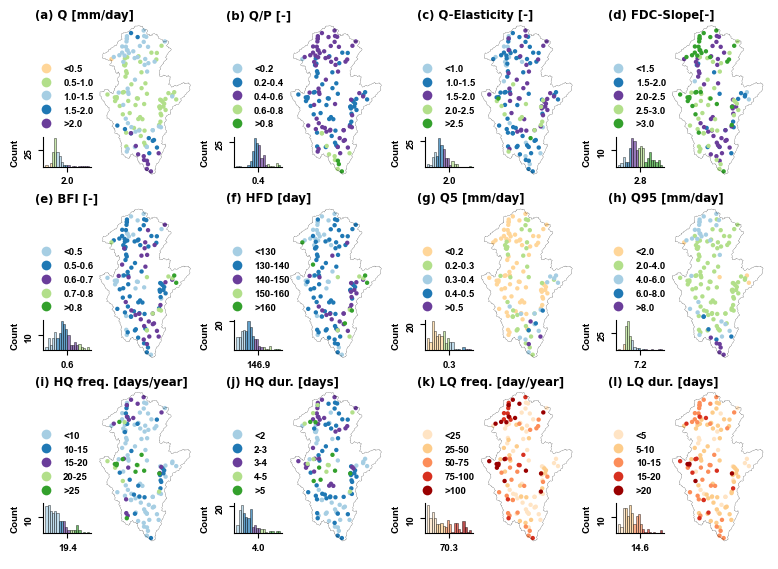

In [249]:
# List of variables
variable_list = ["q_mean"]
variable_list = ["q_mean", "q_runoff_ratio", "q_elas_Sankarasubramanian", "slope_sawicz", "baseflow_index", "hfd_mean", "q_5", "q_95", 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur']
#variable_list = ["q_95", "q_5"]

# Create a subplot grid
num_variables = len(variable_list)
num_cols = 4
num_rows = math.ceil(num_variables / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(7.7, 5.5))
axs = axs.flatten()

for i, variable in enumerate(variable_list):
    
    plot_variable_subplot(axs[i], variable, network_estreams_filtered, color_mapping_list, gdf)
    legend_title = color_mapping_list[variable][0]
        
    axs[i].set_title(f'({chr(97+i)}) {legend_title}', loc="left", fontweight="bold", pad=0)  # Add subplot title with letter indexing
    # Plot the shapefile with white facecolor and black boundaries
    moselle_del.plot(ax=axs[i], facecolor='none', edgecolor='black', linewidth=0.1)
    #river_moselle.plot(ax=axs[i], linewidth=0.25)
    
    axs[i].set_xlim(3.7, 8) 
    axs[i].set_ylim(47.5, 50.5)  
    
# Adjust layout and remove space between subplots
plt.tight_layout(pad=0)

# Save the figure as a file
fig.savefig(r'results\figs\fig_signatures_v02.png', dpi=300, bbox_inches='tight')

# Save or display the plot
plt.show()

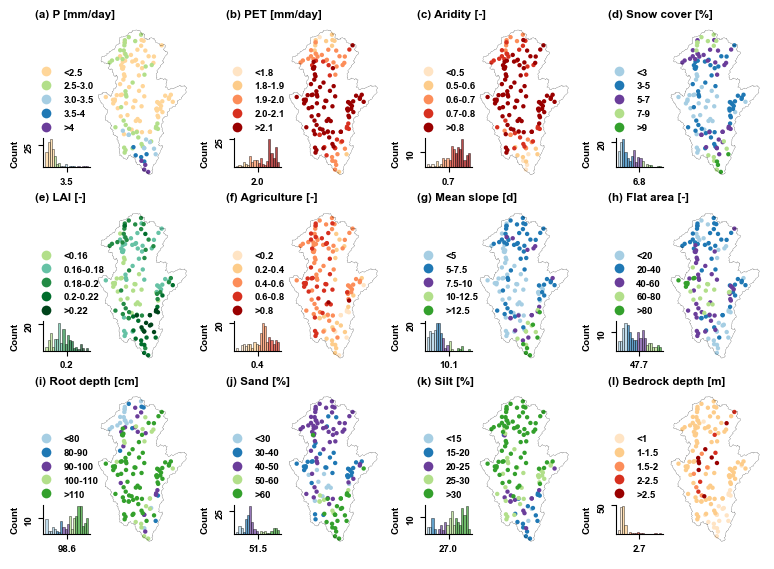

In [250]:
# List of variables
variable_list = ['p_mean', 'pet_mean', 'aridity', "sno_cov_mean", 'lai_mean', 'lulc_2006_agriculture', 'slp_dg_mean', "flat_area_fra", 'root_dep_mean', 'soil_fra_sand_mean', 'soil_fra_silt_mean', "bedrk_dep"]
#variable_list = ['pet_mean']

# Create a subplot grid
num_variables = len(variable_list)
num_cols = 4
num_rows = math.ceil(num_variables / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(7.7, 5.5))
axs = axs.flatten()

for i, variable in enumerate(variable_list):
    
    plot_variable_subplot(axs[i], variable, network_estreams_filtered, color_mapping_list, gdf)
    legend_title = color_mapping_list[variable][0]
        
    axs[i].set_title(f'({chr(97+i)}) {legend_title}', loc="left", fontweight="bold")  # Add subplot title with letter indexing
    # Plot the shapefile with white facecolor and black boundaries
    moselle_del.plot(ax=axs[i], facecolor='none', edgecolor='black', linewidth=0.1)
    #river_moselle.plot(ax=axs[i], linewidth=0.25)
    
    axs[i].set_xlim(3.7, 8) 
    axs[i].set_ylim(47.5, 50.5)  
    
# Adjust layout and remove space between subplots
plt.tight_layout(pad=0)

# Save the figure as a file
fig.savefig(r'results\figs\fig_plots_v02.png', dpi=300, bbox_inches='tight')

# Save or display the plot
plt.show()

# Main figure

In [48]:
# Set the basin_id as the index
catchment_boundaries.set_index("basin_id", inplace=True)
# Reproject to EPSG:4326
catchment_boundaries = catchment_boundaries.to_crs(epsg=4326)

In [52]:
from shapely.geometry import Point
import pandas as pd

# Assuming network_estreams_filtered is your DataFrame with lat and lon columns
# Create a GeoDataFrame from network_estreams_filtered
geometry = [Point(xy) for xy in zip(network_estreams_filtered['lon'], network_estreams_filtered['lat'])]
network_estreams_gdf = gpd.GeoDataFrame(network_estreams_filtered, geometry=geometry, crs='EPSG:4326')

In [53]:
# Global geology clipped to the Moselle catchment
GLiM_moselle = gpd.read_file(r'..\estreams_part_b\data\gis\raster\glim_moselle_wgs.shp')

attribute_field = 'xx'
GLiM_moselle_dissolved = GLiM_moselle.dissolve(by=attribute_field)

# Now we create a new feature with the geology class:
GLiM_moselle_dissolved["class"] = GLiM_moselle_dissolved.index

# Define the permeability columns dictionary
permeability_columns_glim = {
    "very low": ['ev', 'ig', 'pa', 'pb', 'va', 'vb', "wb"],
    "low": ['mt', 'pi', 'py', 'vi'],
    "medium": ['sc', 'sm'],
    "high": ['su', 'ss']
}

# Create a new column for reclassified permeability
def reclassify_glim_class(class_name):
    for permeability, classes in permeability_columns_glim.items():
        if class_name in classes:
            return permeability
    return None

GLiM_moselle_dissolved['permeability'] = GLiM_moselle_dissolved['class'].apply(reclassify_glim_class)

In [54]:
# Continental geology clipped to the Moselle catchment
geology_median_moselle = gpd.read_file(r'..\estreams_part_b\data\gis\raster\geology_median_moselle_wgs.shp')

attribute_field = 'LEVEL3'
geology_median_moselle_dissolved = geology_median_moselle.dissolve(by=attribute_field)

# Now we create a new feature with the geology class:
geology_median_moselle_dissolved["class"] = geology_median_moselle_dissolved.index

# Define the permeability columns dictionary
permeability_columns_geology = {
    "high": ["Conglomerates", "Conglomerates and sands", "Gravels", 
             "Sands", "Sandstones", "Sandstones and sands"],
    "medium": ["Conglomerates and clays", "Gneisses", "Limestones", 
               "Limestones and sands", "Sandstones and clays", "Sandstones and marls",
               "Limestones and clays", "Limestones and marls", "Marlstones and sands"],
    "low": ["Claystones and clays", "Marbles",
              "Marls", "Marlstones", "Marlstones and clays", 
              "Marlstones and marls", "Phyllites", "Schists",
              "Silts"],
    "very low": ["Plutonic rocks", "Volcanic rocks", 
                    "Inland water", "Snow field / ice field",
                    "Clays",  'Quartzites', "Shales"]
}

# Create a new column for reclassified permeability
def reclassify_geology_class(class_name):
    for permeability, classes in permeability_columns_geology.items():
        if class_name in classes:
            return permeability
    return None

geology_median_moselle_dissolved['permeability'] = geology_median_moselle_dissolved['class'].apply(reclassify_geology_class)


In [55]:
# Regional geology clipped to the Moselle catchment
geology_high_moselle = gpd.read_file(r'..\estreams_part_b\data\lithology\moselle_hr_ff.shp')

attribute_field = 'Labels01'
geology_high_moselle_dissolved = geology_high_moselle.dissolve(by=attribute_field)

# Now we create a new feature with the geology class:
geology_high_moselle_dissolved["class"] = geology_high_moselle_dissolved.index

# Set the CRS to WGS84
geology_high_moselle_dissolved = geology_high_moselle_dissolved.to_crs(epsg=4326)


# Define the permeability columns dictionary
permeability_columns_geology = {
    "high": ["Alluvium", 'Coal', 'Conglomerate', 'Gravel and sand',
             'Sand', 'Sand and gravel', 'Sandstone and conglomerate', 'Sandstone'
        ],
    
    "medium": ['Limestone', 'Sandstone and marl', 'Sandstone and schist',
              'Sandstone, conglomerate and marl'],
    
    "low": ['Arkose', 'Dolomite rock', 'Limestone and marl', 'Marl', 
             'Marl and dolomite', 'Marl and limestone', 'Marl and sandstone',
             'Sandstone and siltstone', 'Sandstone, siltstone and schist', 
              'Schist and sandstone', 'Silt',  'Silt and schist', 'Siltstone, sandstone and schist'
              ,"Siltstone"
             ],
    
    "very low": ['Cristallin basement', 'Plutonic rock',  'Quarzite',
                    'Schist','Volcanic rock' 
                   ]
}

# Create a new column for reclassified permeability
def reclassify_geology_class(class_name):
    for permeability, classes in permeability_columns_geology.items():
        if class_name in classes:
            return permeability
    return None

geology_high_moselle_dissolved['permeability'] = geology_high_moselle_dissolved['class'].apply(reclassify_geology_class)

Current CRS: EPSG:4326
Image is already in WGS84 CRS.


findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

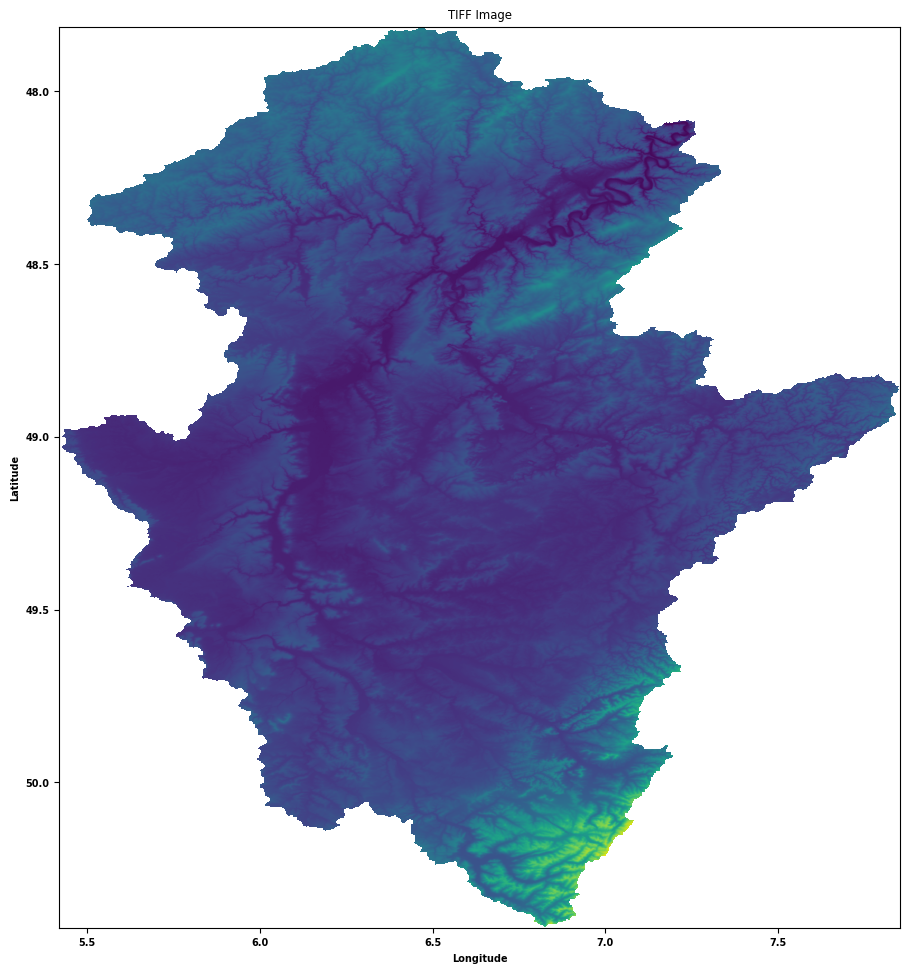

In [56]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt

# Path to the TIFF file
tiff_path = '..\estreams_part_b\data/elevation/moselle_srtm.tif'

# Open the TIFF file
with rasterio.open(tiff_path) as src:
    # Check the current CRS
    current_crs = src.crs
    print(f'Current CRS: {current_crs}')

    # Define the target CRS (WGS84)
    dst_crs = 'EPSG:4326'  # WGS84

    # If the current CRS is not WGS84, reproject the image
    if current_crs != dst_crs:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Create an in-memory array to hold the reprojected data
        reprojected_image = rasterio.io.MemoryFile().open(**kwargs)

        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(reprojected_image, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

        # Read the reprojected image
        elevation_wgs = reprojected_image.read(1)

        print(f'Image reprojected to WGS84 and stored in-memory.')
    else:
        # Read the original image if it is already in WGS84
        elevation_wgs = src.read(1)
        transform = src.transform
        print('Image is already in WGS84 CRS.')

# Calculate the extent
left, bottom, right, top = transform * (0, 0), transform * (elevation_wgs.shape[1], 0), transform * (elevation_wgs.shape[1], elevation_wgs.shape[0]), transform * (0, elevation_wgs.shape[0])
extent = (left[0], right[0], bottom[1], top[1])

# Plot the image with the correct extent
fig, ax = plt.subplots(1, 1, figsize=(16.6, 11.7))
ax.imshow(elevation_wgs, cmap='viridis', extent=extent)
ax.set_title('TIFF Image')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()


### Three geologies for the Moselle

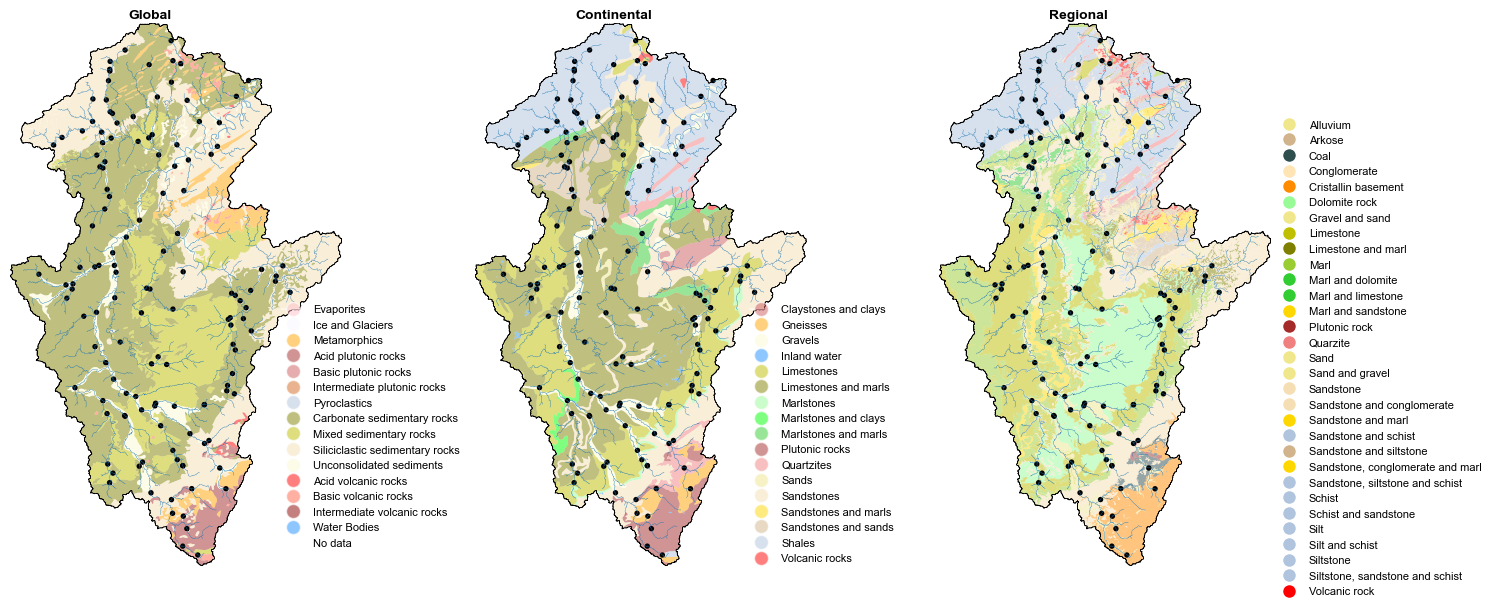

In [346]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


# Select multiple geometries
FR_selected = catchment_boundaries.loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')


# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'ev': "pink",  # Evaporites
    'ig': "ghostwhite",  # Ice and Glaciers
    'mt': "orange",  # Metamorphics
    'pa': "brown",  # Acid plutonic rocks
    'pb': "indianred",  # Basic plutonic rocks
    'pi': "chocolate",  # Intermediate plutonic rocks
    'py': "lightsteelblue",  # Pyroclastics
    'sc': "olive",  # Carbonate sedimentary rocks
    'sm': "y",  # Mixed sedimentary rocks
    'ss': "#F5DEB3",  # Siliciclastic sedimentary rocks
    'su': "#FAFAD2",  # Unconsolidated sediments
    'va': "red",  # Acid volcanic rocks
    'vb': "tomato",  # Basic volcanic rocks
    'vi': "darkred",  # Intermediate volcanic rocks
    'wb': "#1E90FF",  # Water Bodies
    'nd': "white"   # Precambrian rocks
}

# Define the first color mapping for GLiM_dissolved just for the legend (full names)
color_mapping_glim_legend = {
    'Evaporites': "pink",  # Evaporites
    'Ice and Glaciers': "ghostwhite",  # Ice and Glaciers
    'Metamorphics': "orange",  # Metamorphics
    'Acid plutonic rocks': "brown",  # Acid plutonic rocks
    'Basic plutonic rocks': "indianred",  # Basic plutonic rocks
    'Intermediate plutonic rocks': "chocolate",  # Intermediate plutonic rocks
    'Pyroclastics': "lightsteelblue",  # Pyroclastics
    'Carbonate sedimentary rocks': "olive",  # Carbonate sedimentary rocks
    'Mixed sedimentary rocks': "y",  # Mixed sedimentary rocks
    'Siliciclastic sedimentary rocks': "#F5DEB3",  # Siliciclastic sedimentary rocks
    'Unconsolidated sediments': "#FAFAD2",  # Unconsolidated sediments
    'Acid volcanic rocks': "red",  # Acid volcanic rocks
    'Basic volcanic rocks': "tomato",  # Basic volcanic rocks
    'Intermediate volcanic rocks': "darkred",  # Intermediate volcanic rocks
    'Water Bodies': "#1E90FF",  # Water Bodies
    'No data': "white"   # Precambrian rocks
}


# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'Claystones and clays': 'indianred',       # Saddle Brown
    'Gneisses': 'orange',                       # Dim Gray
    'Gravels': '#FAFAD2',                         # Light Yellow
    'Inland water': '#1E90FF',                 # Dodger Blue
    'Limestones': 'y',                       # Light Slate Gray
    'Limestones and marls': 'olive',            # Slate Gray
    'Marlstones': 'palegreen',                   # Pale Green
    'Marlstones and clays': 'lime',         # Dark Olive Green
    'Marlstones and marls': '#32CD32',         # Lime Green
    'Plutonic rocks': 'brown',                 # Black
    'Quartzites': 'lightcoral',                   # Dark Slate Blue
    'Sands': 'khaki',                        # Light Goldenrod Yellow
    'Sandstones': '#F5DEB3',                   # Burlywood
    'Sandstones and marls': 'gold',         # Peru
    'Sandstones and sands': 'tan',         # Wheat
    'Shales': 'lightsteelblue',                       # Dark Slate Gray
    'Volcanic rocks': 'red'                # Dark Red
}

# Corrected color mapping with same colors for classes with the same name
color_mapping_geology_high = {
    'Alluvium': '#F0E68C',                        # Khaki-like, slightly lighter than sand
    'Arkose': '#D2B48C',                          # Tan
    'Coal': '#2F4F4F',                            # Dark Slate Gray (for a coal-like appearance)
    'Conglomerate': '#FFE4B5',                    # Moccasin, similar to gravel
    'Cristallin basement': '#FF8C00',             # Dark Orange, similar to 'Gneisses'
    'Dolomite rock': '#98FB98',                   # PaleGreen
    'Gravel and sand': '#F0E68C',                 # Same as Sand, as they are closely related
    'Limestone': 'y',                             # Yellow, same as before
    'Limestone and marl': 'olive',                # Same as before
    'Marl': '#9ACD32',                            # YellowGreen, similar to PaleGreen but unique
    'Marl and dolomite': '#32CD32',               # LimeGreen, same as before
    'Marl and limestone': '#32CD32',              # Same as Marl and dolomite (same color logic)
    'Marl and sandstone': 'gold',                 # Same as Sandstones and marls
    'Plutonic rock': 'brown',                     # Same as Plutonic rocks
    'Quarzite': 'lightcoral',                     # Same as Quartzites
    'Sand': 'khaki',                              # Same as Sands
    'Sand and gravel': 'khaki',                   # Same as Sand
    'Sandstone': '#F5DEB3',                       # Burlywood, same as Sandstones
    'Sandstone and conglomerate': '#F5DEB3',      # Same as Sandstones (close relationship)
    'Sandstone and marl': 'gold',                 # Same as Sandstones and marls
    'Sandstone and schist': 'lightsteelblue',     # Similar to Shales but distinct
    'Sandstone and siltstone': 'tan',             # Tan-like, similar to Arkose but unique
    'Sandstone, conglomerate and marl': 'gold',   # Same as Sandstones and marls
    'Sandstone, siltstone and schist': 'lightsteelblue',  # Similar to Shales
    'Schist': 'lightsteelblue',                   # Same as Shales (similar behavior)
    'Schist and sandstone': 'lightsteelblue',     # Same as Schist
    'Silt': 'lightsteelblue',                     # Same as Schist and Shales
    'Silt and schist': 'lightsteelblue',          # Same as Schist
    'Siltstone': 'lightsteelblue',                # Same as Schist and Shales
    'Siltstone, sandstone and schist': 'lightsteelblue',  # Same as Schist
    'Volcanic rock': 'red'                        # Dark Red, same as Volcanic rocks
}



# Add a column for colors based on the class
GLiM_moselle_dissolved['color'] = GLiM_moselle_dissolved['class'].map(color_mapping_glim)
geology_median_moselle_dissolved['color'] = geology_median_moselle_dissolved['class'].map(color_mapping_geology)
geology_high_moselle_dissolved['color'] = geology_high_moselle_dissolved['class'].map(color_mapping_geology_high)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))

# Plot the first geology shapefile with different colors for each class
GLiM_moselle_dissolved.plot(column='class', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax1, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.25, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax1, color='black', markersize=15, edgecolor='none', linewidth=0.5, 
                          label='Streamflow gauges')

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('')

# Create custom legend elements with circles for the first plot
geology_legend_elements1 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, alpha=0.5, 
                                   label=cls) for cls, color in color_mapping_glim_legend.items()]
geology_legend1 = ax1.legend(handles=geology_legend_elements1, title='', 
                             bbox_to_anchor=(0.79, 0.5), frameon=False)

# Add the geological classes legend back to the first plot
#ax1.add_artist(geology_legend1)

# Plot the second geology shapefile with different colors for each class
geology_median_moselle_dissolved.plot(column='class', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

## Plot the points from network_estreams_filtered
#network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
#                          label='Measurement Points')


# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.25, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=15, edgecolor='none', linewidth=0.5, 
                          label='Streamflow gauges')

# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
ax2.set_title('')
ax2.set_xlabel('')
ax2.set_ylabel('')

# Create custom legend elements with circles for the second plot
geology_legend_elements2 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, alpha=0.5,
                                   label=cls) for cls, color in color_mapping_geology.items()]
geology_legend2 = ax2.legend(handles=geology_legend_elements2, title='', 
                             bbox_to_anchor=(0.8, 0.5), frameon=False)

# Add the geological classes legend back to the second plot
#ax2.add_artist(geology_legend2)
###########################################################################################################
# Plot the THIRD geology shapefile with different colors for each class
geology_high_moselle_dissolved.plot(column='class', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='black', linewidth=0.5, label='')

## Plot the points from network_estreams_filtered
#network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
#                          label='Measurement Points')


# Plot the river
river_moselle.plot(ax=ax3, linewidth=0.25, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=15, edgecolor='none', linewidth=0.5, 
                          label='Streamflow gauges')

# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
ax3.set_title('')
ax3.set_xlabel('')
ax3.set_ylabel('')

# Create custom legend elements with circles for the second plot
geology_legend_elements3 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, alpha=1,
                                   label=cls) for cls, color in color_mapping_geology_high.items()]
# Add the legend to the third plot, keeping its current location
geology_legend3 = ax3.legend(handles=geology_legend_elements3, title='', 
                             bbox_to_anchor=(0.99, 0.84), frameon=False)


# Add the geological classes legend back to the second plot
#ax3.add_artist(geology_legend3)


## Extract color mapping information from the color mapping list
#legend_labels = color_mapping_list[variable][2]
#color_mapping = color_mapping_list[variable][3]
#
## Extract color mapping information from the color mapping list
#legend_labels = color_mapping_list[variable][2]
#color_mapping = color_mapping_list[variable][3]

text_to_subplots = ["Global", "Continental", "Regional"]
i = 0 
for ax in [ax1, ax2, ax3]:

    # Hide spines for main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    # Add text below the plot
    ax.text(0.42, 1.025, text_to_subplots[i], transform=ax.transAxes, 
            fontsize=10, ha='center', va='top', color='black', fontweight='bold')
    i = i + 1

fig.tight_layout()

fig.savefig(r'results\figs\fig_3geologies.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Study area figure

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

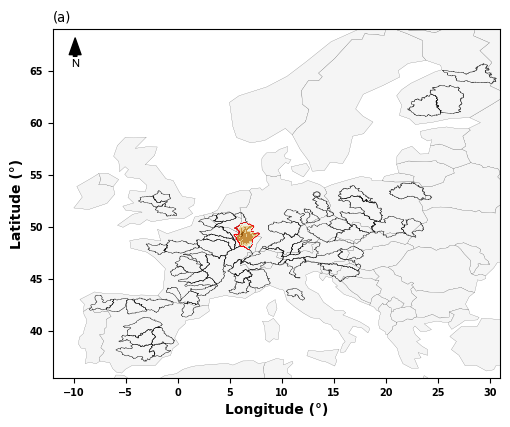

In [57]:
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from shapely.geometry import box
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as mpl


# Create the figure with two main columns: one for the first figure, one for the second figure (which will have 3 subplots)
fig = plt.figure(figsize=(5, 8))
gs = fig.add_gridspec(2, 1)

# Create the first figure in the first column
ax = fig.add_subplot(gs[0, 0])

list_cats_list = ['ES000801', 'ES000665', 'ES001243', 'ES000196', 'ES000194', 'ES001080',
       'ES000316', 'ES000339', 'GB000472', 'GB000271', 'GB000153', 'ITTO0361',
       'ITVE0408', 'ITPI0183', 'FI000557', 'FI000226', 'FI000137', 'PL000936',
       'PL000794', 'HR000048', 'HUGR0037', 'AT000393', 'PL000253', 'PL000349',
       'PL000015', 'CZ000097', 'DEST1711', 'DEBY0711', 'DEBY0724', 'DEBY0697',
       'DEBU1953', 'NL000008', 'CH000026', 'FR002679', 'FR004615', 'NL000016',
       'BEVL0155', 'FR000408', 'FR000373', 'FR000345', 'FR001071', 'FR003922',
       'FR003986', 'FR002118', 'FR001952', 'FR002029', 'FR001604', 'FR004221',
       'ES001171', 'ES001010', 'PL000536', 'HR000278', 'CZ000236', 'DEST1707',
       'DEBE0155', 'FR002758', 'FR002462', 'FR001394', 'FR000867', 'FR004308',
       'DEBU1959']


# Select multiple geometries
cats_selected = catchment_boundaries.loc[list_cats_list, "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
cats_selected_gdf = gpd.GeoDataFrame({'geometry': cats_selected}, crs='EPSG:4326')


# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs_all = {}

for catchment in list_cats_list:
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_catchments.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs_all[catchment] = cat_clip

# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'arial'  # Change the font family
mpl.rcParams['font.size'] = 8            # Change the font size
mpl.rcParams['font.weight'] = 'normal'   # Change font weight
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight

estreams_attributes_used = estreams_attributes_dfs_all.copy()

# Set the background color to white
ax.set_facecolor('white')

# Plot the shapefile with white facecolor and black boundaries
gdf.plot(ax=ax, facecolor='whitesmoke', edgecolor='black', linewidth=0.1)

ax.set_xlim(-12, 31)
ax.set_ylim(35.5, 69)

# Define markers for each watershed group
#markers = ['o', 's', '^', 'D', 'P']  # You can extend this list if needed

#river_dissolved.plot(ax=ax, linewidth=0.25, alpha=0.5)

cats_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.3, label='', alpha=0.7)

# Plot the gauges for each desired watershed group
colors = plt.cm.tab10(np.linspace(0, 1, len(estreams_attributes_used.keys())))  # Get distinct colors
i = 0
#for catchment, data in estreams_attributes_used.items():
#    #marker = markers[i % len(markers)]  # Choose marker cyclically
#    color = colors[i]  # Choose color from the colormap
#    ax.scatter(data['lon'], data['lat'], color='black', edgecolor='none',linewidth=0.0,
#            marker='o', s=0.25, label=catchment, alpha=1.0, zorder = 1000)
#    i += 1
#    # Overlay the study area boundaries



# Select multiple geometries
cat_selected = catchment_boundaries.loc[["DEBU1959"], "geometry"]
# Create a GeoDataFrame from the selected geometries and set the CRS directly
cat_selected_gdf = gpd.GeoDataFrame({'geometry': cat_selected}, crs='EPSG:4326')
cat_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.4, label='')


ax.set_aspect('equal')  # Adjust aspect ratio as needed
#ax.set_axis_off()  # Turn off both x-axis and y-axis
ax.set_xlabel('Longitude (°)', fontsize=10)
ax.set_ylabel('Latitude (°)', fontsize=10)
ax.set_title("(a)", loc="left")

# Add a north arrow
x, y, arrow_length = 0.05, 0.975, 0.075
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length), arrowprops=dict(facecolor='black', width=2.5, headwidth=8.5), ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Select multiple geometries
moselle_boundaries = catchment_boundaries.loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
moselle_boundaries_gdf = gpd.GeoDataFrame({'geometry': moselle_boundaries}, crs='EPSG:4326')

# Set plot limits to the bounding box of the selected study areas
bounds = moselle_boundaries_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = moselle_boundaries_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Calculate the extent
left, bottom = transform * (0, 0)
right, top = transform * (elevation_wgs.shape[1], elevation_wgs.shape[0])
extent = (left, right, top, bottom)  # Notice the order for top and bottom

# Define the color classes (discrete intervals)
bounds = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]  # Define class boundaries
cmap = plt.get_cmap('BrBG')  # Choose a colormap
norm = BoundaryNorm(bounds, cmap.N)  # Normalize based on the class boundaries

## Plot the elevation data with class intervals
cax = ax.imshow(elevation_wgs, cmap=cmap, norm=norm, extent=extent, zorder = 100)


# Adjust the layout to remove extra space
plt.tight_layout()


#fig.savefig(r'results\figs\fig_study_area_a.png', dpi=300, bbox_inches='tight')

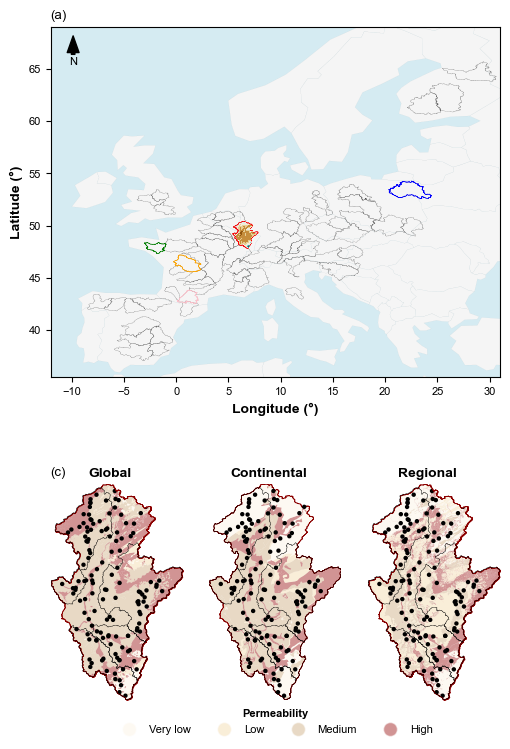

In [58]:
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from shapely.geometry import box
from matplotlib.colors import BoundaryNorm


# Create the figure with two main columns: one for the first figure, one for the second figure (which will have 3 subplots)
fig = plt.figure(figsize=(5, 8))
gs = fig.add_gridspec(2, 1)

# Create the first figure in the first column
ax = fig.add_subplot(gs[0, 0])

list_cats_list = ['ES000801', 'ES000665', 'ES001243', 'ES000196', 'ES000194', 'ES001080',
       'ES000316', 'ES000339', 'GB000472', 'GB000271', 'GB000153', 'ITTO0361',
       'ITVE0408', 'ITPI0183', 'FI000557', 'FI000226', 'FI000137', 'PL000936',
       'PL000794', 'HR000048', 'HUGR0037', 'AT000393', 'PL000253', 'PL000349',
       'PL000015', 'CZ000097', 'DEST1711', 'DEBY0711', 'DEBY0724', 'DEBY0697',
       'DEBU1953', 'NL000008', 'CH000026', 'FR002679', 'FR004615', 'NL000016',
       'BEVL0155', 'FR000408', 'FR000373', 'FR000345', 'FR001071', 'FR003922',
       'FR003986', 'FR002118', 'FR001952', 'FR002029', 'FR001604', 'FR004221',
       'ES001171', 'ES001010', 'PL000536', 'HR000278', 'CZ000236', 'DEST1707',
       'DEBE0155', 'FR002758', 'FR002462', 'FR001394', 'FR000867', 'FR004308',
       'DEBU1959']


# Select multiple geometries
cats_selected = catchment_boundaries.loc[list_cats_list, "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
cats_selected_gdf = gpd.GeoDataFrame({'geometry': cats_selected}, crs='EPSG:4326')

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs_all = {}

for catchment in list_cats_list:
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_catchments.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs_all[catchment] = cat_clip

# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'arial'  # Change the font family
mpl.rcParams['font.size'] = 8            # Change the font size
mpl.rcParams['font.weight'] = 'normal'   # Change font weight
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight

estreams_attributes_used = estreams_attributes_dfs_all.copy()

# Set the background color to white
#ax.set_facecolor('white')
ax.set_facecolor((0.68, 0.85, 0.9, 0.5))  # RGBA for light blue with 50% transparency

# Plot the shapefile with white facecolor and black boundaries
gdf.plot(ax=ax, facecolor='whitesmoke', edgecolor='black', linewidth=0.01)

ax.set_xlim(-12, 31)
ax.set_ylim(35.5, 69)

# Define markers for each watershed group
#markers = ['o', 's', '^', 'D', 'P']  # You can extend this list if needed

#river_dissolved.plot(ax=ax, linewidth=0.25, alpha=0.5)

cats_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.1, label='', alpha=0.7)

# Plot the gauges for each desired watershed group
colors = plt.cm.tab10(np.linspace(0, 1, len(estreams_attributes_used.keys())))  # Get distinct colors
#i = 0
#for catchment, data in estreams_attributes_used.items():
#    #marker = markers[i % len(markers)]  # Choose marker cyclically
#    color = colors[i]  # Choose color from the colormap
#    ax.scatter(data['lon'], data['lat'], color='black', edgecolor='none',linewidth=0.0,
#            marker='o', s=0.25, label=catchment, alpha=1.0, zorder = 1000)
#    i += 1
#    # Overlay the study area boundaries



# Select multiple geometries
cat_selected = catchment_boundaries.loc[["DEBU1959"], "geometry"]
# Create a GeoDataFrame from the selected geometries and set the CRS directly
cat_selected_gdf = gpd.GeoDataFrame({'geometry': cat_selected}, crs='EPSG:4326')
cat_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.4, label='')

cat_selected = catchment_boundaries.loc[["PL000936"], "geometry"]
# Create a GeoDataFrame from the selected geometries and set the CRS directly
cat_selected_gdf = gpd.GeoDataFrame({'geometry': cat_selected}, crs='EPSG:4326')
cat_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=0.4, label='')

cat_selected = catchment_boundaries.loc[["FR000867"], "geometry"]
# Create a GeoDataFrame from the selected geometries and set the CRS directly
cat_selected_gdf = gpd.GeoDataFrame({'geometry': cat_selected}, crs='EPSG:4326')
cat_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='green', linewidth=0.4, label='')

cat_selected = catchment_boundaries.loc[["FR003986"], "geometry"]
# Create a GeoDataFrame from the selected geometries and set the CRS directly
cat_selected_gdf = gpd.GeoDataFrame({'geometry': cat_selected}, crs='EPSG:4326')
cat_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=0.4, label='')

cat_selected = catchment_boundaries.loc[["FR001604"], "geometry"]
# Create a GeoDataFrame from the selected geometries and set the CRS directly
cat_selected_gdf = gpd.GeoDataFrame({'geometry': cat_selected}, crs='EPSG:4326')
cat_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='pink', linewidth=0.4, label='')


ax.set_aspect('equal')  # Adjust aspect ratio as needed
#ax.set_axis_off()  # Turn off both x-axis and y-axis
ax.set_xlabel('Longitude (°)', fontsize=10)
ax.set_ylabel('Latitude (°)', fontsize=10)
ax.set_title("(a)", loc="left")

# Add a north arrow
x, y, arrow_length = 0.05, 0.975, 0.075
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length), arrowprops=dict(facecolor='black', width=2.5, headwidth=8.5), ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Select multiple geometries
moselle_boundaries = catchment_boundaries.loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
moselle_boundaries_gdf = gpd.GeoDataFrame({'geometry': moselle_boundaries}, crs='EPSG:4326')

# Set plot limits to the bounding box of the selected study areas
bounds = moselle_boundaries_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = moselle_boundaries_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Calculate the extent
left, bottom = transform * (0, 0)
right, top = transform * (elevation_wgs.shape[1], elevation_wgs.shape[0])
extent = (left, right, top, bottom)  # Notice the order for top and bottom

# Define the color classes (discrete intervals)
bounds = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]  # Define class boundaries
cmap = plt.get_cmap('BrBG')  # Choose a colormap
norm = BoundaryNorm(bounds, cmap.N)  # Normalize based on the class boundaries

## Plot the elevation data with class intervals
cax = ax.imshow(elevation_wgs, cmap=cmap, norm=norm, extent=extent, zorder = 100)

#---------------------------------------------------------------------------------------------------------------------------------------------
gs_sub = gs[1, 0].subgridspec(1, 3)  # Create space for 3 rows in the second column

### Second grid:
# First subplot
ax1 = fig.add_subplot(gs_sub[0, 0])

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Select multiple geometries
FR_selected = catchment_boundaries.loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'very low': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'very low': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'very low': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

color_dict_legend = {
    'very low': 'oldlace',
    'low': 'wheat',
    'medium': 'tan',
    'high': 'brown'
}

# Add a column for colors based on the class
GLiM_moselle_dissolved['color'] = GLiM_moselle_dissolved['permeability'].map(color_mapping_glim)
geology_median_moselle_dissolved['color'] = geology_median_moselle_dissolved['permeability'].map(color_mapping_geology)
geology_high_moselle_dissolved['color'] = geology_high_moselle_dissolved['permeability'].map(color_mapping_geology2)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plot the first geology shapefile with different colors for each class
GLiM_moselle_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='darkred', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax1, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='darkred', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_title('(c)', loc="left")
ax1.set_xlabel('')
ax1.set_ylabel('')



ax2 = fig.add_subplot(gs_sub[0, 1])
ax3 = fig.add_subplot(gs_sub[0, 2])

# Plot the second geology shapefile with different colors for each class
geology_median_moselle_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='darkred', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')

# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
#ax2.set_title('(c)', loc="left")
ax2.set_xlabel('')
ax2.set_ylabel('')
custom_label = ["Very low", "Lower", "Medium", "Higher"]

# Plot the third geology shapefile with different colors for each class
geology_high_moselle_dissolved.plot(column='permeability', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='darkred', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')

# Select multiple geometries
FR_selected = catchment_boundaries.loc[["FR003283", "FR003249", "FR000159", "LU000017", "DEBU1957"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Plot the river
#river_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='darkred', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
#ax3.set_title('(d)', loc="left")

text_to_subplots = ["Global", "Continental", "Regional"]
i = 0 
for ax in [ax1, ax2, ax3]:

    # Overlay the study area boundaries
    FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.25, label='Sub-catchments')

    # Hide spines for main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    # Add text below the plot
    ax.text(0.45, 1.075, text_to_subplots[i], transform=ax.transAxes, 
            fontsize=10, ha='center', va='top', color='black', fontweight='bold')
    i = i + 1

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba

# Define the color dictionary with alpha transparency (0.5 for 50% opacity)
color_dict_legend = {
    'Very low': to_rgba('oldlace', 0.5),
    'Low': to_rgba('wheat', 0.5),
    'Medium': to_rgba('tan', 0.5),
    'High': to_rgba('brown', 0.5)
}

# Create custom legend elements with alpha applied to markerfacecolor
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in color_dict_legend.items()]

# Add the legend outside the plot area with minimal space
legend = ax2.legend(handles=legend_elements, title='Permeability', loc='center', frameon=False, 
                   bbox_to_anchor=(0.5, -0.1), ncol=5)
# Make the legend title bold
legend.get_title().set_fontweight('bold')

# Adjust the layout to remove extra space
plt.tight_layout()


fig.savefig(r'results\figs\fig_study_area_a.png', dpi=300, bbox_inches='tight')

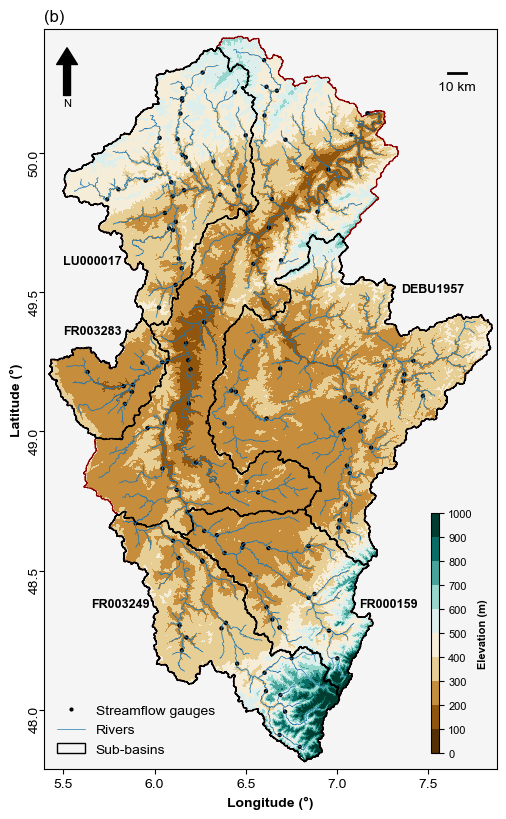

In [54]:
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from shapely.geometry import box
from matplotlib.colors import BoundaryNorm
from shapely.geometry import box


# Create the figure with two main columns: one for the first figure, one for the second figure (which will have 3 subplots)
fig, ax = plt.subplots(figsize=(5, 8))


data_df = estreams_attributes_dfs["DEBU1959"]
# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'arial'  # Change the font family
mpl.rcParams['font.size'] = 10           # Change the font size
mpl.rcParams['font.weight'] = 'normal'   # Change font weight
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight


# Clear the subplot
ax.clear()

# Set the background color to white
ax.set_facecolor('whitesmoke')

# Plot the shapefile with white facecolor and black boundaries
#gdf.plot(ax=ax, facecolor='white', edgecolor='black', linewidth=0.1)


# Select multiple geometries
FR_selected = catchment_boundaries.loc[["FR003283", "FR003249", "FR000159", "LU000017", "DEBU1957"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Select multiple geometries
moselle_boundaries = catchment_boundaries.loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
moselle_boundaries_gdf = gpd.GeoDataFrame({'geometry': moselle_boundaries}, crs='EPSG:4326')

# Set plot limits to the bounding box of the selected study areas
bounds = moselle_boundaries_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = moselle_boundaries_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)


# Calculate the extent
left, bottom = transform * (0, 0)
right, top = transform * (elevation_wgs.shape[1], elevation_wgs.shape[0])
extent = (left, right, top, bottom)  # Notice the order for top and bottom

## Define the color limits
#vmin, vmax = 200, 1000  # Set your desired min and max values for the color map
#
## Display the image with specified color range
#cax = ax.imshow(elevation_wgs, cmap='BrBG', extent=extent, vmin=vmin, vmax=vmax)

# Define the color classes (discrete intervals)
bounds = [0, 100,200, 300, 400, 500, 600, 700, 800, 900, 1000]  # Define class boundaries
cmap = plt.get_cmap('BrBG')  # Choose a colormap
norm = BoundaryNorm(bounds, cmap.N)  # Normalize based on the class boundaries

# Plot the elevation data with class intervals
cax = ax.imshow(elevation_wgs, cmap=cmap, norm=norm, extent=extent)

# Add colorbar with class labels
#cbar = fig.colorbar(cax, ticks=bounds)
#cbar.set_label('Elevation (m)')
# Create a small colorbar inside the plot
cbar_ax = fig.add_axes([0.85, 0.07, 0.015, 0.3])  # [left, bottom, width, height]
cbar = fig.colorbar(cax, cax=cbar_ax, orientation='vertical', ticks=bounds)
cbar.ax.tick_params(labelsize=8)  # Set the font size for the ticks
cbar.set_label('Elevation (m)', fontsize=8)  # Set the label with a smaller font size

# Adjust the colorbar size (shrink)
cbar.ax.set_aspect('auto')

# Set the title and show the plot
ax.set_title('(b)', loc = "left")


# Plot the river
river_moselle.plot(ax=ax, linewidth=0.5)

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax, facecolor='whitesmoke', edgecolor='darkred', linewidth=0.8)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, label='Sub-catchments')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Streamflow gauges')

# Set plot limits to the bounding box of the study area
ax.set_xlim(x_min-0.025, x_max+0.025)
ax.set_ylim(y_min-0.025, y_max+0.025)

ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
# Create manual legend entries:
# For sub-catchments (as a polygon with a black boundary)
subcatchment_patch = Patch(facecolor='none', edgecolor='black', label='Sub-basins')

# For streamflow gauges (as black dots)
streamflow_marker = Line2D([0], [0], color='black', lw=0, marker='o', markersize=2, label='Streamflow gauges')

# For another line (representing rivers)
river_line = Line2D([0], [0], lw=0.5, label='Rivers')

# Add the legend with all items
legend = ax.legend(handles=[streamflow_marker, river_line, subcatchment_patch], 
                   loc='lower left', fontsize=10, title="", title_fontsize='8', frameon=False)

# Add a north arrow
x, y, arrow_length = 0.05, 0.975, 0.075
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length), arrowprops=dict(facecolor='black', width=5, headwidth=15), ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Add a scale bar 
scalebar_length = 10  # in kilometers
x_scalebar = x_max - (x_max - x_min) * 0.1
y_scalebar = y_min + (y_max - y_min) * 0.95
ax.plot([x_scalebar, x_scalebar + scalebar_length/100], [y_scalebar, y_scalebar], color='black', linewidth=2)
ax.text(x_scalebar + (scalebar_length/200), y_scalebar - (y_max - y_min) * 0.02, f'{scalebar_length} km', ha='center', va='center', fontsize=10)

# Adding some text
ax.text(5.5, 49.35, 'FR003283', fontsize=9, color='black', fontweight='bold')
ax.text(5.5, 49.60, 'LU000017', fontsize=9, color='black', fontweight='bold')
ax.text(7.35, 49.50, 'DEBU1957', fontsize=9, color='black', fontweight='bold')
ax.text(7.12, 48.37, 'FR000159', fontsize=9, color='black', fontweight='bold')
ax.text(5.65, 48.37, 'FR003249', fontsize=9, color='black', fontweight='bold')

# Rotate the existing y-tick labels without changing them
ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha='center')



# Adjust the layout to remove extra space
plt.tight_layout(pad=0)


fig.savefig(r'results\figs\fig_study_areab.png', dpi=300)

# Show the plot
plt.show()

# End